In [1]:
import numpy as np
import cv2
import scipy.io
import os
from numpy.linalg import norm
from matplotlib import pyplot as plt
from numpy.linalg import det
from numpy.linalg import inv
from scipy.linalg import rq
from numpy.linalg import svd
import matplotlib.pyplot as plt
import numpy as np
import math
import random
import sys
from scipy import ndimage, spatial
from tqdm.notebook import tqdm, trange

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from skimage import io, transform,data
from torchvision import transforms, utils
import numpy as np
import math
import glob
import matplotlib.pyplot as plt
import time
import os
import copy
import sklearn.svm
import cv2
from matplotlib import pyplot as plt
import numpy as np
from os.path import exists
import pandas as pd
import PIL
import random
from google.colab import drive
from sklearn.metrics.cluster import completeness_score
from sklearn.cluster import KMeans
from tqdm import tqdm, tqdm_notebook
from functools import partial
from torchsummary import summary
from torchvision.datasets import ImageFolder
from torch.utils.data.sampler import SubsetRandomSampler
import h5py as h5

#cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
#accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

#print("Accelerator type = ",accelerator)
#print("Pytorch verision: ", torch.__version__)

In [2]:
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#!pip install ipython-autotime

#%load_ext autotime

In [3]:
!pip install opencv-python==3.4.2.17
!pip install opencv-contrib-python==3.4.2.17

In [2]:
class Image:
    def __init__(self, img, position):
        
        self.img = img
        self.position = position

inlier_matchset = []
def features_matching(a,keypointlength,threshold):
  #threshold=0.2
  bestmatch=np.empty((keypointlength),dtype= np.int16)
  img1index=np.empty((keypointlength),dtype=np.int16)
  distance=np.empty((keypointlength))
  index=0
  for j in range(0,keypointlength):
    #For a descriptor fa in Ia, take the two closest descriptors fb1 and fb2 in Ib
    x=a[j]
    listx=x.tolist()
    x.sort()
    minval1=x[0]                                # min 
    minval2=x[1]                                # 2nd min
    itemindex1 = listx.index(minval1)           #index of min val    
    itemindex2 = listx.index(minval2)           #index of second min value 
    ratio=minval1/minval2                       #Ratio Test
    
    if ratio<threshold: 
      #Low distance ratio: fb1 can be a good match
      bestmatch[index]=itemindex1
      distance[index]=minval1
      img1index[index]=j
      index=index+1
  return  [cv2.DMatch(img1index[i],bestmatch[i].astype(int),distance[i]) for i in range(0,index)]
          
   
  
def compute_Homography(im1_pts,im2_pts):
  """
  im1_pts and im2_pts are 2×n matrices with
  4 point correspondences from the two images
  """
  num_matches=len(im1_pts)
  num_rows = 2 * num_matches
  num_cols = 9
  A_matrix_shape = (num_rows,num_cols)
  A = np.zeros(A_matrix_shape)
  a_index = 0
  for i in range(0,num_matches):
    (a_x, a_y) = im1_pts[i]
    (b_x, b_y) = im2_pts[i]
    row1 = [a_x, a_y, 1, 0, 0, 0, -b_x*a_x, -b_x*a_y, -b_x] # First row 
    row2 = [0, 0, 0, a_x, a_y, 1, -b_y*a_x, -b_y*a_y, -b_y] # Second row 

    # place the rows in the matrix
    A[a_index] = row1
    A[a_index+1] = row2

    a_index += 2
    
  U, s, Vt = np.linalg.svd(A)

  #s is a 1-D array of singular values sorted in descending order
  #U, Vt are unitary matrices
  #Rows of Vt are the eigenvectors of A^TA.
  #Columns of U are the eigenvectors of AA^T.
  H = np.eye(3)
  H = Vt[-1].reshape(3,3) # take the last row of the Vt matrix
  return H
  
  
def displayplot(img,title):
  
  plt.figure(figsize=(15,15))
  plt.title(title)
  plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
  plt.show()

In [3]:
def get_inliers(f1, f2, matches, H, RANSACthresh):

  inlier_indices = []
  for i in range(len(matches)):
    queryInd = matches[i].queryIdx
    trainInd = matches[i].trainIdx

    #queryInd = matches[i][0]
    #trainInd = matches[i][1]

    queryPoint = np.array([f1[queryInd].pt[0],  f1[queryInd].pt[1], 1]).T 
    trans_query = H.dot(queryPoint) 

   
    comp1 = [trans_query[0]/trans_query[2], trans_query[1]/trans_query[2]] # normalize with respect to z
    comp2 = np.array(f2[trainInd].pt)[:2]
    

    if(np.linalg.norm(comp1-comp2) <= RANSACthresh): # check against threshold
      inlier_indices.append(i)
  return inlier_indices


def RANSAC_alg(f1, f2, matches, nRANSAC, RANSACthresh):

      
    minMatches = 4
    nBest = 0
    best_inliers = []
    H_estimate = np.eye(3,3)
    global inlier_matchset
    inlier_matchset=[]
    for iteration in range(nRANSAC):
      
        #Choose a minimal set of feature matches.
        matchSample = random.sample(matches, minMatches)
        
        #Estimate the Homography implied by these matches
        im1_pts=np.empty((minMatches,2))
        im2_pts=np.empty((minMatches,2))
        for i in range(0,minMatches):
          m = matchSample[i]
          im1_pts[i] = f1[m.queryIdx].pt
          im2_pts[i] = f2[m.trainIdx].pt
          #im1_pts[i] = f1[m[0]].pt
          #im2_pts[i] = f2[m[1]].pt             
          
        H_estimate=compute_Homography(im1_pts,im2_pts)
        
               
        # Calculate the inliers for the H
        inliers = get_inliers(f1, f2, matches, H_estimate, RANSACthresh)

        # if the number of inliers is higher than previous iterations, update the best estimates
        if len(inliers) > nBest:
            nBest= len(inliers)
            best_inliers = inliers

    print("Number of best inliers",len(best_inliers))
    for i in range(len(best_inliers)):
      inlier_matchset.append(matches[best_inliers[i]])
    
    # compute a homography given this set of matches
    im1_pts=np.empty((len(best_inliers),2))
    im2_pts=np.empty((len(best_inliers),2))
    for i in range(0,len(best_inliers)):
      m = inlier_matchset[i]
      im1_pts[i] = f1[m.queryIdx].pt
      im2_pts[i] = f2[m.trainIdx].pt
      #im1_pts[i] = f1[m[0]].pt
      #im2_pts[i] = f2[m[1]].pt

    M=compute_Homography(im1_pts,im2_pts)
    return M, best_inliers

In [4]:
tqdm = partial(tqdm, position=0, leave=True)

In [5]:
files_all=[]
for file in os.listdir("/content/drive/MyDrive/MAP-20210707T092105Z-001/MAP"):
    if file.endswith(".JPG"):
      files_all.append(file)


files_all.sort()
folder_path = '/content/drive/MyDrive/MAP-20210707T092105Z-001/MAP/'

#centre_file = folder_path + files_all[50]
left_files_path_rev = []
right_files_path = []


#Change this according to your dataset split

for file in files_all[:61]:
  left_files_path_rev.append(folder_path + file)

left_files_path = left_files_path_rev[::-1]

for file in files_all[60:120]:
  right_files_path.append(folder_path + file)

In [6]:
print(len(files_all))

176


In [7]:
from multiprocessing import Pool

In [8]:
import multiprocessing
print(multiprocessing.cpu_count())


2


In [9]:
gridsize = 8
clahe = cv2.createCLAHE(clipLimit=2.0,tileGridSize=(gridsize,gridsize))

images_left_bgr = []
images_right_bgr = []

images_left = []
images_right = []

for file in tqdm(left_files_path):
  left_image_sat= cv2.imread(file)
  lab = cv2.cvtColor(left_image_sat, cv2.COLOR_BGR2LAB)
  lab[...,0] = clahe.apply(lab[...,0])
  left_image_sat = cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)
  left_img = cv2.resize(left_image_sat,None,fx=0.35, fy=0.35, interpolation = cv2.INTER_CUBIC )
  images_left.append(cv2.cvtColor(left_img, cv2.COLOR_BGR2GRAY).astype('float32')/255.)
  images_left_bgr.append(left_img)


for file in tqdm(right_files_path):
  right_image_sat= cv2.imread(file)
  lab = cv2.cvtColor(right_image_sat, cv2.COLOR_BGR2LAB)
  lab[...,0] = clahe.apply(lab[...,0])
  right_image_sat = cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)
  right_img = cv2.resize(right_image_sat,None,fx=0.35,fy=0.35, interpolation = cv2.INTER_CUBIC )
  images_right.append(cv2.cvtColor(right_img, cv2.COLOR_BGR2GRAY).astype('float32')/255.)
  images_right_bgr.append(right_img)

100%|██████████| 60/60 [00:58<00:00,  1.02it/s]


In [10]:
Dataset = 'MAP Dataset'

In [11]:
f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','w')
t0=time.time()
f.create_dataset('data',data=images_left_bgr + images_right_bgr)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize(f'drive/MyDrive/all_images_bgr_{Dataset}.h5')/1.e6,'MB')

HDF5  w/o comp.: 3.8587255477905273 [s] ... size 887.702213 MB


In [ ]:
'''
f=h5.File(f'drive/MyDrive/all_images_gray_{Dataset}.h5','w')
t0=time.time()
f.create_dataset('data',data=images_left + images_right)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize(f'drive/MyDrive/all_images_gray_{Dataset}.h5')/1.e6,'MB')

HDF5  w/o comp.: 17.154690265655518 [s] ... size 1183.602268 MB


In [12]:
del images_left_bgr,images_right_bgr

In [ ]:
#images_left_bgr_no_enhance = []
#images_right_bgr_no_enhance = []

#for file in tqdm(left_files_path):
#  left_image_sat= cv2.imread(file)
#  left_img = cv2.resize(left_image_sat,None,fx=0.35, fy=0.35, interpolation = cv2.INTER_CUBIC)
#  images_left_bgr_no_enhance.append(left_img)

#for file in tqdm(right_files_path):
# right_image_sat= cv2.imread(file)
#  right_img = cv2.resize(right_image_sat,None,fx=0.35,fy=0.35, interpolation = cv2.INTER_CUBIC)
#  images_right_bgr_no_enhance.append(right_img)

In [13]:
from timeit import default_timer as timer

In [14]:
time_all = []

In [15]:
num_kps_sift = []
num_kps_brisk = []
num_kps_agast = []
num_kps_kaze = []
num_kps_akaze = []
num_kps_orb = []
num_kps_mser = []
num_kps_daisy = []
num_kps_surfsift = []
num_kps_fast = []
num_kps_freak = []
num_kps_gftt = []
num_kps_star = []
num_kps_surf = []
num_kps_rootsift = []
num_kps_superpoint = []


In [16]:
images_left_bgr=[]
images_right_bgr=[]

BRISK

In [ ]:
'''Threshl=60;
Octaves=6; 
#PatternScales=1.0f;

start = timer()

brisk = cv2.BRISK_create(Threshl,Octaves)


keypoints_all_left_brisk = []
descriptors_all_left_brisk = []
points_all_left_brisk=[]

keypoints_all_right_brisk = []
descriptors_all_right_brisk = []
points_all_right_brisk=[]

for cnt in tqdm(range(len(left_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt]
  f.close()  
  kpt = brisk.detect(imgs,None)
  kpt,descrip =  brisk.compute(imgs, kpt)
  keypoints_all_left_brisk.append(kpt)
  descriptors_all_left_brisk.append(descrip)
  #points_all_left_brisk.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()  
  kpt = brisk.detect(imgs,None)
  kpt,descrip =  brisk.compute(imgs, kpt)
  keypoints_all_right_brisk.append(kpt)
  descriptors_all_right_brisk.append(descrip)
  #points_all_right_brisk.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)

100%|██████████| 60/60 [01:24<00:00,  1.41s/it]


In [ ]:
'''for j in tqdm(keypoints_all_left_brisk + keypoints_all_right_brisk[1:]):
  num_kps_brisk.append(len(j))

100%|██████████| 120/120 [00:00<00:00, 330911.56it/s]


In [ ]:
'''all_feat_brisk_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_brisk):
  all_feat_brisk_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_brisk[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_brisk_left_each.append(temp)
  all_feat_brisk_left.append(all_feat_brisk_left_each)

In [ ]:
'''all_feat_brisk_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_brisk):
  all_feat_brisk_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_brisk[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_brisk_right_each.append(temp)
  all_feat_brisk_right.append(all_feat_brisk_right_each)

In [ ]:
'''del keypoints_all_left_brisk, keypoints_all_right_brisk, descriptors_all_left_brisk, descriptors_all_right_brisk

In [ ]:
'''import pickle
Fdb = open('all_feat_brisk_left.dat', 'wb')
pickle.dump(all_feat_brisk_left,Fdb,-1)
Fdb.close()

In [ ]:
'''import pickle
Fdb = open('all_feat_brisk_right.dat', 'wb')
pickle.dump(all_feat_brisk_right,Fdb,-1)
Fdb.close()

In [ ]:
'''del Fdb, all_feat_brisk_left, all_feat_brisk_right

ORB

In [ ]:
'''orb = cv2.ORB_create(20000)

start = timer()


keypoints_all_left_orb = []
descriptors_all_left_orb = []
points_all_left_orb=[]

keypoints_all_right_orb = []
descriptors_all_right_orb = []
points_all_right_orb=[]

for cnt in tqdm(range(len(left_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt]
  f.close()    
  kpt = orb.detect(imgs,None)
  kpt,descrip =  orb.compute(imgs, kpt)
  keypoints_all_left_orb.append(kpt)
  descriptors_all_left_orb.append(descrip)
  #points_all_left_orb.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()  
  kpt = orb.detect(imgs,None)
  kpt,descrip =  orb.compute(imgs, kpt)
  keypoints_all_right_orb.append(kpt)
  descriptors_all_right_orb.append(descrip)
  #points_all_right_orb.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)

100%|██████████| 60/60 [00:17<00:00,  3.44it/s]


In [ ]:
'''for j in tqdm(keypoints_all_left_orb + keypoints_all_right_orb[1:]):
  num_kps_orb.append(len(j))

100%|██████████| 120/120 [00:00<00:00, 66779.42it/s]


In [ ]:
'''all_feat_orb_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_orb):
  all_feat_orb_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_orb[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_orb_left_each.append(temp)
  all_feat_orb_left.append(all_feat_orb_left_each)

In [ ]:
'''all_feat_orb_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_orb):
  all_feat_orb_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_orb[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_orb_right_each.append(temp)
  all_feat_orb_right.append(all_feat_orb_right_each)

In [ ]:
'''del keypoints_all_left_orb, keypoints_all_right_orb, descriptors_all_left_orb, descriptors_all_right_orb

In [ ]:
'''import pickle
Fdb = open('all_feat_orb_left.dat', 'wb')
pickle.dump(all_feat_orb_left,Fdb,-1)
Fdb.close()

In [ ]:
'''import pickle
Fdb = open('all_feat_orb_right.dat', 'wb')
pickle.dump(all_feat_orb_right,Fdb,-1)
Fdb.close()

In [ ]:
'''del Fdb, all_feat_orb_left, all_feat_orb_right

KAZE


In [ ]:
'''start = timer()

kaze = cv2.KAZE_create()


keypoints_all_left_kaze = []
descriptors_all_left_kaze = []
points_all_left_kaze=[]

keypoints_all_right_kaze = []
descriptors_all_right_kaze = []
points_all_right_kaze=[]

for cnt in tqdm(range(len(left_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt]
  f.close()     
  kpt = kaze.detect(imgs,None)
  kpt,descrip =  kaze.compute(imgs, kpt)
  keypoints_all_left_kaze.append(kpt)
  descriptors_all_left_kaze.append(descrip)
  #points_all_left_kaze.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()  
  kpt = kaze.detect(imgs,None)
  kpt,descrip =  kaze.compute(imgs, kpt)
  keypoints_all_right_kaze.append(kpt)
  descriptors_all_right_kaze.append(descrip)
  #points_all_right_kaze.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)

100%|██████████| 60/60 [07:19<00:00,  7.32s/it]


In [ ]:
'''for j in tqdm(keypoints_all_left_kaze + keypoints_all_right_kaze[1:]):
  num_kps_kaze.append(len(j))

100%|██████████| 120/120 [00:00<00:00, 169924.54it/s]


In [ ]:
'''all_feat_kaze_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_kaze):
  all_feat_kaze_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_kaze[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_kaze_left_each.append(temp)
  all_feat_kaze_left.append(all_feat_kaze_left_each)

In [ ]:
'''all_feat_kaze_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_kaze):
  all_feat_kaze_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_kaze[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_kaze_right_each.append(temp)
  all_feat_kaze_right.append(all_feat_kaze_right_each)

In [ ]:
'''del keypoints_all_left_kaze, keypoints_all_right_kaze, descriptors_all_left_kaze, descriptors_all_right_kaze

In [ ]:
'''import pickle
Fdb = open('all_feat_kaze_left.dat', 'wb')
pickle.dump(all_feat_kaze_left,Fdb,-1)
Fdb.close()

In [ ]:
'''import pickle
Fdb = open('all_feat_kaze_right.dat', 'wb')
pickle.dump(all_feat_kaze_right,Fdb,-1)
Fdb.close()

In [ ]:
'''del Fdb, all_feat_kaze_left, all_feat_kaze_right

AKAZE

In [ ]:
'''from functools import partial
from tqdm import tqdm
tqdm = partial(tqdm, position=0, leave=True)

In [ ]:
'''start = timer()

akaze = cv2.AKAZE_create()


keypoints_all_left_akaze = []
descriptors_all_left_akaze = []
points_all_left_akaze=[]

keypoints_all_right_akaze = []
descriptors_all_right_akaze = []
points_all_right_akaze=[]

for cnt in tqdm(range(len(left_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt]
  f.close()     
  kpt = akaze.detect(imgs,None)
  kpt,descrip =  akaze.compute(imgs, kpt)
  keypoints_all_left_akaze.append(kpt)
  descriptors_all_left_akaze.append(descrip)
  #points_all_left_akaze.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()  
  kpt = akaze.detect(imgs,None)
  kpt,descrip = akaze.compute(imgs, kpt)
  keypoints_all_right_akaze.append(kpt)
  descriptors_all_right_akaze.append(descrip)
  #points_all_right_akaze.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)

100%|██████████| 60/60 [01:28<00:00,  1.47s/it]


In [ ]:
'''for j in tqdm(keypoints_all_left_akaze + keypoints_all_right_akaze[1:]):
  num_kps_akaze.append(len(j))

100%|██████████| 120/120 [00:00<00:00, 18709.95it/s]


In [ ]:
'''all_feat_akaze_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_akaze):
  all_feat_akaze_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_akaze[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_akaze_left_each.append(temp)
  all_feat_akaze_left.append(all_feat_akaze_left_each)

In [ ]:
'''all_feat_akaze_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_akaze):
  all_feat_akaze_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_akaze[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_akaze_right_each.append(temp)
  all_feat_akaze_right.append(all_feat_akaze_right_each)

In [ ]:
'''del keypoints_all_left_akaze, keypoints_all_right_akaze, descriptors_all_left_akaze, descriptors_all_right_akaze

In [ ]:
'''import pickle
Fdb = open('all_feat_akaze_left.dat', 'wb')
pickle.dump(all_feat_akaze_left,Fdb,-1)
Fdb.close()

In [ ]:
'''import pickle
Fdb = open('all_feat_akaze_right.dat', 'wb')
pickle.dump(all_feat_akaze_right,Fdb,-1)
Fdb.close()

In [ ]:
'''del Fdb, all_feat_akaze_left, all_feat_akaze_right


STAR + BRIEF

In [ ]:
'''start = timer()

star = cv2.xfeatures2d.StarDetector_create()
brief = cv2.xfeatures2d.BriefDescriptorExtractor_create()

keypoints_all_left_star = []
descriptors_all_left_brief = []
points_all_left_star=[]

keypoints_all_right_star = []
descriptors_all_right_brief = []
points_all_right_star=[]

for cnt in tqdm(range(len(left_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt]
  f.close()     
  kpt = star.detect(imgs,None)
  kpt,descrip =  brief.compute(imgs, kpt)
  keypoints_all_left_star.append(kpt)
  descriptors_all_left_brief.append(descrip)
  #points_all_left_star.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()  
  kpt = star.detect(imgs,None)
  kpt,descrip =  brief.compute(imgs, kpt)
  keypoints_all_right_star.append(kpt)
  descriptors_all_right_brief.append(descrip)
  #points_all_right_star.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)

100%|██████████| 60/60 [00:12<00:00,  5.00it/s]


In [ ]:
'''for j in tqdm(keypoints_all_left_star + keypoints_all_right_star[1:]):
  num_kps_star.append(len(j))

100%|██████████| 120/120 [00:00<00:00, 252795.82it/s]


In [ ]:
'''all_feat_star_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_star):
  all_feat_star_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_brief[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_star_left_each.append(temp)
  all_feat_star_left.append(all_feat_star_left_each)

In [ ]:
'''all_feat_star_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_star):
  all_feat_star_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_brief[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_star_right_each.append(temp)
  all_feat_star_right.append(all_feat_star_right_each)

In [ ]:
'''del keypoints_all_left_star, keypoints_all_right_star, descriptors_all_left_brief, descriptors_all_right_brief

In [ ]:
'''import pickle
Fdb = open('all_feat_star_left.dat', 'wb')
pickle.dump(all_feat_star_left,Fdb,-1)
Fdb.close()

In [ ]:
'''import pickle
Fdb = open('all_feat_star_right.dat', 'wb')
pickle.dump(all_feat_star_right,Fdb,-1)
Fdb.close()

In [ ]:
'''del Fdb, all_feat_star_left, all_feat_star_right


BRISK + FREAK

In [40]:
start = timer()

Threshl=60;
Octaves=6; 
#PatternScales=1.0f;
brisk = cv2.BRISK_create(Threshl,Octaves)

freak = cv2.xfeatures2d.FREAK_create()
keypoints_all_left_freak = []
descriptors_all_left_freak = []
points_all_left_freak=[]

keypoints_all_right_freak = []
descriptors_all_right_freak = []
points_all_right_freak=[]


for cnt in tqdm(range(len(left_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt]
  f.close()     
  kpt = brisk.detect(imgs)
  kpt,descrip =  freak.compute(imgs, kpt)
  keypoints_all_left_freak.append(kpt)
  descriptors_all_left_freak.append(descrip)
  #points_all_left_freak.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()  
  kpt = brisk.detect(imgs,None)
  kpt,descrip =  freak.compute(imgs, kpt)
  keypoints_all_right_freak.append(kpt)
  descriptors_all_right_freak.append(descrip)
  #points_all_right_freak.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)

100%|██████████| 60/60 [01:07<00:00,  1.13s/it]


In [42]:
for j in tqdm(keypoints_all_left_freak + keypoints_all_right_freak[1:]):
  num_kps_freak.append(len(j))

100%|██████████| 120/120 [00:00<00:00, 275638.82it/s]


In [ ]:
'''
all_feat_freak_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_freak):
  all_feat_freak_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_freak[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_freak_left_each.append(temp)
  all_feat_freak_left.append(all_feat_freak_left_each)

In [ ]:
'''
all_feat_freak_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_freak):
  all_feat_freak_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_freak[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_freak_right_each.append(temp)
  all_feat_freak_right.append(all_feat_freak_right_each)

In [ ]:
'''
del keypoints_all_left_freak, keypoints_all_right_freak, descriptors_all_left_freak, descriptors_all_right_freak

In [ ]:
'''
import pickle
Fdb = open('all_feat_freak_left.dat', 'wb')
pickle.dump(all_feat_freak_left,Fdb,-1)
Fdb.close()

In [ ]:
'''
import pickle
Fdb = open('all_feat_freak_right.dat', 'wb')
pickle.dump(all_feat_freak_right,Fdb,-1)
Fdb.close()

In [ ]:
'''
del Fdb, all_feat_freak_left, all_feat_freak_right

MSER + SIFT

In [ ]:
'''
start = timer()

mser = cv2.MSER_create()
sift = cv2.xfeatures2d.SIFT_create()

keypoints_all_left_mser = []
descriptors_all_left_mser = []
points_all_left_mser=[]

keypoints_all_right_mser = []
descriptors_all_right_mser = []
points_all_right_mser=[]

for cnt in tqdm(range(len(left_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt]
  f.close()     
  kpt = mser.detect(imgs,None)
  kpt,descrip =  sift.compute(imgs, kpt)
  keypoints_all_left_mser.append(kpt)
  descriptors_all_left_mser.append(descrip)
  #points_all_left_mser.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()  
  kpt = mser.detect(imgs,None)
  kpt,descrip =  sift.compute(imgs, kpt)
  keypoints_all_right_mser.append(kpt)
  descriptors_all_right_mser.append(descrip)
  #points_all_right_mser.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)

In [ ]:
'''
for j in tqdm(keypoints_all_left_mser + keypoints_all_right_mser[1:]):
  num_kps_mser.append(len(j))

In [ ]:
'''
all_feat_mser_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_mser):
  all_feat_mser_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_mser[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_mser_left_each.append(temp)
  all_feat_mser_left.append(all_feat_mser_left_each)

In [ ]:
'''
all_feat_mser_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_mser):
  all_feat_mser_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_mser[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_mser_right_each.append(temp)
  all_feat_mser_right.append(all_feat_mser_right_each)

In [ ]:
'''
del keypoints_all_left_mser, keypoints_all_right_mser, descriptors_all_left_mser, descriptors_all_right_mser

In [ ]:
'''
import pickle
Fdb = open('all_feat_mser_left.dat', 'wb')
pickle.dump(all_feat_mser_left,Fdb,-1)
Fdb.close()

In [ ]:
'''
import pickle
Fdb = open('all_feat_mser_right.dat', 'wb')
pickle.dump(all_feat_mser_right,Fdb,-1)
Fdb.close()

In [ ]:
'''
del Fdb, all_feat_mser_left, all_feat_mser_right

AGAST + SIFT

In [38]:

start = timer()

agast = cv2.AgastFeatureDetector_create(threshold = 40)
sift = cv2.xfeatures2d.SIFT_create(nfeatures = 1000, contrastThreshold=0.02, edgeThreshold=4)

keypoints_all_left_agast = []
descriptors_all_left_agast = []
points_all_left_agast=[]

keypoints_all_right_agast = []
descriptors_all_right_agast = []
points_all_right_agast=[]

for cnt in tqdm(range(len(left_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt]
  f.close()     
  kpt = agast.detect(imgs,None)
  kpt,descrip =  sift.compute(imgs, kpt)
  keypoints_all_left_agast.append(kpt)
  descriptors_all_left_agast.append(descrip)
  #points_all_left_agast.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()  
  kpt = agast.detect(imgs,None)
  kpt,descrip =  sift.compute(imgs, kpt)
  keypoints_all_right_agast.append(kpt)
  descriptors_all_right_agast.append(descrip)
  #points_all_right_agast.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)

100%|██████████| 60/60 [08:42<00:00,  8.71s/it]


In [39]:

for j in tqdm(keypoints_all_left_agast + keypoints_all_right_agast[1:]):
  num_kps_agast.append(len(j))

100%|██████████| 120/120 [00:00<00:00, 346398.13it/s]


In [ ]:
'''
all_feat_agast_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_agast):
  all_feat_agast_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_agast[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_agast_left_each.append(temp)
  all_feat_agast_left.append(all_feat_agast_left_each)

In [ ]:
'''
all_feat_agast_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_agast):
  all_feat_agast_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_agast[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_agast_right_each.append(temp)
  all_feat_agast_right.append(all_feat_agast_right_each)

In [ ]:
'''
del keypoints_all_left_agast, keypoints_all_right_agast, descriptors_all_left_agast, descriptors_all_right_agast

In [ ]:
'''
import pickle
Fdb = open('all_feat_agast_left.dat', 'wb')
pickle.dump(all_feat_agast_left,Fdb,-1)
Fdb.close()

In [ ]:
'''
del Fdb, all_feat_agast_left

In [ ]:
'''
import pickle
Fdb = open('all_feat_agast_right.dat', 'wb')
pickle.dump(all_feat_agast_right,Fdb,-1)
Fdb.close()

In [ ]:
'''
del Fdb, all_feat_agast_right

FAST + SIFT

In [17]:

start = timer()


fast = cv2.FastFeatureDetector_create(threshold=50)
sift = cv2.xfeatures2d.SIFT_create(nfeatures = 1000, contrastThreshold=0.02, edgeThreshold=4)

keypoints_all_left_fast = []
descriptors_all_left_fast = []
points_all_left_fast=[]

keypoints_all_right_fast = []
descriptors_all_right_fast = []
points_all_right_fast=[]

for cnt in tqdm(range(len(left_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt]
  f.close()     
  kpt = fast.detect(imgs,None)
  kpt,descrip =  sift.compute(imgs, kpt)
  keypoints_all_left_fast.append(kpt)
  descriptors_all_left_fast.append(descrip)
  #points_all_left_fast.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()  
  kpt = fast.detect(imgs,None)
  kpt,descrip =  sift.compute(imgs, kpt)
  keypoints_all_right_fast.append(kpt)
  descriptors_all_right_fast.append(descrip)
  #points_all_right_fast.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)

100%|██████████| 60/60 [04:56<00:00,  4.95s/it]


In [ ]:

for j in tqdm(keypoints_all_left_fast + keypoints_all_right_fast[1:]):
  num_kps_fast.append(len(j))

100%|██████████| 120/120 [00:00<00:00, 317951.03it/s]


In [ ]:
'''
all_feat_fast_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_fast):
  all_feat_fast_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_fast[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_fast_left_each.append(temp)
  all_feat_fast_left.append(all_feat_fast_left_each)

In [ ]:
'''
all_feat_fast_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_fast):
  all_feat_fast_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_fast[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_fast_right_each.append(temp)
  all_feat_fast_right.append(all_feat_fast_right_each)

In [ ]:
'''
del keypoints_all_left_fast, keypoints_all_right_fast, descriptors_all_left_fast, descriptors_all_right_fast

In [ ]:
'''
import pickle
Fdb = open('all_feat_fast_left.dat', 'wb')
pickle.dump(all_feat_fast_left,Fdb,-1)
Fdb.close()

In [ ]:
'''
import pickle
Fdb = open('all_feat_fast_right.dat', 'wb')
pickle.dump(all_feat_fast_right,Fdb,-1)
Fdb.close()

In [ ]:
'''
del Fdb, all_feat_fast_left, all_feat_fast_right

GFTT + SIFT

In [ ]:
'''
start = timer()

gftt = cv2.GFTTDetector_create()
sift = cv2.xfeatures2d.SIFT_create()

keypoints_all_left_gftt = []
descriptors_all_left_gftt = []
points_all_left_gftt=[]

keypoints_all_right_gftt = []
descriptors_all_right_gftt = []
points_all_right_gftt=[]

for cnt in tqdm(range(len(left_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt]
  f.close()     
  kpt = gftt.detect(imgs,None)
  kpt,descrip =  sift.compute(imgs, kpt)
  keypoints_all_left_gftt.append(kpt)
  descriptors_all_left_gftt.append(descrip)
  #points_all_left_gftt.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()  
  kpt = gftt.detect(imgs,None)
  kpt,descrip =  sift.compute(imgs, kpt)
  keypoints_all_right_gftt.append(kpt)
  descriptors_all_right_gftt.append(descrip)
  #points_all_right_gftt.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)

In [ ]:
'''
for j in tqdm(keypoints_all_left_gftt + keypoints_all_right_gftt[1:]):
  num_kps_gftt.append(len(j))

In [ ]:
'''
all_feat_gftt_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_gftt):
  all_feat_gftt_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_gftt[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_gftt_left_each.append(temp)
  all_feat_gftt_left.append(all_feat_gftt_left_each)

In [ ]:
'''
all_feat_gftt_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_gftt):
  all_feat_gftt_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_gftt[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_gftt_right_each.append(temp)
  all_feat_gftt_right.append(all_feat_gftt_right_each)

In [ ]:
'''
del keypoints_all_left_gftt, keypoints_all_right_gftt, descriptors_all_left_gftt, descriptors_all_right_gftt

In [ ]:
'''
import pickle
Fdb = open('all_feat_gftt_left.dat', 'wb')
pickle.dump(all_feat_gftt_left,Fdb,-1)
Fdb.close()

In [ ]:
'''
import pickle
Fdb = open('all_feat_gftt_right.dat', 'wb')
pickle.dump(all_feat_gftt_right,Fdb,-1)
Fdb.close()

In [ ]:
'''
del Fdb, all_feat_gftt_left, all_feat_gftt_right

DAISY+SIFT

In [ ]:
'''
start = timer()

daisy = cv2.xfeatures2d.DAISY_create()
sift = cv2.xfeatures2d.SIFT_create()

keypoints_all_left_daisy = []
descriptors_all_left_daisy = []
points_all_left_daisy=[]

keypoints_all_right_daisy = []
descriptors_all_right_daisy = []
points_all_right_daisy=[]

for cnt in tqdm(range(len(left_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt]
  f.close()     
  kpt = sift.detect(imgs,None)
  kpt,descrip =  daisy.compute(imgs, kpt)
  keypoints_all_left_daisy.append(kpt)
  descriptors_all_left_daisy.append(descrip)
  #points_all_left_daisy.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()  
  kpt = sift.detect(imgs,None)
  kpt,descrip =  daisy.compute(imgs, kpt)
  keypoints_all_right_daisy.append(kpt)
  descriptors_all_right_daisy.append(descrip)
  #points_all_right_daisy.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)

In [ ]:
'''
for j in tqdm(keypoints_all_left_daisy + keypoints_all_right_daisy[1:]):
  num_kps_daisy.append(len(j))

In [ ]:
'''
all_feat_daisy_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_daisy):
  all_feat_daisy_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_daisy[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_daisy_left_each.append(temp)
  all_feat_daisy_left.append(all_feat_daisy_left_each)

In [ ]:
'''
all_feat_daisy_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_daisy):
  all_feat_daisy_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_daisy[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_daisy_right_each.append(temp)
  all_feat_daisy_right.append(all_feat_daisy_right_each)

In [ ]:
'''
del keypoints_all_left_daisy, keypoints_all_right_daisy, descriptors_all_left_daisy, descriptors_all_right_daisy

In [ ]:
'''
import pickle
Fdb = open('all_feat_daisy_left.dat', 'wb')
pickle.dump(all_feat_daisy_left,Fdb,-1)
Fdb.close()

In [ ]:
'''
import pickle
Fdb = open('all_feat_daisy_right.dat', 'wb')
pickle.dump(all_feat_daisy_right,Fdb,-1)
Fdb.close()

In [ ]:
'''
del Fdb, all_feat_daisy_left, all_feat_daisy_right

SURF + SIFT

In [ ]:
'''
start = timer()

surf = cv2.xfeatures2d.SURF_create(upright=1)
sift = cv2.xfeatures2d.SIFT_create()

keypoints_all_left_surfsift = []
descriptors_all_left_surfsift = []
points_all_left_surfsift=[]

keypoints_all_right_surfsift = []
descriptors_all_right_surfsift = []
points_all_right_surfsift=[]

for cnt in tqdm(range(len(left_files_path))):
  f=h5.File('drive/MyDrive/all_images_bgr_sift_40.h5','r')
  imgs = f['data'][cnt]
  f.close()     
  kpt = surf.detect(imgs,None)
  kpt,descrip =  sift.compute(imgs, kpt)
  keypoints_all_left_surfsift.append(kpt)
  descriptors_all_left_surfsift.append(descrip)
  #points_all_left_surfsift.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File('drive/MyDrive/all_images_bgr_sift_40.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()  
  kpt = surf.detect(imgs,None)
  kpt,descrip =  sift.compute(imgs, kpt)
  keypoints_all_right_surfsift.append(kpt)
  descriptors_all_right_surfsift.append(descrip)
  #points_all_right_surfsift.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)

In [ ]:
'''
for j in tqdm(keypoints_all_left_surfsift + keypoints_all_right_surfsift[1:]):
  num_kps_surfsift.append(len(j))

In [ ]:
'''
all_feat_surfsift_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_surfsift):
  all_feat_surfsift_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_surfsift[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_surfsift_left_each.append(temp)
  all_feat_surfsift_left.append(all_feat_surfsift_left_each)

In [ ]:
'''
all_feat_surfsift_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_surfsift):
  all_feat_surfsift_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_surfsift[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_surfsift_right_each.append(temp)
  all_feat_surfsift_right.append(all_feat_surfsift_right_each)

In [ ]:
'''
del keypoints_all_left_surfsift, keypoints_all_right_surfsift, descriptors_all_left_surfsift, descriptors_all_right_surfsift

In [ ]:
'''
import pickle
Fdb = open('all_feat_surfsift_left.dat', 'wb')
pickle.dump(all_feat_surfsift_left,Fdb,-1)
Fdb.close()

In [ ]:
'''
import pickle
Fdb = open('all_feat_surfsift_right.dat', 'wb')
pickle.dump(all_feat_surfsift_right,Fdb,-1)
Fdb.close()

In [ ]:
'''
del Fdb, all_feat_surfsift_left, all_feat_surfsift_right

SIFT

In [ ]:

print(len(left_files_path))

61


In [ ]:

print(len(right_files_path))

60


In [ ]:
# H5 file w/o compression
#t0=time.time()
#f=h5.File('drive/MyDrive/all_images_bgr_sift.h5','r')
#print('HDF5  w/o comp.: data shape =',len(f['data'][0]),time.time()-t0,'[s]')
#f.close()

In [ ]:
#del f

In [36]:

start = timer()

sift = cv2.xfeatures2d.SIFT_create(nfeatures = 2000, contrastThreshold=0.02, edgeThreshold=6 )
keypoints_all_left_sift = []
descriptors_all_left_sift = []
points_all_left_sift=[]

keypoints_all_right_sift = []
descriptors_all_right_sift = []
points_all_right_sift=[]


for cnt in tqdm(range(len(left_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt]
  f.close()
  kpt = sift.detect(imgs,None)
  kpt,descrip =  sift.compute(imgs, kpt)
  keypoints_all_left_sift.append(kpt)
  descriptors_all_left_sift.append(descrip)
  #points_all_left_sift.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()
  kpt = sift.detect(imgs,None)
  kpt,descrip =  sift.compute(imgs, kpt)
  keypoints_all_right_sift.append(kpt)
  descriptors_all_right_sift.append(descrip)
  #points_all_right_sift.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)

100%|██████████| 60/60 [01:39<00:00,  1.66s/it]


In [37]:

for j in tqdm(keypoints_all_left_sift + keypoints_all_right_sift[1:]):
  num_kps_sift.append(len(j))

100%|██████████| 120/120 [00:00<00:00, 135009.79it/s]


In [ ]:
'''
all_feat_sift_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_sift):
  all_feat_sift_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_sift[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_sift_left_each.append(temp)
  all_feat_sift_left.append(all_feat_sift_left_each)

In [ ]:
'''
all_feat_sift_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_sift):
  all_feat_sift_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_sift[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_sift_right_each.append(temp)
  all_feat_sift_right.append(all_feat_sift_right_each)

In [ ]:
'''
del keypoints_all_left_sift, keypoints_all_right_sift, descriptors_all_left_sift, descriptors_all_right_sift

In [ ]:
'''
import pickle
Fdb = open('all_feat_sift_left.dat', 'wb')
pickle.dump(all_feat_sift_left,Fdb,-1)
Fdb.close()

In [ ]:
'''
import pickle
Fdb = open('all_feat_sift_right.dat', 'wb')
pickle.dump(all_feat_sift_right,Fdb,-1)
Fdb.close()

In [ ]:
'''
del Fdb, all_feat_sift_left, all_feat_sift_right

In [ ]:
#del keypoints_all_right_sift, keypoints_all_left_sift, descriptors_all_right_sift, descriptors_all_left_sift, points_all_right_sift, points_all_left_sift

SURF

In [20]:

start = timer()

surf  = cv2.xfeatures2d.SURF_create(nOctaves = 3, hessianThreshold = 40 ,upright=1)
keypoints_all_left_surf = []
descriptors_all_left_surf = []
points_all_left_surf=[]

keypoints_all_right_surf = []
descriptors_all_right_surf = []
points_all_right_surf=[]

for cnt in tqdm(range(len(left_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt]
  f.close()  
  kpt = surf.detect(imgs,None)
  kpt,descrip =  surf.compute(imgs, kpt)
  keypoints_all_left_surf.append(kpt)
  descriptors_all_left_surf.append(descrip)
  #points_all_left_surf.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()  
  kpt = surf.detect(imgs,None)
  kpt,descrip =  surf.compute(imgs, kpt)
  keypoints_all_right_surf.append(kpt)
  descriptors_all_right_surf.append(descrip)
  #points_all_right_surf.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)

100%|██████████| 60/60 [02:03<00:00,  2.06s/it]


In [21]:

for j in tqdm(keypoints_all_left_surf + keypoints_all_right_surf[1:]):
  num_kps_surf.append(len(j))

100%|██████████| 120/120 [00:00<00:00, 55608.94it/s]


In [ ]:
'''
all_feat_surf_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_surf):
  all_feat_surf_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_surf[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_surf_left_each.append(temp)
  all_feat_surf_left.append(all_feat_surf_left_each)

In [ ]:
'''
all_feat_surf_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_surf):
  all_feat_surf_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_surf[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_surf_right_each.append(temp)
  all_feat_surf_right.append(all_feat_surf_right_each)

In [ ]:
'''
del keypoints_all_left_surf, keypoints_all_right_surf, descriptors_all_left_surf, descriptors_all_right_surf

In [ ]:
'''
import pickle
Fdb = open('all_feat_surf_left.dat', 'wb')
pickle.dump(all_feat_surf_left,Fdb,-1)
Fdb.close()

In [ ]:
'''
import pickle
Fdb = open('all_feat_surf_right.dat', 'wb')
pickle.dump(all_feat_surf_right,Fdb,-1)
Fdb.close()

In [ ]:
'''
del Fdb, all_feat_surf_left, all_feat_surf_right

ROOTSIFT

In [ ]:
'''class RootSIFT:
  def __init__(self):
    # initialize the SIFT feature extractor
    #self.extractor = cv2.DescriptorExtractor_create("SIFT")
    self.sift = cv2.xfeatures2d.SIFT_create()

  def compute(self, image, kps, eps=1e-7):
    # compute SIFT descriptors
    (kps, descs) = self.sift.compute(image, kps)

    # if there are no keypoints or descriptors, return an empty tuple
    if len(kps) == 0:
      return ([], None)

    # apply the Hellinger kernel by first L1-normalizing, taking the
    # square-root, and then L2-normalizing
    descs /= (np.linalg.norm(descs, axis=0, ord=2) + eps)
    descs /= (descs.sum(axis=0) + eps)
    descs = np.sqrt(descs)
    #descs /= (np.linalg.norm(descs, axis=0, ord=2) + eps)

    # return a tuple of the keypoints and descriptors
    return (kps, descs)

In [ ]:
'''start = timer()

sift = cv2.xfeatures2d.SIFT_create()
rootsift = RootSIFT()
keypoints_all_left_rootsift = []
descriptors_all_left_rootsift = []
points_all_left_rootsift=[]

keypoints_all_right_rootsift = []
descriptors_all_right_rootsift = []
points_all_right_rootsift=[]

for cnt in tqdm(range(len(left_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt]
  f.close()  
  kpt = sift.detect(imgs,None)
  kpt,descrip =  rootsift.compute(imgs, kpt)
  keypoints_all_left_rootsift.append(kpt)
  descriptors_all_left_rootsift.append(descrip)
  #points_all_left_rootsift.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()  
  kpt = sift.detect(imgs,None)
  kpt,descrip =  rootsift.compute(imgs, kpt)
  keypoints_all_right_rootsift.append(kpt)
  descriptors_all_right_rootsift.append(descrip)
  #points_all_right_rootsift.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)

100%|██████████| 60/60 [02:57<00:00,  2.95s/it]


In [ ]:
'''for j in tqdm(keypoints_all_left_rootsift + keypoints_all_right_rootsift[1:]):
  num_kps_rootsift.append(len(j))

100%|██████████| 120/120 [00:00<00:00, 48989.34it/s]


In [ ]:
'''all_feat_rootsift_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_rootsift):
  all_feat_rootsift_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_rootsift[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_rootsift_left_each.append(temp)
  all_feat_rootsift_left.append(all_feat_rootsift_left_each)

In [ ]:
'''all_feat_rootsift_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_rootsift):
  all_feat_rootsift_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_rootsift[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_rootsift_right_each.append(temp)
  all_feat_rootsift_right.append(all_feat_rootsift_right_each)

In [ ]:
'''del keypoints_all_left_rootsift, keypoints_all_right_rootsift, descriptors_all_left_rootsift, descriptors_all_right_rootsift

In [ ]:
'''import pickle
Fdb = open('all_feat_rootsift_left.dat', 'wb')
pickle.dump(all_feat_rootsift_left,Fdb,-1)
Fdb.close()

In [ ]:
'''import pickle
Fdb = open('all_feat_rootsift_right.dat', 'wb')
pickle.dump(all_feat_rootsift_right,Fdb,-1)
Fdb.close()

In [ ]:
'''del Fdb, all_feat_rootsift_left, all_feat_rootsift_right

SuperPoint

In [ ]:
'''
!git clone https://github.com/magicleap/SuperPointPretrainedNetwork.git

In [ ]:
'''
weights_path = 'SuperPointPretrainedNetwork/superpoint_v1.pth'

cuda = 'True'

In [ ]:
'''
def to_kpts(pts, size=1):
  return [cv2.KeyPoint(pt[0], pt[1], size) for pt in pts]

In [ ]:
'''
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

torch.cuda.empty_cache()

class SuperPointNet(nn.Module):
    def __init__(self):
        super(SuperPointNet, self).__init__()
        self.relu = nn.ReLU(inplace=True)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        c1, c2, c3, c4, c5, d1 = 64, 64, 128, 128, 256, 256
        # Shared Encoder.
        self.conv1a = nn.Conv2d(1, c1, kernel_size=3, stride=1, padding=1)
        self.conv1b = nn.Conv2d(c1, c1, kernel_size=3, stride=1, padding=1)
        self.conv2a = nn.Conv2d(c1, c2, kernel_size=3, stride=1, padding=1)
        self.conv2b = nn.Conv2d(c2, c2, kernel_size=3, stride=1, padding=1)
        self.conv3a = nn.Conv2d(c2, c3, kernel_size=3, stride=1, padding=1)
        self.conv3b = nn.Conv2d(c3, c3, kernel_size=3, stride=1, padding=1)
        self.conv4a = nn.Conv2d(c3, c4, kernel_size=3, stride=1, padding=1)
        self.conv4b = nn.Conv2d(c4, c4, kernel_size=3, stride=1, padding=1)
        # Detector Head.
        self.convPa = nn.Conv2d(c4, c5, kernel_size=3, stride=1, padding=1)
        self.convPb = nn.Conv2d(c5, 65, kernel_size=1, stride=1, padding=0)
        # Descriptor Head.
        self.convDa = nn.Conv2d(c4, c5, kernel_size=3, stride=1, padding=1)
        self.convDb = nn.Conv2d(c5, d1, kernel_size=1, stride=1, padding=0)

    def forward(self, x):

        # Shared Encoder.
        x = self.relu(self.conv1a(x))
        x = self.relu(self.conv1b(x))
        x = self.pool(x)
        x = self.relu(self.conv2a(x))
        x = self.relu(self.conv2b(x))
        x = self.pool(x)
        x = self.relu(self.conv3a(x))
        x = self.relu(self.conv3b(x))
        x = self.pool(x)
        x = self.relu(self.conv4a(x))
        x = self.relu(self.conv4b(x))
        # Detector Head.
        cPa = self.relu(self.convPa(x))
        semi = self.convPb(cPa)
        # Descriptor Head.
        cDa = self.relu(self.convDa(x))
        desc = self.convDb(cDa)
        dn = torch.norm(desc, p=2, dim=1) # Compute the norm.
        desc = desc.div(torch.unsqueeze(dn, 1)) # Divide by norm to normalize.
        return semi, desc


class SuperPointFrontend(object):
    def __init__(self, weights_path, nms_dist, conf_thresh, nn_thresh,cuda=True):
        self.name = 'SuperPoint'
        self.cuda = cuda
        self.nms_dist = nms_dist
        self.conf_thresh = conf_thresh
        self.nn_thresh = nn_thresh # L2 descriptor distance for good match.
        self.cell = 8 # Size of each output cell. Keep this fixed.
        self.border_remove = 4 # Remove points this close to the border.

        # Load the network in inference mode.
        self.net = SuperPointNet()
        if cuda:
          # Train on GPU, deploy on GPU.
            self.net.load_state_dict(torch.load(weights_path))
            self.net = self.net.cuda()
        else:
          # Train on GPU, deploy on CPU.
            self.net.load_state_dict(torch.load(weights_path, map_location=lambda storage, loc: storage))
        self.net.eval()

    def nms_fast(self, in_corners, H, W, dist_thresh):

        grid = np.zeros((H, W)).astype(int) # Track NMS data.
        inds = np.zeros((H, W)).astype(int) # Store indices of points.
        # Sort by confidence and round to nearest int.
        inds1 = np.argsort(-in_corners[2,:])
        corners = in_corners[:,inds1]
        rcorners = corners[:2,:].round().astype(int) # Rounded corners.
        # Check for edge case of 0 or 1 corners.
        if rcorners.shape[1] == 0:
            return np.zeros((3,0)).astype(int), np.zeros(0).astype(int)
        if rcorners.shape[1] == 1:
            out = np.vstack((rcorners, in_corners[2])).reshape(3,1)
            return out, np.zeros((1)).astype(int)
        # Initialize the grid.
        for i, rc in enumerate(rcorners.T):
            grid[rcorners[1,i], rcorners[0,i]] = 1
            inds[rcorners[1,i], rcorners[0,i]] = i
        # Pad the border of the grid, so that we can NMS points near the border.
        pad = dist_thresh
        grid = np.pad(grid, ((pad,pad), (pad,pad)), mode='constant')
        # Iterate through points, highest to lowest conf, suppress neighborhood.
        count = 0
        for i, rc in enumerate(rcorners.T):
          # Account for top and left padding.
            pt = (rc[0]+pad, rc[1]+pad)
            if grid[pt[1], pt[0]] == 1: # If not yet suppressed.
                grid[pt[1]-pad:pt[1]+pad+1, pt[0]-pad:pt[0]+pad+1] = 0
                grid[pt[1], pt[0]] = -1
                count += 1
        # Get all surviving -1's and return sorted array of remaining corners.
        keepy, keepx = np.where(grid==-1)
        keepy, keepx = keepy - pad, keepx - pad
        inds_keep = inds[keepy, keepx]
        out = corners[:, inds_keep]
        values = out[-1, :]
        inds2 = np.argsort(-values)
        out = out[:, inds2]
        out_inds = inds1[inds_keep[inds2]]
        return out, out_inds

    def run(self, img):
        assert img.ndim == 2 #Image must be grayscale.
        assert img.dtype == np.float32 #Image must be float32.
        H, W = img.shape[0], img.shape[1]
        inp = img.copy()
        inp = (inp.reshape(1, H, W))
        inp = torch.from_numpy(inp)
        inp = torch.autograd.Variable(inp).view(1, 1, H, W)
        if self.cuda:
            inp = inp.cuda()
        # Forward pass of network.
        outs = self.net.forward(inp)
        semi, coarse_desc = outs[0], outs[1]
        # Convert pytorch -> numpy.
        semi = semi.data.cpu().numpy().squeeze()
        
        # --- Process points.
        dense = np.exp(semi) # Softmax.
        dense = dense / (np.sum(dense, axis=0)+.00001) # Should sum to 1.
        nodust = dense[:-1, :, :]
        # Reshape to get full resolution heatmap.
        Hc = int(H / self.cell)
        Wc = int(W / self.cell)
        nodust = np.transpose(nodust, [1, 2, 0])
        heatmap = np.reshape(nodust, [Hc, Wc, self.cell, self.cell])
        heatmap = np.transpose(heatmap, [0, 2, 1, 3])
        heatmap = np.reshape(heatmap, [Hc*self.cell, Wc*self.cell]) 
        prob_map = heatmap/np.sum(np.sum(heatmap))
        
        return heatmap, coarse_desc


    def key_pt_sampling(self, img, heat_map, coarse_desc, sampled):
        
        H, W = img.shape[0], img.shape[1]

        xs, ys = np.where(heat_map >= self.conf_thresh) # Confidence threshold.
        if len(xs) == 0:
            return np.zeros((3, 0)), None, None
        print("number of pts selected :", len(xs))
        
        
        pts = np.zeros((3, len(xs))) # Populate point data sized 3xN.
        pts[0, :] = ys
        pts[1, :] = xs
        pts[2, :] = heat_map[xs, ys]
        pts, _ = self.nms_fast(pts, H, W, dist_thresh=self.nms_dist) # Apply NMS.
        inds = np.argsort(pts[2,:])
        pts = pts[:,inds[::-1]] # Sort by confidence.
        bord = self.border_remove
        toremoveW = np.logical_or(pts[0, :] < bord, pts[0, :] >= (W-bord))
        toremoveH = np.logical_or(pts[1, :] < bord, pts[1, :] >= (H-bord))
        toremove = np.logical_or(toremoveW, toremoveH)
        pts = pts[:, ~toremove]
        pts = pts[:,0:sampled] #we take 2000 keypoints with highest probability from heatmap for our benchmark
        
        # --- Process descriptor.
        D = coarse_desc.shape[1]
        if pts.shape[1] == 0:
            desc = np.zeros((D, 0))
        else:
          # Interpolate into descriptor map using 2D point locations.
            samp_pts = torch.from_numpy(pts[:2, :].copy())
            samp_pts[0, :] = (samp_pts[0, :] / (float(W)/2.)) - 1.
            samp_pts[1, :] = (samp_pts[1, :] / (float(H)/2.)) - 1.
            samp_pts = samp_pts.transpose(0, 1).contiguous()
            samp_pts = samp_pts.view(1, 1, -1, 2)
            samp_pts = samp_pts.float()
            if self.cuda:
                samp_pts = samp_pts.cuda()            
            desc = nn.functional.grid_sample(coarse_desc, samp_pts)
            desc = desc.data.cpu().numpy().reshape(D, -1)
            desc /= np.linalg.norm(desc, axis=0)[np.newaxis, :]

            
        return pts, desc

In [ ]:
'''
print('Loading pre-trained network.')
# This class runs the SuperPoint network and processes its outputs.
fe = SuperPointFrontend(weights_path=weights_path,nms_dist = 3,conf_thresh = 0.01,nn_thresh=0.5)
print('Successfully loaded pre-trained network.')

In [ ]:
'''
start = timer()

keypoints_all_left_superpoint = []
descriptors_all_left_superpoint = []
points_all_left_superpoint=[]

keypoints_all_right_superpoint = []
descriptors_all_right_superpoint = []
points_all_right_superpoint=[]

tqdm = partial(tqdm, position=0, leave=True)

for cnt in tqdm(range(len(left_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_gray_{Dataset}.h5','r')
  lfpth = f['data'][cnt]
  f.close()  
  heatmap1, coarse_desc1 = fe.run(lfpth)
  pts_1, desc_1 = fe.key_pt_sampling(lfpth, heatmap1, coarse_desc1, 80000) #Getting keypoints and descriptors for 1st image

  keypoints_all_left_superpoint.append(to_kpts(pts_1.T))
  descriptors_all_left_superpoint.append(desc_1.T)
  #points_all_left_superpoint.append(pts_1.T)


for cnt in tqdm(range(len(right_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_gray_{Dataset}.h5','r')
  rfpth = f['data'][cnt]
  f.close()  
  heatmap1, coarse_desc1 = fe.run(rfpth)
  pts_1, desc_1 = fe.key_pt_sampling(rfpth, heatmap1, coarse_desc1, 80000) #Getting keypoints and descriptors for 1st image

  keypoints_all_right_superpoint.append(to_kpts(pts_1.T))
  descriptors_all_right_superpoint.append(desc_1.T)
  #points_all_right_superpoint.append(pts_1.T)

end = timer()
time_all.append(end-start)

In [ ]:
'''
for j in tqdm(keypoints_all_left_superpoint + keypoints_all_right_superpoint[1:]):
  num_kps_superpoint.append(len(j))

In [ ]:
'''
all_feat_superpoint_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_superpoint):
  all_feat_superpoint_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_superpoint[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_superpoint_left_each.append(temp)
  all_feat_superpoint_left.append(all_feat_superpoint_left_each)

In [ ]:
'''
all_feat_superpoint_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_superpoint):
  all_feat_superpoint_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_superpoint[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_superpoint_right_each.append(temp)
  all_feat_superpoint_right.append(all_feat_superpoint_right_each)

In [ ]:
'''
del keypoints_all_left_superpoint, keypoints_all_right_superpoint, descriptors_all_left_superpoint, descriptors_all_right_superpoint

In [ ]:
'''
import pickle
Fdb = open('all_feat_superpoint_left.dat', 'wb')
pickle.dump(all_feat_superpoint_left,Fdb,-1)
Fdb.close()

In [ ]:
'''
import pickle
Fdb = open('all_feat_superpoint_right.dat', 'wb')
pickle.dump(all_feat_superpoint_right,Fdb,-1)
Fdb.close()

In [ ]:
'''
del Fdb, all_feat_superpoint_left, all_feat_superpoint_right

Total Matches,Robust Matches and Homography Computation

In [26]:
def compute_homography_fast(matched_pts1, matched_pts2,thresh=4):
    #matched_pts1 = cv2.KeyPoint_convert(matched_kp1)
    #matched_pts2 = cv2.KeyPoint_convert(matched_kp2)

    # Estimate the homography between the matches using RANSAC
    H, inliers = cv2.findHomography(matched_pts1,
                                    matched_pts2,
                                    cv2.RANSAC, ransacReprojThreshold =thresh, maxIters=3000)
    inliers = inliers.flatten()
    return H, inliers

In [22]:
def compute_homography_fast_other(matched_pts1, matched_pts2):
    #matched_pts1 = cv2.KeyPoint_convert(matched_kp1)
    #matched_pts2 = cv2.KeyPoint_convert(matched_kp2)

    # Estimate the homography between the matches using RANSAC
    H, inliers = cv2.findHomography(matched_pts1,
                                    matched_pts2,
                                    0)
    inliers = inliers.flatten()
    return H, inliers

In [23]:
def get_Hmatrix(imgs,keypts,pts,descripts,ratio=0.75,thresh=4,use_lowe=True,disp=False,no_ransac=False,binary=False):
  lff1 = descripts[0]
  lff = descripts[1]

  if use_lowe==False:
    #FLANN_INDEX_KDTREE = 2
    #index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
    #search_params = dict(checks=50)
    #flann = cv2.FlannBasedMatcher(index_params, search_params)
    #flann = cv2.BFMatcher()
    if binary==True:
      bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

    else:
      bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)
      lff1 = np.float32(descripts[0])
      lff = np.float32(descripts[1])


    #matches_lf1_lf = flann.knnMatch(lff1, lff, k=2)
    matches_4 = bf.knnMatch(lff1, lff,k=2)
    matches_lf1_lf = []


    print("\nNumber of matches",len(matches_4))
    '''
    matches_4 = []
    ratio = ratio
    # loop over the raw matches
    for m in matches_lf1_lf:
      # ensure the distance is within a certain ratio of each
      # other (i.e. Lowe’s ratio test)
      #if len(m) == 2 and m[0].distance < m[1].distance * ratio:
          #matches_1.append((m[0].trainIdx, m[0].queryIdx))
      matches_4.append(m[0])
    '''
    print("Number of matches After Lowe's Ratio",len(matches_4))
  else:
    FLANN_INDEX_KDTREE = 2
    index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
    search_params = dict(checks=50)
    flann = cv2.FlannBasedMatcher(index_params, search_params)
    if binary==True:
      bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
      lff1 = np.float32(descripts[0])
      lff = np.float32(descripts[1])
    else:
      bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)
      lff1 = np.float32(descripts[0])
      lff = np.float32(descripts[1])


    matches_lf1_lf = flann.knnMatch(lff1, lff, k=2)
    #matches_lf1_lf = bf.knnMatch(lff1, lff,k=2)


    print("\nNumber of matches",len(matches_lf1_lf))
    matches_4 = []
    ratio = ratio
    # loop over the raw matches
    for m in matches_lf1_lf:
      # ensure the distance is within a certain ratio of each
      # other (i.e. Lowe’s ratio test)
      if len(m) == 2 and m[0].distance < m[1].distance * ratio:
          #matches_1.append((m[0].trainIdx, m[0].queryIdx))
        matches_4.append(m[0])
  
    print("Number of matches After Lowe's Ratio",len(matches_4))


  
  matches_idx = np.array([m.queryIdx for m in matches_4])
  imm1_pts = np.array([keypts[0][idx].pt for idx in matches_idx])
  matches_idx = np.array([m.trainIdx for m in matches_4])
  imm2_pts = np.array([keypts[1][idx].pt for idx in matches_idx])
  '''
  # Estimate homography 1
  #Compute H1
  # Estimate homography 1
  #Compute H1
  imm1_pts=np.empty((len(matches_4),2))
  imm2_pts=np.empty((len(matches_4),2))
  for i in range(0,len(matches_4)):
    m = matches_4[i]
    (a_x, a_y) = keypts[0][m.queryIdx].pt
    (b_x, b_y) = keypts[1][m.trainIdx].pt
    imm1_pts[i]=(a_x, a_y)
    imm2_pts[i]=(b_x, b_y)    
  H=compute_Homography(imm1_pts,imm2_pts) 
  #Robustly estimate Homography 1 using RANSAC
  Hn, best_inliers=RANSAC_alg(keypts[0] ,keypts[1], matches_4,  nRANSAC=1000, RANSACthresh=6)
  '''
  
  if no_ransac==True:
    Hn,inliers = compute_homography_fast_other(imm1_pts,imm2_pts)
  else:
    Hn,inliers = compute_homography_fast(imm1_pts,imm2_pts,thresh)  

  inlier_matchset = np.array(matches_4)[inliers.astype(bool)].tolist()
  print("Number of Robust matches",len(inlier_matchset))
  print("\n")
  
  if len(inlier_matchset)<25:
    matches_4 = []
    ratio = 0.85
    # loop over the raw matches
    for m in matches_lf1_lf:
      # ensure the distance is within a certain ratio of each
      # other (i.e. Lowe’s ratio test)
      if len(m) == 2 and m[0].distance < m[1].distance * ratio:
          #matches_1.append((m[0].trainIdx, m[0].queryIdx))
          matches_4.append(m[0])
    print("Number of matches After Lowe's Ratio New",len(matches_4))
  
    matches_idx = np.array([m.queryIdx for m in matches_4])
    imm1_pts = np.array([keypts[0][idx].pt for idx in matches_idx])
    matches_idx = np.array([m.trainIdx for m in matches_4])
    imm2_pts = np.array([keypts[1][idx].pt for idx in matches_idx])
    Hn,inliers = compute_homography_fast(imm1_pts,imm2_pts)  
    inlier_matchset = np.array(matches_4)[inliers.astype(bool)].tolist()
    print("Number of Robust matches New",len(inlier_matchset))
    print("\n")    
  
  #H=compute_Homography(imm1_pts,imm2_pts) 
  #Robustly estimate Homography 1 using RANSAC
  #Hn=RANSAC_alg(keypts[0] ,keypts[1], matches_4,  nRANSAC=1500, RANSACthresh=6)

  #global inlier_matchset   
  
  if disp==True:
    dispimg1=cv2.drawMatches(imgs[0], keypts[0], imgs[1], keypts[1], inlier_matchset, None,flags=2)
    displayplot(dispimg1,'Robust Matching between Reference Image and Right Image ')
  
  
  return Hn/Hn[2,2], len(matches_lf1_lf), len(inlier_matchset)

In [24]:
def get_Hmatrix_rfnet(imgs,pts,descripts,disp=True):

  des1 = descripts[0]
  des2 = descripts[1]

  kp1 = pts[0]
  kp2 = pts[1]


  predict_label, nn_kp2 = nearest_neighbor_distance_ratio_match(des1, des2, kp2, 0.7)
  idx = predict_label.nonzero().view(-1)
  mkp1 = kp1.index_select(dim=0, index=idx.long())  # predict match keypoints in I1
  mkp2 = nn_kp2.index_select(dim=0, index=idx.long())  # predict match keypoints in I2

  #img1, img2 = reverse_img(img1), reverse_img(img2)
  keypoints1 = list(map(to_cv2_kp, mkp1))
  keypoints2 = list(map(to_cv2_kp, mkp2))
  DMatch = list(map(to_cv2_dmatch, np.arange(0, len(keypoints1))))

  imm1_pts=np.empty((len(DMatch),2))
  imm2_pts=np.empty((len(DMatch),2))
  for i in range(0,len(DMatch)):
    m = DMatch[i]
    (a_x, a_y) = keypoints1[m.queryIdx].pt
    (b_x, b_y) = keypoints2[m.trainIdx].pt
    imm1_pts[i]=(a_x, a_y)
    imm2_pts[i]=(b_x, b_y)    
  H=compute_Homography_fast(imm1_pts,imm2_pts) 


  if disp==True:
    dispimg1 = cv2.drawMatches(imgs[0], keypoints1, imgs[1], keypoints2, DMatch, None)
    displayplot(dispimg1,'Robust Matching between Reference Image and Right Image ')


  return H/H[2,2]

In [ ]:
'''
import pickle
Fdb = open('all_feat_brisk_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_brisk = []
descriptors_all_left_brisk = []
points_all_left_brisk = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_brisk.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_brisk.append(keypoints_each)
  descriptors_all_left_brisk.append(descrip_each)

In [ ]:
'''
import pickle
Fdb = open('all_feat_brisk_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_brisk = []
descriptors_all_right_brisk = []
points_all_right_brisk = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_brisk.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_brisk.append(keypoints_each)
  descriptors_all_right_brisk.append(descrip_each)

In [ ]:
'''
H_left_brisk = []
H_right_brisk = []

num_matches_brisk = []
num_good_matches_brisk = []

images_left_bgr = []
images_right_bgr = []
for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_brisk[j:j+2][::-1],points_all_left_brisk[j:j+2][::-1],descriptors_all_left_brisk[j:j+2][::-1],0.7,3,use_lowe=True,binary=True)
  H_left_brisk.append(H_a)
  num_matches_brisk.append(matches)
  num_good_matches_brisk.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_brisk[j:j+2][::-1],points_all_right_brisk[j:j+2][::-1],descriptors_all_right_brisk[j:j+2][::-1],0.7,3,use_lowe=True,binary=True)
  H_right_brisk.append(H_a)
  num_matches_brisk.append(matches)
  num_good_matches_brisk.append(gd_matches)

In [ ]:
'''
import h5py as h5
f=h5.File('drive/MyDrive/H_left_brisk_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_brisk)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_brisk_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.020707368850708008 [s] ... size 0.006368 MB


In [ ]:
'''
import h5py as h5
f=h5.File('drive/MyDrive/H_right_brisk_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_brisk)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_brisk_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.00494694709777832 [s] ... size 0.006296 MB


In [ ]:
'''
del H_left_brisk, H_right_brisk,keypoints_all_left_brisk, keypoints_all_right_brisk, descriptors_all_left_brisk, descriptors_all_right_brisk, points_all_left_brisk, points_all_right_brisk

In [ ]:
'''
import pickle
Fdb = open('all_feat_sift_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_sift = []
descriptors_all_left_sift = []



for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_sift.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_sift.append(keypoints_each)
  descriptors_all_left_sift.append(descrip_each)

In [ ]:
'''
import pickle
Fdb = open('all_feat_sift_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_sift = []
descriptors_all_right_sift = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_sift.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_sift.append(keypoints_each)
  descriptors_all_right_sift.append(descrip_each)

In [43]:

H_left_sift = []
H_right_sift = []

num_matches_sift = []
num_good_matches_sift = []

for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_sift[j:j+2][::-1],points_all_left_sift[j:j+2][::-1],descriptors_all_left_sift[j:j+2][::-1],0.75)
  H_left_sift.append(H_a)
  num_matches_sift.append(matches)
  num_good_matches_sift.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_sift[j:j+2][::-1],points_all_right_sift[j:j+2][::-1],descriptors_all_right_sift[j:j+2][::-1],0.75)
  H_right_sift.append(H_a)
  num_matches_sift.append(matches)
  num_good_matches_sift.append(gd_matches)

  2%|▏         | 1/61 [00:00<00:15,  3.85it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 233
Number of Robust matches 185




  3%|▎         | 2/61 [00:00<00:15,  3.81it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 196
Number of Robust matches 157




  5%|▍         | 3/61 [00:00<00:15,  3.84it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 196
Number of Robust matches 133




  7%|▋         | 4/61 [00:01<00:15,  3.74it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 161
Number of Robust matches 82




  8%|▊         | 5/61 [00:01<00:16,  3.42it/s]


Number of matches 2001
Number of matches After Lowe's Ratio 12
Number of Robust matches 10


Number of matches After Lowe's Ratio New 73
Number of Robust matches New 12




 10%|▉         | 6/61 [00:01<00:16,  3.32it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 423
Number of Robust matches 324




 11%|█▏        | 7/61 [00:02<00:15,  3.40it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 273
Number of Robust matches 247




 13%|█▎        | 8/61 [00:02<00:15,  3.47it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 376
Number of Robust matches 322




 15%|█▍        | 9/61 [00:02<00:14,  3.53it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 441
Number of Robust matches 386




 16%|█▋        | 10/61 [00:02<00:14,  3.64it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 428
Number of Robust matches 403




 18%|█▊        | 11/61 [00:03<00:13,  3.64it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 463
Number of Robust matches 460




 20%|█▉        | 12/61 [00:03<00:13,  3.62it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 496
Number of Robust matches 460




 21%|██▏       | 13/61 [00:03<00:13,  3.64it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 492
Number of Robust matches 489




 23%|██▎       | 14/61 [00:03<00:12,  3.70it/s]


Number of matches 2001
Number of matches After Lowe's Ratio 459
Number of Robust matches 454




 25%|██▍       | 15/61 [00:04<00:12,  3.60it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 459
Number of Robust matches 426




 26%|██▌       | 16/61 [00:04<00:12,  3.63it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 438
Number of Robust matches 430




 28%|██▊       | 17/61 [00:04<00:12,  3.60it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 364
Number of Robust matches 353




 30%|██▉       | 18/61 [00:05<00:11,  3.61it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 373
Number of Robust matches 361




 31%|███       | 19/61 [00:05<00:11,  3.59it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 432
Number of Robust matches 427




 33%|███▎      | 20/61 [00:05<00:10,  3.73it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 483
Number of Robust matches 478




 34%|███▍      | 21/61 [00:05<00:10,  3.67it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 484
Number of Robust matches 417




 36%|███▌      | 22/61 [00:06<00:10,  3.62it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 456
Number of Robust matches 433




 38%|███▊      | 23/61 [00:06<00:10,  3.62it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 377
Number of Robust matches 345




 39%|███▉      | 24/61 [00:06<00:10,  3.70it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 386
Number of Robust matches 359




 41%|████      | 25/61 [00:06<00:09,  3.69it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 24
Number of Robust matches 23


Number of matches After Lowe's Ratio New 85
Number of Robust matches New 31




 43%|████▎     | 26/61 [00:07<00:09,  3.66it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 735
Number of Robust matches 731




 44%|████▍     | 27/61 [00:07<00:09,  3.68it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 451
Number of Robust matches 387




 46%|████▌     | 28/61 [00:07<00:09,  3.63it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 498
Number of Robust matches 478




 48%|████▊     | 29/61 [00:08<00:08,  3.62it/s]


Number of matches 2002
Number of matches After Lowe's Ratio 477
Number of Robust matches 461




 49%|████▉     | 30/61 [00:08<00:08,  3.55it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 481
Number of Robust matches 420




 51%|█████     | 31/61 [00:08<00:08,  3.59it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 481
Number of Robust matches 472




 52%|█████▏    | 32/61 [00:08<00:07,  3.64it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 426
Number of Robust matches 403




 54%|█████▍    | 33/61 [00:09<00:07,  3.59it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 473
Number of Robust matches 451




 56%|█████▌    | 34/61 [00:09<00:07,  3.53it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 496
Number of Robust matches 454




 57%|█████▋    | 35/61 [00:09<00:07,  3.58it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 569
Number of Robust matches 549




 59%|█████▉    | 36/61 [00:10<00:07,  3.56it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 575
Number of Robust matches 545




 61%|██████    | 37/61 [00:10<00:06,  3.62it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 640
Number of Robust matches 627




 62%|██████▏   | 38/61 [00:10<00:06,  3.59it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 608
Number of Robust matches 595




 64%|██████▍   | 39/61 [00:10<00:06,  3.58it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 545
Number of Robust matches 529




 66%|██████▌   | 40/61 [00:11<00:05,  3.57it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 557
Number of Robust matches 543




 67%|██████▋   | 41/61 [00:11<00:05,  3.58it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 26
Number of Robust matches 22


Number of matches After Lowe's Ratio New 89
Number of Robust matches New 36




 69%|██████▉   | 42/61 [00:11<00:05,  3.56it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 748
Number of Robust matches 746




 70%|███████   | 43/61 [00:11<00:05,  3.59it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 537
Number of Robust matches 491




 72%|███████▏  | 44/61 [00:12<00:04,  3.56it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 480
Number of Robust matches 420




 74%|███████▍  | 45/61 [00:12<00:04,  3.51it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 462
Number of Robust matches 397




 75%|███████▌  | 46/61 [00:12<00:04,  3.52it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 397
Number of Robust matches 389




 77%|███████▋  | 47/61 [00:13<00:03,  3.56it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 417
Number of Robust matches 401




 79%|███████▊  | 48/61 [00:13<00:03,  3.59it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 424
Number of Robust matches 422




 80%|████████  | 49/61 [00:13<00:03,  3.53it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 345
Number of Robust matches 341




 82%|████████▏ | 50/61 [00:13<00:03,  3.54it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 368
Number of Robust matches 299




 84%|████████▎ | 51/61 [00:14<00:02,  3.56it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 349
Number of Robust matches 325




 85%|████████▌ | 52/61 [00:14<00:02,  3.55it/s]


Number of matches 2001
Number of matches After Lowe's Ratio 61
Number of Robust matches 47




 87%|████████▋ | 53/61 [00:14<00:02,  3.58it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 685
Number of Robust matches 680




 89%|████████▊ | 54/61 [00:15<00:01,  3.57it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 396
Number of Robust matches 393




 90%|█████████ | 55/61 [00:15<00:01,  3.54it/s]


Number of matches 2001
Number of matches After Lowe's Ratio 447
Number of Robust matches 434




 92%|█████████▏| 56/61 [00:15<00:01,  3.55it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 454
Number of Robust matches 444




 93%|█████████▎| 57/61 [00:15<00:01,  3.62it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 517
Number of Robust matches 441




 95%|█████████▌| 58/61 [00:16<00:00,  3.67it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 505
Number of Robust matches 495




 97%|█████████▋| 59/61 [00:16<00:00,  3.60it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 110
Number of Robust matches 106




  0%|          | 0/60 [00:00<?, ?it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 629
Number of Robust matches 629




  2%|▏         | 1/60 [00:00<00:17,  3.46it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 288
Number of Robust matches 230




  3%|▎         | 2/60 [00:00<00:16,  3.48it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 309
Number of Robust matches 281




  5%|▌         | 3/60 [00:00<00:16,  3.50it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 313
Number of Robust matches 287




  7%|▋         | 4/60 [00:01<00:15,  3.52it/s]


Number of matches 2001
Number of matches After Lowe's Ratio 375
Number of Robust matches 352




  8%|▊         | 5/60 [00:01<00:15,  3.52it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 402
Number of Robust matches 380




 10%|█         | 6/60 [00:01<00:15,  3.54it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 383
Number of Robust matches 371




 12%|█▏        | 7/60 [00:01<00:14,  3.58it/s]


Number of matches 2001
Number of matches After Lowe's Ratio 388
Number of Robust matches 383




 13%|█▎        | 8/60 [00:02<00:14,  3.52it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 355
Number of Robust matches 336




 15%|█▌        | 9/60 [00:02<00:14,  3.55it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 339
Number of Robust matches 328




 17%|█▋        | 10/60 [00:02<00:13,  3.60it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 367
Number of Robust matches 336




 18%|█▊        | 11/60 [00:03<00:13,  3.56it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 416
Number of Robust matches 405




 20%|██        | 12/60 [00:03<00:13,  3.62it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 413
Number of Robust matches 400




 22%|██▏       | 13/60 [00:03<00:13,  3.56it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 470
Number of Robust matches 455




 23%|██▎       | 14/60 [00:03<00:12,  3.54it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 485
Number of Robust matches 454




 25%|██▌       | 15/60 [00:04<00:12,  3.56it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 510
Number of Robust matches 470




 27%|██▋       | 16/60 [00:04<00:12,  3.64it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 508
Number of Robust matches 467




 28%|██▊       | 17/60 [00:04<00:11,  3.59it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 481
Number of Robust matches 441




 30%|███       | 18/60 [00:05<00:11,  3.58it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 400
Number of Robust matches 338




 32%|███▏      | 19/60 [00:05<00:11,  3.53it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 467
Number of Robust matches 426




 33%|███▎      | 20/60 [00:05<00:11,  3.50it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 718
Number of Robust matches 708




 35%|███▌      | 21/60 [00:05<00:11,  3.53it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 75
Number of Robust matches 67




 37%|███▋      | 22/60 [00:06<00:10,  3.61it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 590
Number of Robust matches 587




 38%|███▊      | 23/60 [00:06<00:09,  3.75it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 627
Number of Robust matches 622




 40%|████      | 24/60 [00:06<00:09,  3.70it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 565
Number of Robust matches 560




 42%|████▏     | 25/60 [00:06<00:09,  3.64it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 489
Number of Robust matches 473




 43%|████▎     | 26/60 [00:07<00:09,  3.61it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 473
Number of Robust matches 452




 45%|████▌     | 27/60 [00:07<00:09,  3.58it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 453
Number of Robust matches 432




 47%|████▋     | 28/60 [00:07<00:08,  3.60it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 444
Number of Robust matches 434




 48%|████▊     | 29/60 [00:08<00:08,  3.59it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 513
Number of Robust matches 500




 50%|█████     | 30/60 [00:08<00:08,  3.64it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 484
Number of Robust matches 483




 52%|█████▏    | 31/60 [00:08<00:08,  3.57it/s]


Number of matches 2001
Number of matches After Lowe's Ratio 444
Number of Robust matches 434




 53%|█████▎    | 32/60 [00:08<00:07,  3.59it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 481
Number of Robust matches 439




 55%|█████▌    | 33/60 [00:09<00:07,  3.53it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 432
Number of Robust matches 414




 57%|█████▋    | 34/60 [00:09<00:07,  3.51it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 364
Number of Robust matches 339




 58%|█████▊    | 35/60 [00:09<00:07,  3.50it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 360
Number of Robust matches 347




 60%|██████    | 36/60 [00:10<00:06,  3.51it/s]


Number of matches 2001
Number of matches After Lowe's Ratio 415
Number of Robust matches 397




 62%|██████▏   | 37/60 [00:10<00:06,  3.60it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 392
Number of Robust matches 367




 63%|██████▎   | 38/60 [00:10<00:06,  3.57it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 413
Number of Robust matches 393




 65%|██████▌   | 39/60 [00:10<00:05,  3.54it/s]


Number of matches 2001
Number of matches After Lowe's Ratio 385
Number of Robust matches 357




 67%|██████▋   | 40/60 [00:11<00:05,  3.55it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 274
Number of Robust matches 241




 68%|██████▊   | 41/60 [00:11<00:05,  3.53it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 203
Number of Robust matches 172




 70%|███████   | 42/60 [00:11<00:05,  3.50it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 223
Number of Robust matches 151




 72%|███████▏  | 43/60 [00:12<00:04,  3.50it/s]


Number of matches 2002
Number of matches After Lowe's Ratio 207
Number of Robust matches 132




 73%|███████▎  | 44/60 [00:12<00:04,  3.51it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 214
Number of Robust matches 117




 75%|███████▌  | 45/60 [00:12<00:04,  3.60it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 203
Number of Robust matches 81




 77%|███████▋  | 46/60 [00:12<00:03,  3.50it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 188
Number of Robust matches 62




 78%|███████▊  | 47/60 [00:13<00:03,  3.52it/s]


Number of matches 2001
Number of matches After Lowe's Ratio 202
Number of Robust matches 84




 80%|████████  | 48/60 [00:13<00:03,  3.52it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 242
Number of Robust matches 119




 82%|████████▏ | 49/60 [00:13<00:03,  3.50it/s]


Number of matches 2001
Number of matches After Lowe's Ratio 409
Number of Robust matches 256




 83%|████████▎ | 50/60 [00:14<00:03,  3.30it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 21
Number of Robust matches 12


Number of matches After Lowe's Ratio New 96
Number of Robust matches New 12




 85%|████████▌ | 51/60 [00:14<00:02,  3.35it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 150
Number of Robust matches 108




 87%|████████▋ | 52/60 [00:14<00:02,  3.41it/s]


Number of matches 2001
Number of matches After Lowe's Ratio 194
Number of Robust matches 106




 88%|████████▊ | 53/60 [00:14<00:02,  3.45it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 175
Number of Robust matches 81




 90%|█████████ | 54/60 [00:15<00:01,  3.46it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 194
Number of Robust matches 82




 92%|█████████▏| 55/60 [00:15<00:01,  3.45it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 204
Number of Robust matches 80




 93%|█████████▎| 56/60 [00:15<00:01,  3.43it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 242
Number of Robust matches 107




 95%|█████████▌| 57/60 [00:16<00:00,  3.48it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 241
Number of Robust matches 120




 97%|█████████▋| 58/60 [00:16<00:00,  3.48it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 199
Number of Robust matches 109




 98%|█████████▊| 59/60 [00:16<00:00,  3.44it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 198
Number of Robust matches 138




In [ ]:

import h5py as h5
f=h5.File('drive/MyDrive/H_left_sift_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_sift)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_sift_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.009837150573730469 [s] ... size 0.006368 MB


In [ ]:

import h5py as h5
f=h5.File('drive/MyDrive/H_right_sift_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_sift)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_sift_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.007227420806884766 [s] ... size 0.006296 MB


In [ ]:

del H_left_sift, H_right_sift,keypoints_all_left_sift, keypoints_all_right_sift, descriptors_all_left_sift, descriptors_all_right_sift, points_all_left_sift, points_all_right_sift

In [ ]:
'''
import pickle
Fdb = open('all_feat_fast_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_fast = []
descriptors_all_left_fast = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_fast.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_fast.append(keypoints_each)
  descriptors_all_left_fast.append(descrip_each)

In [ ]:
'''
import pickle
Fdb = open('all_feat_fast_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_fast = []
descriptors_all_right_fast = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_fast.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_fast.append(keypoints_each)
  descriptors_all_right_fast.append(descrip_each)

In [28]:

H_left_fast = []
H_right_fast = []

num_matches_fast = []
num_good_matches_fast = []

for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_fast[j:j+2][::-1],points_all_left_fast[j:j+2][::-1],descriptors_all_left_fast[j:j+2][::-1],0.9,6)
  H_left_fast.append(H_a)
  num_matches_fast.append(matches)
  num_good_matches_fast.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_fast[j:j+2][::-1],points_all_right_fast[j:j+2][::-1],descriptors_all_right_fast[j:j+2][::-1],0.9,6)
  H_right_fast.append(H_a)
  num_matches_fast.append(matches)
  num_good_matches_fast.append(gd_matches)

  0%|          | 0/61 [00:00<?, ?it/s]


Number of matches 74039
Number of matches After Lowe's Ratio 38524


  2%|▏         | 1/61 [00:20<20:21, 20.37s/it]

Number of Robust matches 32894



Number of matches 74346
Number of matches After Lowe's Ratio 37235


  3%|▎         | 2/61 [00:39<19:45, 20.09s/it]

Number of Robust matches 24041



Number of matches 74788
Number of matches After Lowe's Ratio 35834


  5%|▍         | 3/61 [00:59<19:11, 19.86s/it]

Number of Robust matches 29740




  7%|▋         | 4/61 [01:18<18:42, 19.68s/it]


Number of matches 74935
Number of matches After Lowe's Ratio 18733
Number of Robust matches 12340




  8%|▊         | 5/61 [01:38<18:29, 19.81s/it]


Number of matches 83048
Number of matches After Lowe's Ratio 1057
Number of Robust matches 12


Number of matches After Lowe's Ratio New 102
Number of Robust matches New 9



Number of matches 72768
Number of matches After Lowe's Ratio 52056


 10%|▉         | 6/61 [01:58<18:16, 19.94s/it]

Number of Robust matches 39071



Number of matches 72901
Number of matches After Lowe's Ratio 40152


 11%|█▏        | 7/61 [02:17<17:36, 19.56s/it]

Number of Robust matches 30538



Number of matches 67587
Number of matches After Lowe's Ratio 39100


 13%|█▎        | 8/61 [02:35<16:50, 19.07s/it]

Number of Robust matches 33357



Number of matches 64243
Number of matches After Lowe's Ratio 38293


 15%|█▍        | 9/61 [02:51<15:53, 18.34s/it]

Number of Robust matches 33107



Number of matches 64225
Number of matches After Lowe's Ratio 38859


 16%|█▋        | 10/61 [03:08<15:09, 17.83s/it]

Number of Robust matches 35474



Number of matches 60891
Number of matches After Lowe's Ratio 36449


 18%|█▊        | 11/61 [03:24<14:29, 17.39s/it]

Number of Robust matches 32807



Number of matches 61629
Number of matches After Lowe's Ratio 37425


 20%|█▉        | 12/61 [03:41<13:53, 17.00s/it]

Number of Robust matches 30818



Number of matches 58314
Number of matches After Lowe's Ratio 35149


 21%|██▏       | 13/61 [03:56<13:20, 16.67s/it]

Number of Robust matches 33782



Number of matches 56015
Number of matches After Lowe's Ratio 35152
Number of Robust matches

 23%|██▎       | 14/61 [04:12<12:42, 16.22s/it]

 32685




 25%|██▍       | 15/61 [04:26<11:59, 15.64s/it]


Number of matches 52997
Number of matches After Lowe's Ratio 33600
Number of Robust matches 29433




 26%|██▌       | 16/61 [04:39<11:13, 14.96s/it]


Number of matches 50081
Number of matches After Lowe's Ratio 31455
Number of Robust matches 28301




 28%|██▊       | 17/61 [04:52<10:27, 14.27s/it]


Number of matches 46456
Number of matches After Lowe's Ratio 28526
Number of Robust matches 24151




 30%|██▉       | 18/61 [05:04<09:44, 13.60s/it]


Number of matches 46676
Number of matches After Lowe's Ratio 29078
Number of Robust matches 27180




 31%|███       | 19/61 [05:16<09:09, 13.07s/it]


Number of matches 43488
Number of matches After Lowe's Ratio 26743
Number of Robust matches 21427




 33%|███▎      | 20/61 [05:27<08:26, 12.36s/it]


Number of matches 44414
Number of matches After Lowe's Ratio 26603
Number of Robust matches 22953




 34%|███▍      | 21/61 [05:38<07:58, 11.97s/it]


Number of matches 44493
Number of matches After Lowe's Ratio 27122
Number of Robust matches 23205




 36%|███▌      | 22/61 [05:49<07:38, 11.74s/it]


Number of matches 45502
Number of matches After Lowe's Ratio 27359
Number of Robust matches 21360



Number of matches 41812
Number of matches After Lowe's Ratio 25536


 38%|███▊      | 23/61 [06:00<07:21, 11.61s/it]

Number of Robust matches 21149




 39%|███▉      | 24/61 [06:11<06:58, 11.30s/it]


Number of matches 46766
Number of matches After Lowe's Ratio 18134
Number of Robust matches 15956




 41%|████      | 25/61 [06:23<06:59, 11.66s/it]


Number of matches 49726
Number of matches After Lowe's Ratio 994
Number of Robust matches 11


Number of matches After Lowe's Ratio New 113
Number of Robust matches New 7



Number of matches 50112
Number of matches After Lowe's Ratio 40702


 43%|████▎     | 26/61 [06:36<07:03, 12.09s/it]

Number of Robust matches 35059




 44%|████▍     | 27/61 [06:48<06:51, 12.12s/it]


Number of matches 44235
Number of matches After Lowe's Ratio 28466
Number of Robust matches 22796




 46%|████▌     | 28/61 [07:00<06:32, 11.90s/it]


Number of matches 44503
Number of matches After Lowe's Ratio 26709
Number of Robust matches 21644




 48%|████▊     | 29/61 [07:11<06:16, 11.77s/it]


Number of matches 47666
Number of matches After Lowe's Ratio 28984
Number of Robust matches 24084




 49%|████▉     | 30/61 [07:23<06:04, 11.75s/it]


Number of matches 44922
Number of matches After Lowe's Ratio 28148
Number of Robust matches 26028




 51%|█████     | 31/61 [07:35<05:50, 11.70s/it]


Number of matches 44876
Number of matches After Lowe's Ratio 27317
Number of Robust matches 25460




 52%|█████▏    | 32/61 [07:47<05:44, 11.89s/it]


Number of matches 50416
Number of matches After Lowe's Ratio 29643
Number of Robust matches 24659




 54%|█████▍    | 33/61 [08:00<05:45, 12.34s/it]


Number of matches 50920
Number of matches After Lowe's Ratio 31672
Number of Robust matches 27282




 56%|█████▌    | 34/61 [08:14<05:47, 12.87s/it]


Number of matches 54561
Number of matches After Lowe's Ratio 33739
Number of Robust matches 32000



Number of matches 58699
Number of matches After Lowe's Ratio 36799


 57%|█████▋    | 35/61 [08:30<05:57, 13.76s/it]

Number of Robust matches 32752



Number of matches 59615
Number of matches After Lowe's Ratio 37201


 59%|█████▉    | 36/61 [08:47<06:04, 14.58s/it]

Number of Robust matches 33387



Number of matches 61383
Number of matches After Lowe's Ratio 38470


 61%|██████    | 37/61 [09:03<06:04, 15.20s/it]

Number of Robust matches 36745



Number of matches 65687
Number of matches After Lowe's Ratio 40127


 62%|██████▏   | 38/61 [09:21<06:05, 15.88s/it]

Number of Robust matches 32050



Number of matches 63447
Number of matches After Lowe's Ratio 39188


 64%|██████▍   | 39/61 [09:39<06:02, 16.46s/it]

Number of Robust matches 37541




 66%|██████▌   | 40/61 [09:57<05:57, 17.02s/it]


Number of matches 74011
Number of matches After Lowe's Ratio 27862
Number of Robust matches 23767




 67%|██████▋   | 41/61 [10:17<05:58, 17.91s/it]


Number of matches 72519
Number of matches After Lowe's Ratio 914
Number of Robust matches 8


Number of matches After Lowe's Ratio New 90
Number of Robust matches New 7



Number of matches 66655
Number of matches After Lowe's Ratio 52089


 69%|██████▉   | 42/61 [10:36<05:47, 18.26s/it]

Number of Robust matches 46715



Number of matches 63332
Number of matches After Lowe's Ratio 41329


 70%|███████   | 43/61 [10:53<05:21, 17.86s/it]

Number of Robust matches 34935



Number of matches 60746
Number of matches After Lowe's Ratio 39846


 72%|███████▏  | 44/61 [11:10<04:58, 17.56s/it]

Number of Robust matches 38217



Number of matches 57460
Number of matches After Lowe's Ratio 37517


 74%|███████▍  | 45/61 [11:26<04:31, 16.99s/it]

Number of Robust matches 33968



Number of matches 56899
Number of matches After Lowe's Ratio 37001


 75%|███████▌  | 46/61 [11:41<04:07, 16.52s/it]

Number of Robust matches 35858



Number of matches 57141
Number of matches After Lowe's Ratio 37279


 77%|███████▋  | 47/61 [11:56<03:45, 16.10s/it]

Number of Robust matches 31868



Number of matches 57967
Number of matches After Lowe's Ratio 37730


 79%|███████▊  | 48/61 [12:11<03:26, 15.86s/it]

Number of Robust matches 36188



Number of matches 55507
Number of matches After Lowe's Ratio 34214


 80%|████████  | 49/61 [12:26<03:07, 15.61s/it]

Number of Robust matches 31655




 82%|████████▏ | 50/61 [12:40<02:46, 15.13s/it]


Number of matches 54527
Number of matches After Lowe's Ratio 32678
Number of Robust matches 29493




 84%|████████▎ | 51/61 [12:55<02:30, 15.02s/it]


Number of matches 62619
Number of matches After Lowe's Ratio 21785
Number of Robust matches 14310




 85%|████████▌ | 52/61 [13:11<02:16, 15.16s/it]


Number of matches 58591
Number of matches After Lowe's Ratio 1071
Number of Robust matches 10


Number of matches After Lowe's Ratio New 125
Number of Robust matches New 8



Number of matches 58029
Number of matches After Lowe's Ratio 46926


 87%|████████▋ | 53/61 [13:26<02:01, 15.18s/it]

Number of Robust matches 45084



Number of matches 48358
Number of matches After Lowe's Ratio 32297


 89%|████████▊ | 54/61 [13:40<01:44, 14.92s/it]

Number of Robust matches 30995




 90%|█████████ | 55/61 [13:53<01:25, 14.27s/it]


Number of matches 52341
Number of matches After Lowe's Ratio 33100
Number of Robust matches 31029



Number of matches 52619
Number of matches After Lowe's Ratio 33290


 92%|█████████▏| 56/61 [14:07<01:10, 14.08s/it]

Number of Robust matches 30006




 93%|█████████▎| 57/61 [14:21<00:56, 14.14s/it]


Number of matches 55125
Number of matches After Lowe's Ratio 34204
Number of Robust matches 30787



Number of matches 63177
Number of matches After Lowe's Ratio 24912


 95%|█████████▌| 58/61 [14:37<00:44, 14.69s/it]

Number of Robust matches 23335




 97%|█████████▋| 59/61 [14:53<00:30, 15.01s/it]


Number of matches 57319
Number of matches After Lowe's Ratio 922
Number of Robust matches 17


Number of matches After Lowe's Ratio New 104
Number of Robust matches New 8



Number of matches 55182
Number of matches After Lowe's Ratio 39112


  0%|          | 0/60 [00:00<?, ?it/s]

Number of Robust matches 38161



Number of matches 75654
Number of matches After Lowe's Ratio 40599


  2%|▏         | 1/60 [00:19<19:17, 19.62s/it]

Number of Robust matches 35071



Number of matches 71434
Number of matches After Lowe's Ratio 38353


  3%|▎         | 2/60 [00:38<18:51, 19.51s/it]

Number of Robust matches 34492



Number of matches 70174
Number of matches After Lowe's Ratio 37731


  5%|▌         | 3/60 [00:57<18:16, 19.23s/it]

Number of Robust matches 30305




  7%|▋         | 4/60 [01:14<17:17, 18.53s/it]


Number of matches 62498
Number of matches After Lowe's Ratio 34041
Number of Robust matches 27551



Number of matches 67331
Number of matches After Lowe's Ratio 36119


  8%|▊         | 5/60 [01:31<16:36, 18.11s/it]

Number of Robust matches 33880




 10%|█         | 6/60 [01:48<15:57, 17.73s/it]


Number of matches 63139
Number of matches After Lowe's Ratio 34725
Number of Robust matches 28388



Number of matches 59115
Number of matches After Lowe's Ratio 33323


 12%|█▏        | 7/60 [02:04<15:22, 17.40s/it]

Number of Robust matches 31173




 13%|█▎        | 8/60 [02:20<14:31, 16.75s/it]


Number of matches 55924
Number of matches After Lowe's Ratio 32255
Number of Robust matches 26223




 15%|█▌        | 9/60 [02:35<13:51, 16.30s/it]


Number of matches 53220
Number of matches After Lowe's Ratio 31683
Number of Robust matches 28183




 17%|█▋        | 10/60 [02:50<13:14, 15.89s/it]


Number of matches 52823
Number of matches After Lowe's Ratio 31566
Number of Robust matches 28682




 18%|█▊        | 11/60 [03:04<12:30, 15.31s/it]


Number of matches 47439
Number of matches After Lowe's Ratio 28865
Number of Robust matches 20776




 20%|██        | 12/60 [03:16<11:33, 14.44s/it]


Number of matches 45593
Number of matches After Lowe's Ratio 27215
Number of Robust matches 25542



Number of matches 43393
Number of matches After Lowe's Ratio 25706


 22%|██▏       | 13/60 [03:28<10:47, 13.78s/it]

Number of Robust matches 20094




 23%|██▎       | 14/60 [03:40<10:00, 13.05s/it]


Number of matches 42161
Number of matches After Lowe's Ratio 24971
Number of Robust matches 23344




 25%|██▌       | 15/60 [03:50<09:13, 12.30s/it]


Number of matches 40432
Number of matches After Lowe's Ratio 23965
Number of Robust matches 19915




 27%|██▋       | 16/60 [04:01<08:33, 11.66s/it]


Number of matches 40700
Number of matches After Lowe's Ratio 23607
Number of Robust matches 20683




 28%|██▊       | 17/60 [04:11<07:59, 11.16s/it]


Number of matches 41925
Number of matches After Lowe's Ratio 24682
Number of Robust matches 21109




 30%|███       | 18/60 [04:21<07:36, 10.87s/it]


Number of matches 37233
Number of matches After Lowe's Ratio 22546
Number of Robust matches 17696




 32%|███▏      | 19/60 [04:30<07:06, 10.40s/it]


Number of matches 39294
Number of matches After Lowe's Ratio 24406
Number of Robust matches 22187




 33%|███▎      | 20/60 [04:40<06:49, 10.25s/it]


Number of matches 40766
Number of matches After Lowe's Ratio 31587
Number of Robust matches 29271




 35%|███▌      | 21/60 [04:51<06:44, 10.36s/it]


Number of matches 43638
Number of matches After Lowe's Ratio 1125
Number of Robust matches 11


Number of matches After Lowe's Ratio New 130
Number of Robust matches New 6




 37%|███▋      | 22/60 [05:01<06:32, 10.33s/it]


Number of matches 39090
Number of matches After Lowe's Ratio 16711
Number of Robust matches 15673




 38%|███▊      | 23/60 [05:10<06:14, 10.11s/it]


Number of matches 38463
Number of matches After Lowe's Ratio 23142
Number of Robust matches 21528




 40%|████      | 24/60 [05:20<05:56,  9.90s/it]


Number of matches 39311
Number of matches After Lowe's Ratio 23905
Number of Robust matches 20615



Number of matches 39573
Number of matches After Lowe's Ratio 23253


 42%|████▏     | 25/60 [05:30<05:46,  9.91s/it]

Number of Robust matches 17957




 43%|████▎     | 26/60 [05:39<05:34,  9.85s/it]


Number of matches 40812
Number of matches After Lowe's Ratio 24095
Number of Robust matches 22830




 45%|████▌     | 27/60 [05:50<05:31, 10.03s/it]


Number of matches 41733
Number of matches After Lowe's Ratio 23704
Number of Robust matches 19851




 47%|████▋     | 28/60 [06:01<05:30, 10.34s/it]


Number of matches 45431
Number of matches After Lowe's Ratio 24954
Number of Robust matches 23765



Number of matches 49367
Number of matches After Lowe's Ratio 28598


 48%|████▊     | 29/60 [06:14<05:43, 11.09s/it]

Number of Robust matches 23675




 50%|█████     | 30/60 [06:28<05:57, 11.93s/it]


Number of matches 51346
Number of matches After Lowe's Ratio 29725
Number of Robust matches 28591




 52%|█████▏    | 31/60 [06:42<06:10, 12.77s/it]


Number of matches 55087
Number of matches After Lowe's Ratio 30655
Number of Robust matches 25501




 53%|█████▎    | 32/60 [06:58<06:21, 13.64s/it]


Number of matches 56820
Number of matches After Lowe's Ratio 34907
Number of Robust matches 30099




 55%|█████▌    | 33/60 [07:14<06:25, 14.29s/it]


Number of matches 55999
Number of matches After Lowe's Ratio 31990
Number of Robust matches 27931




 57%|█████▋    | 34/60 [07:29<06:21, 14.67s/it]


Number of matches 59776
Number of matches After Lowe's Ratio 32871
Number of Robust matches 25232




 58%|█████▊    | 35/60 [07:46<06:21, 15.24s/it]


Number of matches 62164
Number of matches After Lowe's Ratio 33984
Number of Robust matches 27594



Number of matches 67281
Number of matches After Lowe's Ratio 36454


 60%|██████    | 36/60 [08:03<06:19, 15.82s/it]

Number of Robust matches 28771



Number of matches 71570
Number of matches After Lowe's Ratio 38556


 62%|██████▏   | 37/60 [08:22<06:24, 16.71s/it]

Number of Robust matches 34986



Number of matches 72723
Number of matches After Lowe's Ratio 39898


 63%|██████▎   | 38/60 [08:41<06:23, 17.45s/it]

Number of Robust matches 34556



Number of matches 82485
Number of matches After Lowe's Ratio 44072


 65%|██████▌   | 39/60 [09:02<06:24, 18.32s/it]

Number of Robust matches 39740



Number of matches 84163
Number of matches After Lowe's Ratio 44155


 67%|██████▋   | 40/60 [09:23<06:26, 19.31s/it]

Number of Robust matches 38613



Number of matches 81328
Number of matches After Lowe's Ratio 42676


 68%|██████▊   | 41/60 [09:45<06:19, 19.99s/it]

Number of Robust matches 33570



Number of matches 77887
Number of matches After Lowe's Ratio 41222


 70%|███████   | 42/60 [10:06<06:05, 20.33s/it]

Number of Robust matches 31141



Number of matches 74134
Number of matches After Lowe's Ratio 36810


 72%|███████▏  | 43/60 [10:26<05:44, 20.25s/it]

Number of Robust matches 30584



Number of matches 74783
Number of matches After Lowe's Ratio 34546


 73%|███████▎  | 44/60 [10:46<05:21, 20.07s/it]

Number of Robust matches 26459




 75%|███████▌  | 45/60 [11:05<04:57, 19.83s/it]


Number of matches 70723
Number of matches After Lowe's Ratio 31739
Number of Robust matches 20572




 77%|███████▋  | 46/60 [11:23<04:31, 19.40s/it]


Number of matches 69478
Number of matches After Lowe's Ratio 29192
Number of Robust matches 16717




 78%|███████▊  | 47/60 [11:42<04:07, 19.07s/it]


Number of matches 68234
Number of matches After Lowe's Ratio 28096
Number of Robust matches 15661



Number of matches 64986
Number of matches After Lowe's Ratio 26919


 80%|████████  | 48/60 [12:00<03:45, 18.79s/it]

Number of Robust matches 15375



Number of matches 63597
Number of matches After Lowe's Ratio 35545
Number of Robust matches 20222




 83%|████████▎ | 50/60 [12:32<02:53, 17.34s/it]


Number of matches 44544
Number of matches After Lowe's Ratio 819
Number of Robust matches 22


Number of matches After Lowe's Ratio New 118
Number of Robust matches New 11



Number of matches 43155
Number of matches After Lowe's Ratio 9644


 85%|████████▌ | 51/60 [12:43<02:20, 15.60s/it]

Number of Robust matches 7595




 87%|████████▋ | 52/60 [12:56<01:57, 14.68s/it]


Number of matches 54538
Number of matches After Lowe's Ratio 20493
Number of Robust matches 14830



Number of matches 63621
Number of matches After Lowe's Ratio 24720


 88%|████████▊ | 53/60 [13:12<01:45, 15.11s/it]

Number of Robust matches 16407




 90%|█████████ | 54/60 [13:28<01:32, 15.40s/it]


Number of matches 55833
Number of matches After Lowe's Ratio 23766
Number of Robust matches 15404




 92%|█████████▏| 55/60 [13:43<01:16, 15.31s/it]


Number of matches 57145
Number of matches After Lowe's Ratio 22146
Number of Robust matches 14522




 93%|█████████▎| 56/60 [13:58<01:01, 15.26s/it]


Number of matches 58340
Number of matches After Lowe's Ratio 22622
Number of Robust matches 15495




 95%|█████████▌| 57/60 [14:15<00:46, 15.53s/it]


Number of matches 64195
Number of matches After Lowe's Ratio 25388
Number of Robust matches 17062



Number of matches 64405
Number of matches After Lowe's Ratio 27723


 97%|█████████▋| 58/60 [14:32<00:32, 16.12s/it]

Number of Robust matches 19094



Number of matches 69429
Number of matches After Lowe's Ratio 32478


 98%|█████████▊| 59/60 [14:50<00:16, 16.57s/it]

Number of Robust matches 23083




In [29]:

import h5py as h5
f=h5.File('drive/MyDrive/H_left_fast_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_fast)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_fast_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.004194974899291992 [s] ... size 0.006368 MB


In [30]:

import h5py as h5
f=h5.File('drive/MyDrive/H_right_fast_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_fast)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_fast_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.00939631462097168 [s] ... size 0.006296 MB


In [31]:

del H_left_fast, H_right_fast,keypoints_all_left_fast, keypoints_all_right_fast, descriptors_all_left_fast, descriptors_all_right_fast, points_all_left_fast, points_all_right_fast

In [ ]:
'''
import pickle
Fdb = open('all_feat_orb_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_orb = []
descriptors_all_left_orb = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_orb.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_orb.append(keypoints_each)
  descriptors_all_left_orb.append(descrip_each)

In [ ]:
'''
import pickle
Fdb = open('all_feat_orb_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_orb = []
descriptors_all_right_orb = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_orb.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_orb.append(keypoints_each)
  descriptors_all_right_orb.append(descrip_each)

In [ ]:
'''
H_left_orb = []
H_right_orb = []

num_matches_orb = []
num_good_matches_orb = []

for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_orb[j:j+2][::-1],points_all_left_orb[j:j+2][::-1],descriptors_all_left_orb[j:j+2][::-1],0.7)
  H_left_orb.append(H_a)
  num_matches_orb.append(matches)
  num_good_matches_orb.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_orb[j:j+2][::-1],points_all_right_orb[j:j+2][::-1],descriptors_all_right_orb[j:j+2][::-1],0.7)
  H_right_orb.append(H_a)
  num_matches_orb.append(matches)
  num_good_matches_orb.append(gd_matches)

In [ ]:
'''
import h5py as h5
f=h5.File('drive/MyDrive/H_left_orb_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_orb)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_orb_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.007542133331298828 [s] ... size 0.006368 MB


In [ ]:
'''
import h5py as h5
f=h5.File('drive/MyDrive/H_right_orb_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_orb)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_orb_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.011137247085571289 [s] ... size 0.006296 MB


In [ ]:
'''
del H_left_orb, H_right_orb,keypoints_all_left_orb, keypoints_all_right_orb, descriptors_all_left_orb, descriptors_all_right_orb, points_all_left_orb, points_all_right_orb

In [ ]:
'''
import pickle
Fdb = open('all_feat_kaze_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_kaze = []
descriptors_all_left_kaze = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_kaze.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_kaze.append(keypoints_each)
  descriptors_all_left_kaze.append(descrip_each)

In [ ]:
'''
import pickle
Fdb = open('all_feat_kaze_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_kaze = []
descriptors_all_right_kaze = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_kaze.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_kaze.append(keypoints_each)
  descriptors_all_right_kaze.append(descrip_each)

In [ ]:
'''
H_left_kaze = []
H_right_kaze = []

num_matches_kaze = []
num_good_matches_kaze = []

for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_kaze[j:j+2][::-1],points_all_left_kaze[j:j+2][::-1],descriptors_all_left_kaze[j:j+2][::-1])
  H_left_kaze.append(H_a)
  num_matches_kaze.append(matches)
  num_good_matches_kaze.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_kaze[j:j+2][::-1],points_all_right_kaze[j:j+2][::-1],descriptors_all_right_kaze[j:j+2][::-1])
  H_right_kaze.append(H_a)
  num_matches_kaze.append(matches)
  num_good_matches_kaze.append(gd_matches)

In [ ]:
'''
import h5py as h5
f=h5.File('drive/MyDrive/H_left_kaze_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_kaze)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_kaze_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.0066378116607666016 [s] ... size 0.006368 MB


In [ ]:
'''
import h5py as h5
f=h5.File('drive/MyDrive/H_right_kaze_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_kaze)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_kaze_40.h5')/1.e6,'MB')


HDF5  w/o comp.: 0.0036492347717285156 [s] ... size 0.006296 MB


In [ ]:
'''
del H_left_kaze, H_right_kaze,keypoints_all_left_kaze, keypoints_all_right_kaze, descriptors_all_left_kaze, descriptors_all_right_kaze, points_all_left_kaze, points_all_right_kaze

In [ ]:
'''
import pickle
Fdb = open('all_feat_akaze_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_akaze = []
descriptors_all_left_akaze = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_akaze.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_akaze.append(keypoints_each)
  descriptors_all_left_akaze.append(descrip_each)

In [ ]:
'''
import pickle
Fdb = open('all_feat_akaze_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_akaze = []
descriptors_all_right_akaze = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_akaze.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_akaze.append(keypoints_each)
  descriptors_all_right_akaze.append(descrip_each)

In [ ]:
'''
H_left_akaze = []
H_right_akaze = []

num_matches_akaze = []
num_good_matches_akaze = []

for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_akaze[j:j+2][::-1],points_all_left_akaze[j:j+2][::-1],descriptors_all_left_akaze[j:j+2][::-1])
  H_left_akaze.append(H_a)
  num_matches_akaze.append(matches)
  num_good_matches_akaze.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_akaze[j:j+2][::-1],points_all_right_akaze[j:j+2][::-1],descriptors_all_right_akaze[j:j+2][::-1])
  H_right_akaze.append(H_a)
  num_matches_akaze.append(matches)
  num_good_matches_akaze.append(gd_matches)

In [ ]:
'''
import h5py as h5
f=h5.File('drive/MyDrive/H_left_akaze_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_akaze)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_akaze_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.008526325225830078 [s] ... size 0.006368 MB


In [ ]:
'''
import h5py as h5
f=h5.File('drive/MyDrive/H_right_akaze_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_akaze)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_akaze_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.008221626281738281 [s] ... size 0.006296 MB


In [ ]:
'''
del H_left_akaze, H_right_akaze,keypoints_all_left_akaze, keypoints_all_right_akaze, descriptors_all_left_akaze, descriptors_all_right_akaze, points_all_left_akaze, points_all_right_akaze

In [ ]:
'''
import pickle
Fdb = open('all_feat_star_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_star = []
descriptors_all_left_brief = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_star.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_star.append(keypoints_each)
  descriptors_all_left_brief.append(descrip_each)

In [ ]:
'''
import pickle
Fdb = open('all_feat_star_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_star = []
descriptors_all_right_brief = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_star.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_star.append(keypoints_each)
  descriptors_all_right_brief.append(descrip_each)

In [ ]:
'''
H_left_brief = []
H_right_brief = []

num_matches_briefstar = []
num_good_matches_briefstar = []

for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_star[j:j+2][::-1],points_all_left_star[j:j+2][::-1],descriptors_all_left_brief[j:j+2][::-1])
  H_left_brief.append(H_a)
  num_matches_briefstar.append(matches)
  num_good_matches_briefstar.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_star[j:j+2][::-1],points_all_right_star[j:j+2][::-1],descriptors_all_right_brief[j:j+2][::-1])
  H_right_brief.append(H_a)
  num_matches_briefstar.append(matches)
  num_good_matches_briefstar.append(gd_matches)

In [ ]:
'''
import h5py as h5
f=h5.File('drive/MyDrive/H_left_brief_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_brief)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_brief_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.007969856262207031 [s] ... size 0.006368 MB


In [ ]:
'''
import h5py as h5
f=h5.File('drive/MyDrive/H_right_brief_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_brief)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_brief_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.006999015808105469 [s] ... size 0.006296 MB


In [ ]:
'''
del H_left_brief, H_right_brief,keypoints_all_left_star, keypoints_all_right_star, descriptors_all_left_brief, descriptors_all_right_brief, points_all_left_star, points_all_right_star

In [ ]:
'''
import pickle
Fdb = open('all_feat_agast_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_agast = []
descriptors_all_left_agast = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_agast.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_agast.append(keypoints_each)
  descriptors_all_left_agast.append(descrip_each)

In [ ]:
'''
import pickle
Fdb = open('all_feat_agast_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_agast = []
descriptors_all_right_agast = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_agast.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_agast.append(keypoints_each)
  descriptors_all_right_agast.append(descrip_each)

In [44]:

H_left_agast = []
H_right_agast = []

num_matches_agast = []
num_good_matches_agast = []

for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_agast[j:j+2][::-1],points_all_left_agast[j:j+2][::-1],descriptors_all_left_agast[j:j+2][::-1],0.85,6)
  H_left_agast.append(H_a)
  num_matches_agast.append(matches)
  num_good_matches_agast.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_agast[j:j+2][::-1],points_all_right_agast[j:j+2][::-1],descriptors_all_right_agast[j:j+2][::-1],0.85,6)
  H_right_agast.append(H_a)
  num_matches_agast.append(matches)
  num_good_matches_agast.append(gd_matches)

  0%|          | 0/61 [00:00<?, ?it/s]


Number of matches 123718
Number of matches After Lowe's Ratio 48312


  2%|▏         | 1/61 [00:32<32:44, 32.73s/it]

Number of Robust matches 45098



Number of matches 123349
Number of matches After Lowe's Ratio 45110


  3%|▎         | 2/61 [01:04<32:00, 32.55s/it]

Number of Robust matches 35330



Number of matches 122563
Number of matches After Lowe's Ratio 42969


  5%|▍         | 3/61 [01:37<31:28, 32.56s/it]

Number of Robust matches 35531




  7%|▋         | 4/61 [02:09<30:40, 32.29s/it]


Number of matches 123146
Number of matches After Lowe's Ratio 12673
Number of Robust matches 8202



Number of matches 140141
Number of matches After Lowe's Ratio 122
Number of Robust matches 11


Number of matches After Lowe's Ratio New 122


  8%|▊         | 5/61 [02:42<30:33, 32.73s/it]

Number of Robust matches New 11



Number of matches 124801
Number of matches After Lowe's Ratio 73656


 10%|▉         | 6/61 [03:17<30:31, 33.31s/it]

Number of Robust matches 69557



Number of matches 126843
Number of matches After Lowe's Ratio 53456


 11%|█▏        | 7/61 [03:49<29:44, 33.04s/it]

Number of Robust matches 40404



Number of matches 119482
Number of matches After Lowe's Ratio 52572


 13%|█▎        | 8/61 [04:21<28:51, 32.68s/it]

Number of Robust matches 46062



Number of matches 114974
Number of matches After Lowe's Ratio 53748


 15%|█▍        | 9/61 [04:52<27:42, 31.98s/it]

Number of Robust matches 51478



Number of matches 116628
Number of matches After Lowe's Ratio 54676


 16%|█▋        | 10/61 [05:21<26:32, 31.23s/it]

Number of Robust matches 51296



Number of matches 111262
Number of matches After Lowe's Ratio 52934


 18%|█▊        | 11/61 [05:51<25:35, 30.72s/it]

Number of Robust matches 52237



Number of matches 112339
Number of matches After Lowe's Ratio 54035


 20%|█▉        | 12/61 [06:19<24:32, 30.06s/it]

Number of Robust matches 49387



Number of matches 106639
Number of matches After Lowe's Ratio 50932


 21%|██▏       | 13/61 [06:48<23:43, 29.66s/it]

Number of Robust matches 49194



Number of matches 102052
Number of matches After Lowe's Ratio 51868


 23%|██▎       | 14/61 [07:15<22:38, 28.90s/it]

Number of Robust matches 50172



Number of matches 97176
Number of matches After Lowe's Ratio 50126


 25%|██▍       | 15/61 [07:41<21:29, 28.02s/it]

Number of Robust matches 38826



Number of matches 92898
Number of matches After Lowe's Ratio 47547


 26%|██▌       | 16/61 [08:06<20:26, 27.27s/it]

Number of Robust matches 46797



Number of matches 87167
Number of matches After Lowe's Ratio 42804


 28%|██▊       | 17/61 [08:30<19:13, 26.22s/it]

Number of Robust matches 39175



Number of matches 87737
Number of matches After Lowe's Ratio 44091


 30%|██▉       | 18/61 [08:54<18:09, 25.35s/it]

Number of Robust matches 40108



Number of matches 82576
Number of matches After Lowe's Ratio 40440


 31%|███       | 19/61 [09:16<17:11, 24.55s/it]

Number of Robust matches 33057



Number of matches 84294
Number of matches After Lowe's Ratio 41014


 33%|███▎      | 20/61 [09:38<16:18, 23.86s/it]

Number of Robust matches 40110



Number of matches 83467
Number of matches After Lowe's Ratio 41267


 34%|███▍      | 21/61 [10:01<15:33, 23.34s/it]

Number of Robust matches 30350



Number of matches 85101
Number of matches After Lowe's Ratio 42602


 36%|███▌      | 22/61 [10:23<15:00, 23.09s/it]

Number of Robust matches 39000



Number of matches 79743
Number of matches After Lowe's Ratio 38834


 38%|███▊      | 23/61 [10:45<14:27, 22.84s/it]

Number of Robust matches 37277




 39%|███▉      | 24/61 [11:08<13:57, 22.65s/it]


Number of matches 87186
Number of matches After Lowe's Ratio 16420
Number of Robust matches 15272




 41%|████      | 25/61 [11:31<13:41, 22.83s/it]


Number of matches 93062
Number of matches After Lowe's Ratio 83
Number of Robust matches 10


Number of matches After Lowe's Ratio New 83
Number of Robust matches New 10



Number of matches 93815
Number of matches After Lowe's Ratio 68961


 43%|████▎     | 26/61 [11:56<13:44, 23.57s/it]

Number of Robust matches 67475



Number of matches 84368
Number of matches After Lowe's Ratio 43501


 44%|████▍     | 27/61 [12:19<13:18, 23.49s/it]

Number of Robust matches 39554



Number of matches 85343
Number of matches After Lowe's Ratio 40944


 46%|████▌     | 28/61 [12:42<12:41, 23.08s/it]

Number of Robust matches 38196



Number of matches 90551
Number of matches After Lowe's Ratio 44372


 48%|████▊     | 29/61 [13:04<12:14, 22.97s/it]

Number of Robust matches 36817



Number of matches 86161
Number of matches After Lowe's Ratio 44030


 49%|████▉     | 30/61 [13:28<11:56, 23.11s/it]

Number of Robust matches 41477



Number of matches 86252
Number of matches After Lowe's Ratio 43570


 51%|█████     | 31/61 [13:51<11:33, 23.12s/it]

Number of Robust matches 34910



Number of matches 95121
Number of matches After Lowe's Ratio 46430


 52%|█████▏    | 32/61 [14:15<11:15, 23.29s/it]

Number of Robust matches 43887



Number of matches 95586
Number of matches After Lowe's Ratio 48837


 54%|█████▍    | 33/61 [14:40<11:07, 23.85s/it]

Number of Robust matches 47781



Number of matches 101825
Number of matches After Lowe's Ratio 53152


 56%|█████▌    | 34/61 [15:06<10:59, 24.44s/it]

Number of Robust matches 51958



Number of matches 108236
Number of matches After Lowe's Ratio 57167


 57%|█████▋    | 35/61 [15:32<10:54, 25.15s/it]

Number of Robust matches 55246



Number of matches 110307
Number of matches After Lowe's Ratio 55852


 59%|█████▉    | 36/61 [16:00<10:49, 26.00s/it]

Number of Robust matches 54682



Number of matches 112785
Number of matches After Lowe's Ratio 58474


 61%|██████    | 37/61 [16:29<10:43, 26.80s/it]

Number of Robust matches 56440



Number of matches 119231
Number of matches After Lowe's Ratio 58355


 62%|██████▏   | 38/61 [16:59<10:36, 27.65s/it]

Number of Robust matches 51992



Number of matches 115576
Number of matches After Lowe's Ratio 56201


 64%|██████▍   | 39/61 [17:29<10:25, 28.43s/it]

Number of Robust matches 50819




 66%|██████▌   | 40/61 [18:00<10:12, 29.18s/it]


Number of matches 132956
Number of matches After Lowe's Ratio 21668
Number of Robust matches 20640



Number of matches 128018
Number of matches After Lowe's Ratio 94
Number of Robust matches 8


Number of matches After Lowe's Ratio New 94
Number of Robust matches New 8




 67%|██████▋   | 41/61 [18:33<10:10, 30.53s/it]


Number of matches 118348
Number of matches After Lowe's Ratio 81034


 69%|██████▉   | 42/61 [19:06<09:51, 31.14s/it]

Number of Robust matches 73144



Number of matches 113534
Number of matches After Lowe's Ratio 59199


 70%|███████   | 43/61 [19:36<09:11, 30.64s/it]

Number of Robust matches 47536



Number of matches 108975
Number of matches After Lowe's Ratio 58740


 72%|███████▏  | 44/61 [20:04<08:30, 30.02s/it]

Number of Robust matches 56235



Number of matches 104398
Number of matches After Lowe's Ratio 56420


 74%|███████▍  | 45/61 [20:32<07:49, 29.34s/it]

Number of Robust matches 45698



Number of matches 103620
Number of matches After Lowe's Ratio 55831


 75%|███████▌  | 46/61 [20:59<07:08, 28.57s/it]

Number of Robust matches 47261



Number of matches 104194
Number of matches After Lowe's Ratio 56122


 77%|███████▋  | 47/61 [21:26<06:34, 28.14s/it]

Number of Robust matches 54710



Number of matches 105932
Number of matches After Lowe's Ratio 55731


 79%|███████▊  | 48/61 [21:53<06:01, 27.81s/it]

Number of Robust matches 54803



Number of matches 102424
Number of matches After Lowe's Ratio 49504


 80%|████████  | 49/61 [22:20<05:30, 27.56s/it]

Number of Robust matches 47540



Number of matches 101402
Number of matches After Lowe's Ratio 47819


 82%|████████▏ | 50/61 [22:46<04:59, 27.20s/it]

Number of Robust matches 41482




 84%|████████▎ | 51/61 [23:13<04:32, 27.20s/it]


Number of matches 113915
Number of matches After Lowe's Ratio 18139
Number of Robust matches 16528



Number of matches 107817
Number of matches After Lowe's Ratio 122
Number of Robust matches 9


Number of matches After Lowe's Ratio New 122
Number of Robust matches New 9




 85%|████████▌ | 52/61 [23:42<04:07, 27.55s/it]


Number of matches 106929
Number of matches After Lowe's Ratio 76699


 87%|████████▋ | 53/61 [24:10<03:41, 27.63s/it]

Number of Robust matches 60039



Number of matches 92022
Number of matches After Lowe's Ratio 49114


 89%|████████▊ | 54/61 [24:35<03:09, 27.10s/it]

Number of Robust matches 47974



Number of matches 97272
Number of matches After Lowe's Ratio 50624


 90%|█████████ | 55/61 [24:59<02:36, 26.12s/it]

Number of Robust matches 44044



Number of matches 96511
Number of matches After Lowe's Ratio 50319


 92%|█████████▏| 56/61 [25:25<02:09, 25.90s/it]

Number of Robust matches 49987



Number of matches 100032
Number of matches After Lowe's Ratio 50738


 93%|█████████▎| 57/61 [25:50<01:43, 25.75s/it]

Number of Robust matches 50297



Number of matches 112557
Number of matches After Lowe's Ratio 20885


 95%|█████████▌| 58/61 [26:17<01:18, 26.14s/it]

Number of Robust matches 19161




 97%|█████████▋| 59/61 [26:45<00:53, 26.69s/it]


Number of matches 103171
Number of matches After Lowe's Ratio 92
Number of Robust matches 8


Number of matches After Lowe's Ratio New 92
Number of Robust matches New 7



Number of matches 100490
Number of matches After Lowe's Ratio 55011


  0%|          | 0/60 [00:00<?, ?it/s]

Number of Robust matches 52175



Number of matches 128923
Number of matches After Lowe's Ratio 51627


  2%|▏         | 1/60 [00:32<31:47, 32.33s/it]

Number of Robust matches 44034



Number of matches 124297
Number of matches After Lowe's Ratio 49931


  3%|▎         | 2/60 [01:04<31:17, 32.37s/it]

Number of Robust matches 46428



Number of matches 123834
Number of matches After Lowe's Ratio 50624


  5%|▌         | 3/60 [01:36<30:32, 32.15s/it]

Number of Robust matches 45363



Number of matches 111664
Number of matches After Lowe's Ratio 46181


  7%|▋         | 4/60 [02:06<29:32, 31.66s/it]

Number of Robust matches 44026



Number of matches 120200
Number of matches After Lowe's Ratio 50180


  8%|▊         | 5/60 [02:36<28:24, 31.00s/it]

Number of Robust matches 42726



Number of matches 114436
Number of matches After Lowe's Ratio 48395


 10%|█         | 6/60 [03:06<27:43, 30.81s/it]

Number of Robust matches 46934



Number of matches 107849
Number of matches After Lowe's Ratio 46930


 12%|█▏        | 7/60 [03:35<26:42, 30.24s/it]

Number of Robust matches 44611



Number of matches 103152
Number of matches After Lowe's Ratio 45613


 13%|█▎        | 8/60 [04:02<25:21, 29.26s/it]

Number of Robust matches 40234



Number of matches 99278
Number of matches After Lowe's Ratio 46980


 15%|█▌        | 9/60 [04:28<24:04, 28.32s/it]

Number of Robust matches 40482



Number of matches 98570
Number of matches After Lowe's Ratio 45913


 17%|█▋        | 10/60 [04:54<22:52, 27.44s/it]

Number of Robust matches 43835



Number of matches 90116
Number of matches After Lowe's Ratio 42421


 18%|█▊        | 11/60 [05:18<21:43, 26.59s/it]

Number of Robust matches 41017



Number of matches 87241
Number of matches After Lowe's Ratio 41407


 20%|██        | 12/60 [05:41<20:27, 25.57s/it]

Number of Robust matches 38941



Number of matches 83638
Number of matches After Lowe's Ratio 39956


 22%|██▏       | 13/60 [06:04<19:20, 24.69s/it]

Number of Robust matches 37805



Number of matches 80078
Number of matches After Lowe's Ratio 39145


 23%|██▎       | 14/60 [06:26<18:14, 23.78s/it]

Number of Robust matches 38282



Number of matches 77102
Number of matches After Lowe's Ratio 37370


 25%|██▌       | 15/60 [06:47<17:15, 23.01s/it]

Number of Robust matches 36375



Number of matches 77974
Number of matches After Lowe's Ratio 37349


 27%|██▋       | 16/60 [07:07<16:19, 22.26s/it]

Number of Robust matches 36354



Number of matches 79923
Number of matches After Lowe's Ratio 39556


 28%|██▊       | 17/60 [07:28<15:38, 21.84s/it]

Number of Robust matches 36621



Number of matches 72552
Number of matches After Lowe's Ratio 36882


 30%|███       | 18/60 [07:49<14:56, 21.34s/it]

Number of Robust matches 31170



Number of matches 75565
Number of matches After Lowe's Ratio 40830


 32%|███▏      | 19/60 [08:08<14:16, 20.89s/it]

Number of Robust matches 39926



Number of matches 78536
Number of matches After Lowe's Ratio 57043


 33%|███▎      | 20/60 [08:29<13:51, 20.78s/it]

Number of Robust matches 46475




 35%|███▌      | 21/60 [08:50<13:36, 20.92s/it]


Number of matches 81312
Number of matches After Lowe's Ratio 113
Number of Robust matches 10


Number of matches After Lowe's Ratio New 113
Number of Robust matches New 9




 37%|███▋      | 22/60 [09:11<13:10, 20.79s/it]


Number of matches 74678
Number of matches After Lowe's Ratio 16441
Number of Robust matches 13709



Number of matches 74369
Number of matches After Lowe's Ratio 37897


 38%|███▊      | 23/60 [09:31<12:40, 20.55s/it]

Number of Robust matches 34444



Number of matches 75878
Number of matches After Lowe's Ratio 39858


 40%|████      | 24/60 [09:51<12:13, 20.37s/it]

Number of Robust matches 39336



Number of matches 76935
Number of matches After Lowe's Ratio 38820


 42%|████▏     | 25/60 [10:11<11:50, 20.30s/it]

Number of Robust matches 38402



Number of matches 78183
Number of matches After Lowe's Ratio 39336


 43%|████▎     | 26/60 [10:31<11:33, 20.39s/it]

Number of Robust matches 38045



Number of matches 79460
Number of matches After Lowe's Ratio 37638


 45%|████▌     | 27/60 [10:52<11:14, 20.43s/it]

Number of Robust matches 36250



Number of matches 85086
Number of matches After Lowe's Ratio 38267


 47%|████▋     | 28/60 [11:13<11:02, 20.70s/it]

Number of Robust matches 37164



Number of matches 91780
Number of matches After Lowe's Ratio 42808


 48%|████▊     | 29/60 [11:36<11:03, 21.39s/it]

Number of Robust matches 38144



Number of matches 95267
Number of matches After Lowe's Ratio 43453


 50%|█████     | 30/60 [12:01<11:10, 22.33s/it]

Number of Robust matches 38840



Number of matches 101222
Number of matches After Lowe's Ratio 44085


 52%|█████▏    | 31/60 [12:26<11:14, 23.27s/it]

Number of Robust matches 43156



Number of matches 103900
Number of matches After Lowe's Ratio 51411


 53%|█████▎    | 32/60 [12:52<11:17, 24.19s/it]

Number of Robust matches 46918



Number of matches 102986
Number of matches After Lowe's Ratio 45828


 55%|█████▌    | 33/60 [13:19<11:13, 24.94s/it]

Number of Robust matches 40530



Number of matches 109235
Number of matches After Lowe's Ratio 47111


 57%|█████▋    | 34/60 [13:46<11:06, 25.65s/it]

Number of Robust matches 44219



Number of matches 111034
Number of matches After Lowe's Ratio 46532


 58%|█████▊    | 35/60 [14:15<10:59, 26.37s/it]

Number of Robust matches 44419



Number of matches 118662
Number of matches After Lowe's Ratio 50205


 60%|██████    | 36/60 [14:44<10:52, 27.20s/it]

Number of Robust matches 42176



Number of matches 122752
Number of matches After Lowe's Ratio 50653


 62%|██████▏   | 37/60 [15:14<10:47, 28.17s/it]

Number of Robust matches 48858



Number of matches 123239
Number of matches After Lowe's Ratio 51436


 63%|██████▎   | 38/60 [15:46<10:47, 29.41s/it]

Number of Robust matches 46962



Number of matches 137507
Number of matches After Lowe's Ratio 55015


 65%|██████▌   | 39/60 [16:19<10:39, 30.47s/it]

Number of Robust matches 45997



Number of matches 138567
Number of matches After Lowe's Ratio 53489


 67%|██████▋   | 40/60 [16:55<10:38, 31.94s/it]

Number of Robust matches 46533



Number of matches 132902
Number of matches After Lowe's Ratio 51958


 68%|██████▊   | 41/60 [17:30<10:25, 32.94s/it]

Number of Robust matches 47926



Number of matches 126306
Number of matches After Lowe's Ratio 49134


 70%|███████   | 42/60 [18:04<09:56, 33.16s/it]

Number of Robust matches 45249



Number of matches 119405
Number of matches After Lowe's Ratio 43342


 72%|███████▏  | 43/60 [18:36<09:18, 32.87s/it]

Number of Robust matches 38269



Number of matches 120498
Number of matches After Lowe's Ratio 39205


 73%|███████▎  | 44/60 [19:06<08:33, 32.10s/it]

Number of Robust matches 31472



Number of matches 114196
Number of matches After Lowe's Ratio 35274


 75%|███████▌  | 45/60 [19:37<07:56, 31.78s/it]

Number of Robust matches 26789



Number of matches 111832
Number of matches After Lowe's Ratio 32333


 77%|███████▋  | 46/60 [20:06<07:13, 30.94s/it]

Number of Robust matches 24991



Number of matches 110612
Number of matches After Lowe's Ratio 30567


 78%|███████▊  | 47/60 [20:35<06:32, 30.23s/it]

Number of Robust matches 20024



Number of matches 107590
Number of matches After Lowe's Ratio 30368
Number of Robust matches 17960




 80%|████████  | 48/60 [21:03<05:55, 29.64s/it]


Number of matches 105704
Number of matches After Lowe's Ratio 41635


 82%|████████▏ | 49/60 [21:31<05:20, 29.13s/it]

Number of Robust matches 27377




 83%|████████▎ | 50/60 [21:55<04:36, 27.66s/it]


Number of matches 76953
Number of matches After Lowe's Ratio 149
Number of Robust matches 19


Number of matches After Lowe's Ratio New 149
Number of Robust matches New 16




 85%|████████▌ | 51/60 [22:15<03:47, 25.28s/it]


Number of matches 74782
Number of matches After Lowe's Ratio 6722
Number of Robust matches 4972



Number of matches 93578
Number of matches After Lowe's Ratio 25053


 87%|████████▋ | 52/60 [22:37<03:14, 24.34s/it]

Number of Robust matches 22965



Number of matches 107542
Number of matches After Lowe's Ratio 30048
Number of Robust matches 27188




 90%|█████████ | 54/60 [23:30<02:32, 25.35s/it]


Number of matches 93786
Number of matches After Lowe's Ratio 27459
Number of Robust matches 19670



Number of matches 94712
Number of matches After Lowe's Ratio 25240


 92%|█████████▏| 55/60 [23:55<02:06, 25.21s/it]

Number of Robust matches 20572




 93%|█████████▎| 56/60 [24:19<01:39, 24.92s/it]


Number of matches 95362
Number of matches After Lowe's Ratio 24841
Number of Robust matches 18672




 95%|█████████▌| 57/60 [24:43<01:14, 24.83s/it]


Number of matches 103843
Number of matches After Lowe's Ratio 27742
Number of Robust matches 21270



Number of matches 104889
Number of matches After Lowe's Ratio 30324


 97%|█████████▋| 58/60 [25:10<00:50, 25.35s/it]

Number of Robust matches 24518



Number of matches 114556
Number of matches After Lowe's Ratio 37867


 98%|█████████▊| 59/60 [25:37<00:25, 26.00s/it]

Number of Robust matches 32906




In [45]:

import h5py as h5
f=h5.File('drive/MyDrive/H_left_agast_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_agast)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_agast_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.007544517517089844 [s] ... size 0.006368 MB


In [46]:

import h5py as h5
f=h5.File('drive/MyDrive/H_right_agast_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_agast)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_agast_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.003443479537963867 [s] ... size 0.006296 MB


In [47]:
del H_left_agast, H_right_agast,keypoints_all_left_agast, keypoints_all_right_agast, descriptors_all_left_agast, descriptors_all_right_agast, points_all_left_agast, points_all_right_agast

In [ ]:
'''
import pickle
Fdb = open('all_feat_daisy_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_daisy = []
descriptors_all_left_daisy = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_daisy.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_daisy.append(keypoints_each)
  descriptors_all_left_daisy.append(descrip_each)

In [ ]:
'''
import pickle
Fdb = open('all_feat_daisy_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_daisy = []
descriptors_all_right_daisy = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_daisy.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_daisy.append(keypoints_each)
  descriptors_all_right_daisy.append(descrip_each)

In [ ]:
'''
H_left_daisy = []
H_right_daisy = []

num_matches_daisy = []
num_good_matches_daisy = []

for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_daisy[j:j+2][::-1],points_all_left_daisy[j:j+2][::-1],descriptors_all_left_daisy[j:j+2][::-1],0.7,6)
  H_left_daisy.append(H_a)
  num_matches_daisy.append(matches)
  num_good_matches_daisy.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_daisy[j:j+2][::-1],points_all_right_daisy[j:j+2][::-1],descriptors_all_right_daisy[j:j+2][::-1],0.7,6)
  H_right_daisy.append(H_a)
  num_matches_daisy.append(matches)
  num_good_matches_daisy.append(gd_matches)

In [ ]:
'''
import h5py as h5
f=h5.File('drive/MyDrive/H_left_daisy_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_daisy)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_daisy_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.006845712661743164 [s] ... size 0.005576 MB


In [ ]:
'''
import h5py as h5
f=h5.File('drive/MyDrive/H_right_daisy_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_daisy)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_daisy_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.004180192947387695 [s] ... size 0.005576 MB


In [ ]:
'''
del H_left_daisy, H_right_daisy,keypoints_all_left_daisy, keypoints_all_right_daisy, descriptors_all_left_daisy, descriptors_all_right_daisy, points_all_left_daisy, points_all_right_daisy

In [ ]:
'''import pickle
Fdb = open('all_feat_freak_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_freak = []
descriptors_all_left_freak = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_freak.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_freak.append(keypoints_each)
  descriptors_all_left_freak.append(descrip_each)

In [ ]:
'''import pickle
Fdb = open('all_feat_freak_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_freak = []
descriptors_all_right_freak = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_freak.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_freak.append(keypoints_each)
  descriptors_all_right_freak.append(descrip_each)

In [51]:
H_left_freak = []
H_right_freak = []

num_matches_freak = []
num_good_matches_freak = []

for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_freak[j:j+2][::-1],points_all_left_freak[j:j+2][::-1],descriptors_all_left_freak[j:j+2][::-1],0.7,6)
  H_left_freak.append(H_a)
  num_matches_freak.append(matches)
  num_good_matches_freak.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_freak[j:j+2][::-1],points_all_right_freak[j:j+2][::-1],descriptors_all_right_freak[j:j+2][::-1],0.7,6)
  H_right_freak.append(H_a)
  num_matches_freak.append(matches)
  num_good_matches_freak.append(gd_matches)

  2%|▏         | 1/61 [00:07<07:12,  7.21s/it]


Number of matches 52933
Number of matches After Lowe's Ratio 886
Number of Robust matches 824




  3%|▎         | 2/61 [00:14<07:08,  7.26s/it]


Number of matches 54712
Number of matches After Lowe's Ratio 830
Number of Robust matches 770




  5%|▍         | 3/61 [00:22<07:14,  7.49s/it]


Number of matches 57464
Number of matches After Lowe's Ratio 840
Number of Robust matches 766




  7%|▋         | 4/61 [00:30<07:14,  7.62s/it]


Number of matches 57318
Number of matches After Lowe's Ratio 621
Number of Robust matches 509




  8%|▊         | 5/61 [00:38<07:08,  7.65s/it]


Number of matches 56528
Number of matches After Lowe's Ratio 77
Number of Robust matches 39




 10%|▉         | 6/61 [00:45<06:56,  7.57s/it]


Number of matches 47854
Number of matches After Lowe's Ratio 1522
Number of Robust matches 1421




 11%|█▏        | 7/61 [00:51<06:28,  7.19s/it]


Number of matches 46581
Number of matches After Lowe's Ratio 987
Number of Robust matches 946




 13%|█▎        | 8/61 [00:58<06:03,  6.86s/it]


Number of matches 42678
Number of matches After Lowe's Ratio 945
Number of Robust matches 854




 15%|█▍        | 9/61 [01:03<05:32,  6.39s/it]


Number of matches 39999
Number of matches After Lowe's Ratio 982
Number of Robust matches 928




 16%|█▋        | 10/61 [01:08<05:04,  5.96s/it]


Number of matches 39124
Number of matches After Lowe's Ratio 914
Number of Robust matches 771




 18%|█▊        | 11/61 [01:13<04:41,  5.63s/it]


Number of matches 36450
Number of matches After Lowe's Ratio 931
Number of Robust matches 908




 20%|█▉        | 12/61 [01:17<04:16,  5.24s/it]


Number of matches 37613
Number of matches After Lowe's Ratio 956
Number of Robust matches 929




 21%|██▏       | 13/61 [01:22<04:02,  5.04s/it]


Number of matches 35473
Number of matches After Lowe's Ratio 883
Number of Robust matches 820




 23%|██▎       | 14/61 [01:26<03:43,  4.75s/it]


Number of matches 34162
Number of matches After Lowe's Ratio 983
Number of Robust matches 951




 25%|██▍       | 15/61 [01:29<03:25,  4.47s/it]


Number of matches 32531
Number of matches After Lowe's Ratio 871
Number of Robust matches 857




 26%|██▌       | 16/61 [01:33<03:10,  4.23s/it]


Number of matches 30243
Number of matches After Lowe's Ratio 800
Number of Robust matches 765




 28%|██▊       | 17/61 [01:36<02:51,  3.90s/it]


Number of matches 27642
Number of matches After Lowe's Ratio 685
Number of Robust matches 660




 30%|██▉       | 18/61 [01:39<02:35,  3.61s/it]


Number of matches 27429
Number of matches After Lowe's Ratio 633
Number of Robust matches 609




 31%|███       | 19/61 [01:42<02:23,  3.43s/it]


Number of matches 25496
Number of matches After Lowe's Ratio 649
Number of Robust matches 620




 33%|███▎      | 20/61 [01:45<02:11,  3.20s/it]


Number of matches 26282
Number of matches After Lowe's Ratio 649
Number of Robust matches 627




 34%|███▍      | 21/61 [01:48<02:02,  3.06s/it]


Number of matches 26247
Number of matches After Lowe's Ratio 651
Number of Robust matches 621




 36%|███▌      | 22/61 [01:50<01:55,  2.97s/it]


Number of matches 27171
Number of matches After Lowe's Ratio 667
Number of Robust matches 617




 38%|███▊      | 23/61 [01:53<01:53,  2.98s/it]


Number of matches 24989
Number of matches After Lowe's Ratio 569
Number of Robust matches 513




 39%|███▉      | 24/61 [01:56<01:46,  2.88s/it]


Number of matches 27486
Number of matches After Lowe's Ratio 447
Number of Robust matches 419




 41%|████      | 25/61 [01:59<01:45,  2.93s/it]


Number of matches 28793
Number of matches After Lowe's Ratio 57
Number of Robust matches 31




 43%|████▎     | 26/61 [02:02<01:45,  3.02s/it]


Number of matches 28943
Number of matches After Lowe's Ratio 1393
Number of Robust matches 1371




 44%|████▍     | 27/61 [02:05<01:42,  3.00s/it]


Number of matches 24539
Number of matches After Lowe's Ratio 614
Number of Robust matches 586




 46%|████▌     | 28/61 [02:08<01:34,  2.86s/it]


Number of matches 24752
Number of matches After Lowe's Ratio 632
Number of Robust matches 610




 48%|████▊     | 29/61 [02:10<01:29,  2.80s/it]


Number of matches 26438
Number of matches After Lowe's Ratio 632
Number of Robust matches 609




 49%|████▉     | 30/61 [02:13<01:28,  2.85s/it]


Number of matches 24661
Number of matches After Lowe's Ratio 637
Number of Robust matches 622




 51%|█████     | 31/61 [02:16<01:22,  2.76s/it]


Number of matches 25171
Number of matches After Lowe's Ratio 700
Number of Robust matches 634




 52%|█████▏    | 32/61 [02:19<01:20,  2.77s/it]


Number of matches 28681
Number of matches After Lowe's Ratio 733
Number of Robust matches 707




 54%|█████▍    | 33/61 [02:22<01:22,  2.95s/it]


Number of matches 29445
Number of matches After Lowe's Ratio 840
Number of Robust matches 820




 56%|█████▌    | 34/61 [02:25<01:22,  3.06s/it]


Number of matches 31781
Number of matches After Lowe's Ratio 911
Number of Robust matches 879




 57%|█████▋    | 35/61 [02:29<01:24,  3.26s/it]


Number of matches 34646
Number of matches After Lowe's Ratio 1006
Number of Robust matches 936




 59%|█████▉    | 36/61 [02:33<01:29,  3.58s/it]


Number of matches 35371
Number of matches After Lowe's Ratio 956
Number of Robust matches 857




 61%|██████    | 37/61 [02:38<01:30,  3.78s/it]


Number of matches 36416
Number of matches After Lowe's Ratio 941
Number of Robust matches 812




 62%|██████▏   | 38/61 [02:42<01:31,  3.96s/it]


Number of matches 38924
Number of matches After Lowe's Ratio 931
Number of Robust matches 908




 64%|██████▍   | 39/61 [02:47<01:33,  4.24s/it]


Number of matches 37044
Number of matches After Lowe's Ratio 833
Number of Robust matches 811




 66%|██████▌   | 40/61 [02:52<01:33,  4.43s/it]


Number of matches 43725
Number of matches After Lowe's Ratio 612
Number of Robust matches 585




 67%|██████▋   | 41/61 [02:58<01:39,  4.98s/it]


Number of matches 46891
Number of matches After Lowe's Ratio 60
Number of Robust matches 31




 69%|██████▉   | 42/61 [03:04<01:40,  5.31s/it]


Number of matches 42507
Number of matches After Lowe's Ratio 1586
Number of Robust matches 1537




 70%|███████   | 43/61 [03:10<01:36,  5.35s/it]


Number of matches 40118
Number of matches After Lowe's Ratio 982
Number of Robust matches 950




 72%|███████▏  | 44/61 [03:15<01:28,  5.22s/it]


Number of matches 37920
Number of matches After Lowe's Ratio 975
Number of Robust matches 951




 74%|███████▍  | 45/61 [03:19<01:20,  5.01s/it]


Number of matches 35696
Number of matches After Lowe's Ratio 943
Number of Robust matches 908




 75%|███████▌  | 46/61 [03:23<01:11,  4.76s/it]


Number of matches 34612
Number of matches After Lowe's Ratio 838
Number of Robust matches 805




 77%|███████▋  | 47/61 [03:27<01:03,  4.51s/it]


Number of matches 33781
Number of matches After Lowe's Ratio 767
Number of Robust matches 718




 79%|███████▊  | 48/61 [03:31<00:56,  4.36s/it]


Number of matches 34136
Number of matches After Lowe's Ratio 710
Number of Robust matches 638




 80%|████████  | 49/61 [03:35<00:50,  4.20s/it]


Number of matches 31957
Number of matches After Lowe's Ratio 586
Number of Robust matches 565




 82%|████████▏ | 50/61 [03:39<00:44,  4.02s/it]


Number of matches 30904
Number of matches After Lowe's Ratio 612
Number of Robust matches 569




 84%|████████▎ | 51/61 [03:42<00:39,  3.92s/it]


Number of matches 35952
Number of matches After Lowe's Ratio 466
Number of Robust matches 412




 85%|████████▌ | 52/61 [03:46<00:35,  4.00s/it]


Number of matches 33009
Number of matches After Lowe's Ratio 93
Number of Robust matches 48




 87%|████████▋ | 53/61 [03:50<00:31,  3.90s/it]


Number of matches 32622
Number of matches After Lowe's Ratio 1311
Number of Robust matches 1250




 89%|████████▊ | 54/61 [03:54<00:26,  3.79s/it]


Number of matches 27098
Number of matches After Lowe's Ratio 628
Number of Robust matches 606




 90%|█████████ | 55/61 [03:57<00:21,  3.56s/it]


Number of matches 30549
Number of matches After Lowe's Ratio 677
Number of Robust matches 641




 92%|█████████▏| 56/61 [04:00<00:17,  3.50s/it]


Number of matches 31476
Number of matches After Lowe's Ratio 730
Number of Robust matches 715




 93%|█████████▎| 57/61 [04:04<00:14,  3.61s/it]


Number of matches 34257
Number of matches After Lowe's Ratio 894
Number of Robust matches 869




 95%|█████████▌| 58/61 [04:08<00:11,  3.78s/it]


Number of matches 39314
Number of matches After Lowe's Ratio 739
Number of Robust matches 698




 97%|█████████▋| 59/61 [04:13<00:08,  4.03s/it]


Number of matches 35295
Number of matches After Lowe's Ratio 152
Number of Robust matches 120




  0%|          | 0/60 [00:00<?, ?it/s]


Number of matches 33042
Number of matches After Lowe's Ratio 1116
Number of Robust matches 1088




  2%|▏         | 1/60 [00:07<07:08,  7.27s/it]


Number of matches 52063
Number of matches After Lowe's Ratio 910
Number of Robust matches 874




  3%|▎         | 2/60 [00:14<06:56,  7.19s/it]


Number of matches 46166
Number of matches After Lowe's Ratio 991
Number of Robust matches 855




  5%|▌         | 3/60 [00:20<06:30,  6.86s/it]


Number of matches 44877
Number of matches After Lowe's Ratio 943
Number of Robust matches 857




  7%|▋         | 4/60 [00:26<06:05,  6.53s/it]


Number of matches 39388
Number of matches After Lowe's Ratio 913
Number of Robust matches 884




  8%|▊         | 5/60 [00:31<05:35,  6.10s/it]


Number of matches 41977
Number of matches After Lowe's Ratio 864
Number of Robust matches 844




 10%|█         | 6/60 [00:36<05:16,  5.87s/it]


Number of matches 38472
Number of matches After Lowe's Ratio 799
Number of Robust matches 769




 12%|█▏        | 7/60 [00:41<04:51,  5.49s/it]


Number of matches 36038
Number of matches After Lowe's Ratio 838
Number of Robust matches 806




 13%|█▎        | 8/60 [00:45<04:24,  5.08s/it]


Number of matches 33591
Number of matches After Lowe's Ratio 783
Number of Robust matches 686




 15%|█▌        | 9/60 [00:49<04:00,  4.71s/it]


Number of matches 31431
Number of matches After Lowe's Ratio 740
Number of Robust matches 718




 17%|█▋        | 10/60 [00:52<03:36,  4.33s/it]


Number of matches 31148
Number of matches After Lowe's Ratio 647
Number of Robust matches 624




 18%|█▊        | 11/60 [00:55<03:16,  4.01s/it]


Number of matches 27663
Number of matches After Lowe's Ratio 614
Number of Robust matches 600




 20%|██        | 12/60 [00:58<02:58,  3.71s/it]


Number of matches 25925
Number of matches After Lowe's Ratio 589
Number of Robust matches 567




 22%|██▏       | 13/60 [01:01<02:40,  3.41s/it]


Number of matches 24464
Number of matches After Lowe's Ratio 546
Number of Robust matches 522




 23%|██▎       | 14/60 [01:04<02:23,  3.13s/it]


Number of matches 24508
Number of matches After Lowe's Ratio 642
Number of Robust matches 618




 25%|██▌       | 15/60 [01:06<02:13,  2.97s/it]


Number of matches 23623
Number of matches After Lowe's Ratio 642
Number of Robust matches 614




 27%|██▋       | 16/60 [01:09<02:04,  2.82s/it]


Number of matches 23867
Number of matches After Lowe's Ratio 612
Number of Robust matches 563




 28%|██▊       | 17/60 [01:11<01:57,  2.72s/it]


Number of matches 24446
Number of matches After Lowe's Ratio 662
Number of Robust matches 623




 30%|███       | 18/60 [01:14<01:50,  2.64s/it]


Number of matches 20969
Number of matches After Lowe's Ratio 591
Number of Robust matches 560




 32%|███▏      | 19/60 [01:16<01:41,  2.47s/it]


Number of matches 21860
Number of matches After Lowe's Ratio 713
Number of Robust matches 682




 33%|███▎      | 20/60 [01:18<01:36,  2.42s/it]


Number of matches 22784
Number of matches After Lowe's Ratio 1325
Number of Robust matches 1299




 35%|███▌      | 21/60 [01:20<01:34,  2.42s/it]


Number of matches 25575
Number of matches After Lowe's Ratio 80
Number of Robust matches 52




 37%|███▋      | 22/60 [01:23<01:33,  2.46s/it]


Number of matches 22030
Number of matches After Lowe's Ratio 677
Number of Robust matches 650




 38%|███▊      | 23/60 [01:25<01:29,  2.41s/it]


Number of matches 22292
Number of matches After Lowe's Ratio 909
Number of Robust matches 889




 40%|████      | 24/60 [01:28<01:26,  2.40s/it]


Number of matches 22517
Number of matches After Lowe's Ratio 852
Number of Robust matches 811




 42%|████▏     | 25/60 [01:30<01:22,  2.36s/it]


Number of matches 22800
Number of matches After Lowe's Ratio 758
Number of Robust matches 723




 43%|████▎     | 26/60 [01:32<01:20,  2.36s/it]


Number of matches 23537
Number of matches After Lowe's Ratio 767
Number of Robust matches 741




 45%|████▌     | 27/60 [01:35<01:19,  2.41s/it]


Number of matches 24597
Number of matches After Lowe's Ratio 586
Number of Robust matches 563




 47%|████▋     | 28/60 [01:38<01:21,  2.54s/it]


Number of matches 27116
Number of matches After Lowe's Ratio 612
Number of Robust matches 580




 48%|████▊     | 29/60 [01:41<01:23,  2.68s/it]


Number of matches 29936
Number of matches After Lowe's Ratio 734
Number of Robust matches 643




 50%|█████     | 30/60 [01:44<01:27,  2.91s/it]


Number of matches 31092
Number of matches After Lowe's Ratio 670
Number of Robust matches 608




 52%|█████▏    | 31/60 [01:48<01:32,  3.20s/it]


Number of matches 33761
Number of matches After Lowe's Ratio 727
Number of Robust matches 696




 53%|█████▎    | 32/60 [01:52<01:36,  3.44s/it]


Number of matches 34438
Number of matches After Lowe's Ratio 896
Number of Robust matches 866




 55%|█████▌    | 33/60 [01:56<01:38,  3.64s/it]


Number of matches 33816
Number of matches After Lowe's Ratio 796
Number of Robust matches 687




 57%|█████▋    | 34/60 [02:00<01:39,  3.83s/it]


Number of matches 36236
Number of matches After Lowe's Ratio 820
Number of Robust matches 776




 58%|█████▊    | 35/60 [02:05<01:41,  4.07s/it]


Number of matches 38924
Number of matches After Lowe's Ratio 780
Number of Robust matches 726




 60%|██████    | 36/60 [02:10<01:47,  4.46s/it]


Number of matches 43499
Number of matches After Lowe's Ratio 968
Number of Robust matches 860




 62%|██████▏   | 37/60 [02:16<01:54,  4.99s/it]


Number of matches 48617
Number of matches After Lowe's Ratio 979
Number of Robust matches 949




 63%|██████▎   | 38/60 [02:24<02:03,  5.62s/it]


Number of matches 51069
Number of matches After Lowe's Ratio 1039
Number of Robust matches 939




 65%|██████▌   | 39/60 [02:31<02:10,  6.20s/it]


Number of matches 59378
Number of matches After Lowe's Ratio 1004
Number of Robust matches 957




 67%|██████▋   | 40/60 [02:40<02:18,  6.93s/it]


Number of matches 61437
Number of matches After Lowe's Ratio 977
Number of Robust matches 929




 68%|██████▊   | 41/60 [02:48<02:20,  7.42s/it]


Number of matches 60649
Number of matches After Lowe's Ratio 979
Number of Robust matches 885




 70%|███████   | 42/60 [02:57<02:18,  7.67s/it]


Number of matches 58722
Number of matches After Lowe's Ratio 896
Number of Robust matches 826




 72%|███████▏  | 43/60 [03:05<02:12,  7.77s/it]


Number of matches 56259
Number of matches After Lowe's Ratio 853
Number of Robust matches 761




 73%|███████▎  | 44/60 [03:13<02:05,  7.87s/it]


Number of matches 58389
Number of matches After Lowe's Ratio 766
Number of Robust matches 674




 75%|███████▌  | 45/60 [03:20<01:57,  7.84s/it]


Number of matches 55225
Number of matches After Lowe's Ratio 804
Number of Robust matches 613




 77%|███████▋  | 46/60 [03:28<01:48,  7.76s/it]


Number of matches 55319
Number of matches After Lowe's Ratio 700
Number of Robust matches 506




 78%|███████▊  | 47/60 [03:35<01:39,  7.63s/it]


Number of matches 53619
Number of matches After Lowe's Ratio 575
Number of Robust matches 424




 80%|████████  | 48/60 [03:43<01:30,  7.52s/it]


Number of matches 49915
Number of matches After Lowe's Ratio 491
Number of Robust matches 296




 82%|████████▏ | 49/60 [03:49<01:19,  7.27s/it]


Number of matches 49227
Number of matches After Lowe's Ratio 934
Number of Robust matches 413




 83%|████████▎ | 50/60 [03:55<01:07,  6.78s/it]


Number of matches 30410
Number of matches After Lowe's Ratio 100
Number of Robust matches 69




 85%|████████▌ | 51/60 [03:58<00:51,  5.69s/it]


Number of matches 28540
Number of matches After Lowe's Ratio 294
Number of Robust matches 239




 87%|████████▋ | 52/60 [04:01<00:40,  5.00s/it]


Number of matches 36887
Number of matches After Lowe's Ratio 415
Number of Robust matches 348




 88%|████████▊ | 53/60 [04:07<00:35,  5.01s/it]


Number of matches 43944
Number of matches After Lowe's Ratio 431
Number of Robust matches 367




 90%|█████████ | 54/60 [04:12<00:30,  5.16s/it]


Number of matches 40673
Number of matches After Lowe's Ratio 478
Number of Robust matches 400




 92%|█████████▏| 55/60 [04:17<00:26,  5.21s/it]


Number of matches 42349
Number of matches After Lowe's Ratio 471
Number of Robust matches 370




 93%|█████████▎| 56/60 [04:23<00:21,  5.34s/it]


Number of matches 44189
Number of matches After Lowe's Ratio 544
Number of Robust matches 418




 95%|█████████▌| 57/60 [04:29<00:16,  5.59s/it]


Number of matches 49788
Number of matches After Lowe's Ratio 531
Number of Robust matches 381




 97%|█████████▋| 58/60 [04:36<00:11,  5.91s/it]


Number of matches 49372
Number of matches After Lowe's Ratio 588
Number of Robust matches 431




 98%|█████████▊| 59/60 [04:43<00:06,  6.25s/it]


Number of matches 53005
Number of matches After Lowe's Ratio 648
Number of Robust matches 512




In [ ]:
import h5py as h5
f=h5.File('drive/MyDrive/H_left_freak_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_freak)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_freak_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.006968975067138672 [s] ... size 0.006368 MB


In [ ]:
import h5py as h5
f=h5.File('drive/MyDrive/H_right_freak_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_freak)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_freak_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.005924701690673828 [s] ... size 0.006296 MB


In [ ]:
del H_left_freak, H_right_freak,keypoints_all_left_freak, keypoints_all_right_freak, descriptors_all_left_freak, descriptors_all_right_freak, points_all_left_freak, points_all_right_freak

In [ ]:
'''
import pickle
Fdb = open('all_feat_surf_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_surf = []
descriptors_all_left_surf = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_surf.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_surf.append(keypoints_each)
  descriptors_all_left_surf.append(descrip_each)

In [ ]:
'''
import pickle
Fdb = open('all_feat_surf_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_surf = []
descriptors_all_right_surf = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_surf.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_surf.append(keypoints_each)
  descriptors_all_right_surf.append(descrip_each)

In [32]:

H_left_surf = []
H_right_surf = []

num_matches_surf = []
num_good_matches_surf = []

for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_surf[j:j+2][::-1],points_all_left_surf[j:j+2][::-1],descriptors_all_left_surf[j:j+2][::-1],0.65)
  H_left_surf.append(H_a)
  num_matches_surf.append(matches)
  num_good_matches_surf.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_surf[j:j+2][::-1],points_all_right_surf[j:j+2][::-1],descriptors_all_right_surf[j:j+2][::-1],0.65)
  H_right_surf.append(H_a)
  num_matches_surf.append(matches)
  num_good_matches_surf.append(gd_matches)

  2%|▏         | 1/61 [00:05<05:52,  5.87s/it]


Number of matches 44430
Number of matches After Lowe's Ratio 6276
Number of Robust matches 6076




  3%|▎         | 2/61 [00:11<05:46,  5.88s/it]


Number of matches 44105
Number of matches After Lowe's Ratio 5827
Number of Robust matches 5161




  5%|▍         | 3/61 [00:17<05:37,  5.81s/it]


Number of matches 43871
Number of matches After Lowe's Ratio 5333
Number of Robust matches 5036




  7%|▋         | 4/61 [00:23<05:32,  5.83s/it]


Number of matches 44590
Number of matches After Lowe's Ratio 182
Number of Robust matches 143




  8%|▊         | 5/61 [00:29<05:34,  5.98s/it]


Number of matches 48193
Number of matches After Lowe's Ratio 9
Number of Robust matches 5


Number of matches After Lowe's Ratio New 2777
Number of Robust matches New 9




 10%|▉         | 6/61 [00:36<05:38,  6.16s/it]


Number of matches 45907
Number of matches After Lowe's Ratio 10863
Number of Robust matches 10326




 11%|█▏        | 7/61 [00:42<05:35,  6.22s/it]


Number of matches 46793
Number of matches After Lowe's Ratio 6954
Number of Robust matches 6688




 13%|█▎        | 8/61 [00:48<05:30,  6.24s/it]


Number of matches 45839
Number of matches After Lowe's Ratio 7503
Number of Robust matches 7360




 15%|█▍        | 9/61 [00:55<05:25,  6.26s/it]


Number of matches 45468
Number of matches After Lowe's Ratio 7731
Number of Robust matches 6702



Number of matches 46333
Number of matches After Lowe's Ratio 7791


 16%|█▋        | 10/61 [01:01<05:21,  6.31s/it]

Number of Robust matches 7681




 18%|█▊        | 11/61 [01:07<05:15,  6.32s/it]


Number of matches 45096
Number of matches After Lowe's Ratio 7860
Number of Robust matches 7314




 20%|█▉        | 12/61 [01:14<05:10,  6.34s/it]


Number of matches 45102
Number of matches After Lowe's Ratio 7598
Number of Robust matches 7239




 21%|██▏       | 13/61 [01:20<05:03,  6.32s/it]


Number of matches 44425
Number of matches After Lowe's Ratio 7312
Number of Robust matches 7255




 23%|██▎       | 14/61 [01:26<04:54,  6.27s/it]


Number of matches 43730
Number of matches After Lowe's Ratio 7649
Number of Robust matches 7618




 25%|██▍       | 15/61 [01:32<04:42,  6.13s/it]


Number of matches 42726
Number of matches After Lowe's Ratio 7433
Number of Robust matches 7375




 26%|██▌       | 16/61 [01:38<04:33,  6.07s/it]


Number of matches 42958
Number of matches After Lowe's Ratio 7446
Number of Robust matches 6778




 28%|██▊       | 17/61 [01:44<04:26,  6.05s/it]


Number of matches 42409
Number of matches After Lowe's Ratio 7235
Number of Robust matches 6762




 30%|██▉       | 18/61 [01:50<04:17,  5.98s/it]


Number of matches 42964
Number of matches After Lowe's Ratio 7308
Number of Robust matches 7224




 31%|███       | 19/61 [01:56<04:10,  5.98s/it]


Number of matches 42466
Number of matches After Lowe's Ratio 7424
Number of Robust matches 7348




 33%|███▎      | 20/61 [02:02<04:02,  5.90s/it]


Number of matches 42539
Number of matches After Lowe's Ratio 7250
Number of Robust matches 7199




 34%|███▍      | 21/61 [02:07<03:56,  5.91s/it]


Number of matches 41696
Number of matches After Lowe's Ratio 7305
Number of Robust matches 7243




 36%|███▌      | 22/61 [02:13<03:47,  5.82s/it]


Number of matches 41442
Number of matches After Lowe's Ratio 7054
Number of Robust matches 6399




 38%|███▊      | 23/61 [02:19<03:38,  5.75s/it]


Number of matches 40705
Number of matches After Lowe's Ratio 6523
Number of Robust matches 5410




 39%|███▉      | 24/61 [02:24<03:29,  5.67s/it]


Number of matches 42647
Number of matches After Lowe's Ratio 199
Number of Robust matches 140




 41%|████      | 25/61 [02:30<03:28,  5.78s/it]


Number of matches 43945
Number of matches After Lowe's Ratio 10
Number of Robust matches 4


Number of matches After Lowe's Ratio New 2436
Number of Robust matches New 7



Number of matches 44107
Number of matches After Lowe's Ratio 13552


 43%|████▎     | 26/61 [02:36<03:25,  5.88s/it]

Number of Robust matches 13518




 44%|████▍     | 27/61 [02:42<03:19,  5.88s/it]


Number of matches 42909
Number of matches After Lowe's Ratio 7741
Number of Robust matches 7086




 46%|████▌     | 28/61 [02:48<03:15,  5.93s/it]


Number of matches 43293
Number of matches After Lowe's Ratio 7276
Number of Robust matches 7226




 48%|████▊     | 29/61 [02:54<03:09,  5.93s/it]


Number of matches 44363
Number of matches After Lowe's Ratio 7200
Number of Robust matches 6867




 49%|████▉     | 30/61 [03:00<03:05,  5.99s/it]


Number of matches 42765
Number of matches After Lowe's Ratio 7501
Number of Robust matches 6981



Number of matches 42268
Number of matches After Lowe's Ratio 7565


 51%|█████     | 31/61 [03:06<02:59,  5.99s/it]

Number of Robust matches 7433




 52%|█████▏    | 32/61 [03:12<02:52,  5.96s/it]


Number of matches 43132
Number of matches After Lowe's Ratio 7915
Number of Robust matches 7795




 54%|█████▍    | 33/61 [03:18<02:47,  5.99s/it]


Number of matches 42854
Number of matches After Lowe's Ratio 8190
Number of Robust matches 8095




 56%|█████▌    | 34/61 [03:24<02:42,  6.02s/it]


Number of matches 43561
Number of matches After Lowe's Ratio 8376
Number of Robust matches 8309




 57%|█████▋    | 35/61 [03:31<02:39,  6.12s/it]


Number of matches 44372
Number of matches After Lowe's Ratio 8563
Number of Robust matches 8367



Number of matches 44360
Number of matches After Lowe's Ratio 7854


 59%|█████▉    | 36/61 [03:37<02:34,  6.20s/it]

Number of Robust matches 7688




 61%|██████    | 37/61 [03:43<02:29,  6.24s/it]


Number of matches 45159
Number of matches After Lowe's Ratio 8197
Number of Robust matches 8152




 62%|██████▏   | 38/61 [03:50<02:26,  6.38s/it]


Number of matches 46514
Number of matches After Lowe's Ratio 7463
Number of Robust matches 7400




 64%|██████▍   | 39/61 [03:57<02:22,  6.46s/it]


Number of matches 46139
Number of matches After Lowe's Ratio 6600
Number of Robust matches 6364




 66%|██████▌   | 40/61 [04:03<02:17,  6.53s/it]


Number of matches 48693
Number of matches After Lowe's Ratio 125
Number of Robust matches 91




 67%|██████▋   | 41/61 [04:10<02:13,  6.66s/it]


Number of matches 47152
Number of matches After Lowe's Ratio 6
Number of Robust matches 4


Number of matches After Lowe's Ratio New 2445
Number of Robust matches New 7




 69%|██████▉   | 42/61 [04:17<02:05,  6.60s/it]


Number of matches 45604
Number of matches After Lowe's Ratio 12233
Number of Robust matches 11040




 70%|███████   | 43/61 [04:23<01:57,  6.55s/it]


Number of matches 44545
Number of matches After Lowe's Ratio 7672
Number of Robust matches 7003




 72%|███████▏  | 44/61 [04:29<01:48,  6.38s/it]


Number of matches 43511
Number of matches After Lowe's Ratio 8282
Number of Robust matches 7605




 74%|███████▍  | 45/61 [04:35<01:40,  6.29s/it]


Number of matches 42928
Number of matches After Lowe's Ratio 8287
Number of Robust matches 8248



Number of matches 43234
Number of matches After Lowe's Ratio 8087


 75%|███████▌  | 46/61 [04:41<01:33,  6.25s/it]

Number of Robust matches 8045




 77%|███████▋  | 47/61 [04:48<01:26,  6.19s/it]


Number of matches 43949
Number of matches After Lowe's Ratio 7948
Number of Robust matches 7725




 79%|███████▊  | 48/61 [04:54<01:20,  6.20s/it]


Number of matches 44664
Number of matches After Lowe's Ratio 7499
Number of Robust matches 7435




 80%|████████  | 49/61 [05:00<01:13,  6.14s/it]


Number of matches 44298
Number of matches After Lowe's Ratio 6856
Number of Robust matches 6790




 82%|████████▏ | 50/61 [05:06<01:07,  6.15s/it]


Number of matches 44837
Number of matches After Lowe's Ratio 6550
Number of Robust matches 6333




 84%|████████▎ | 51/61 [05:12<01:01,  6.14s/it]


Number of matches 47326
Number of matches After Lowe's Ratio 232
Number of Robust matches 201




 85%|████████▌ | 52/61 [05:18<00:56,  6.23s/it]


Number of matches 46826
Number of matches After Lowe's Ratio 13
Number of Robust matches 4


Number of matches After Lowe's Ratio New 2795
Number of Robust matches New 7




 87%|████████▋ | 53/61 [05:25<00:50,  6.30s/it]


Number of matches 46746
Number of matches After Lowe's Ratio 13627
Number of Robust matches 13569




 89%|████████▊ | 54/61 [05:31<00:43,  6.23s/it]


Number of matches 43619
Number of matches After Lowe's Ratio 7703
Number of Robust matches 7424




 90%|█████████ | 55/61 [05:37<00:36,  6.12s/it]


Number of matches 43356
Number of matches After Lowe's Ratio 7678
Number of Robust matches 7542




 92%|█████████▏| 56/61 [05:43<00:30,  6.02s/it]


Number of matches 42253
Number of matches After Lowe's Ratio 7861
Number of Robust matches 7668




 93%|█████████▎| 57/61 [05:49<00:23,  5.99s/it]


Number of matches 42263
Number of matches After Lowe's Ratio 7571
Number of Robust matches 7410




 95%|█████████▌| 58/61 [05:55<00:17,  5.98s/it]


Number of matches 44723
Number of matches After Lowe's Ratio 235
Number of Robust matches 210




 97%|█████████▋| 59/61 [06:01<00:11,  6.00s/it]


Number of matches 43256
Number of matches After Lowe's Ratio 12
Number of Robust matches 4


Number of matches After Lowe's Ratio New 2462
Number of Robust matches New 7



Number of matches 43523
Number of matches After Lowe's Ratio 5594


  0%|          | 0/60 [00:00<?, ?it/s]

Number of Robust matches 5464




  2%|▏         | 1/60 [00:06<05:59,  6.09s/it]


Number of matches 46770
Number of matches After Lowe's Ratio 6871
Number of Robust matches 5945




  3%|▎         | 2/60 [00:12<06:02,  6.24s/it]


Number of matches 46087
Number of matches After Lowe's Ratio 7087
Number of Robust matches 6922




  5%|▌         | 3/60 [00:19<05:58,  6.28s/it]


Number of matches 46402
Number of matches After Lowe's Ratio 7165
Number of Robust matches 7118




  7%|▋         | 4/60 [00:25<05:55,  6.35s/it]


Number of matches 44451
Number of matches After Lowe's Ratio 7358
Number of Robust matches 7293



Number of matches 46301
Number of matches After Lowe's Ratio 7273


  8%|▊         | 5/60 [00:32<05:50,  6.37s/it]

Number of Robust matches 7217




 10%|█         | 6/60 [00:38<05:45,  6.40s/it]


Number of matches 45740
Number of matches After Lowe's Ratio 6929
Number of Robust matches 6819




 12%|█▏        | 7/60 [00:44<05:40,  6.42s/it]


Number of matches 44833
Number of matches After Lowe's Ratio 6813
Number of Robust matches 6761




 13%|█▎        | 8/60 [00:51<05:33,  6.42s/it]


Number of matches 44758
Number of matches After Lowe's Ratio 6481
Number of Robust matches 5898




 15%|█▌        | 9/60 [00:57<05:25,  6.38s/it]


Number of matches 44854
Number of matches After Lowe's Ratio 6881
Number of Robust matches 6831




 17%|█▋        | 10/60 [01:03<05:17,  6.35s/it]


Number of matches 45055
Number of matches After Lowe's Ratio 6512
Number of Robust matches 5927




 18%|█▊        | 11/60 [01:10<05:10,  6.34s/it]


Number of matches 43751
Number of matches After Lowe's Ratio 6401
Number of Robust matches 6316




 20%|██        | 12/60 [01:16<05:01,  6.29s/it]


Number of matches 43340
Number of matches After Lowe's Ratio 6511
Number of Robust matches 6266




 22%|██▏       | 13/60 [01:22<04:50,  6.18s/it]


Number of matches 42958
Number of matches After Lowe's Ratio 6664
Number of Robust matches 6584




 23%|██▎       | 14/60 [01:28<04:39,  6.07s/it]


Number of matches 41920
Number of matches After Lowe's Ratio 7365
Number of Robust matches 7326




 25%|██▌       | 15/60 [01:33<04:26,  5.93s/it]


Number of matches 40738
Number of matches After Lowe's Ratio 7263
Number of Robust matches 6421




 27%|██▋       | 16/60 [01:39<04:15,  5.80s/it]


Number of matches 40395
Number of matches After Lowe's Ratio 7421
Number of Robust matches 7347




 28%|██▊       | 17/60 [01:44<04:04,  5.68s/it]


Number of matches 40636
Number of matches After Lowe's Ratio 7637
Number of Robust matches 7537




 30%|███       | 18/60 [01:50<03:56,  5.62s/it]


Number of matches 39543
Number of matches After Lowe's Ratio 7926
Number of Robust matches 7260



Number of matches 40432
Number of matches After Lowe's Ratio 8669


 32%|███▏      | 19/60 [01:55<03:48,  5.57s/it]

Number of Robust matches 8584




 33%|███▎      | 20/60 [02:01<03:41,  5.53s/it]


Number of matches 41093
Number of matches After Lowe's Ratio 13315
Number of Robust matches 12536




 35%|███▌      | 21/60 [02:06<03:37,  5.57s/it]


Number of matches 41288
Number of matches After Lowe's Ratio 22
Number of Robust matches 7


Number of matches After Lowe's Ratio New 2371
Number of Robust matches New 11




 37%|███▋      | 22/60 [02:12<03:29,  5.52s/it]


Number of matches 39594
Number of matches After Lowe's Ratio 477
Number of Robust matches 440




 38%|███▊      | 23/60 [02:17<03:21,  5.43s/it]


Number of matches 39125
Number of matches After Lowe's Ratio 8697
Number of Robust matches 7764




 40%|████      | 24/60 [02:22<03:12,  5.35s/it]


Number of matches 39377
Number of matches After Lowe's Ratio 8924
Number of Robust matches 8835




 42%|████▏     | 25/60 [02:27<03:07,  5.35s/it]


Number of matches 39696
Number of matches After Lowe's Ratio 8377
Number of Robust matches 8302




 43%|████▎     | 26/60 [02:33<03:01,  5.34s/it]


Number of matches 40225
Number of matches After Lowe's Ratio 8539
Number of Robust matches 7460




 45%|████▌     | 27/60 [02:38<02:58,  5.42s/it]


Number of matches 40803
Number of matches After Lowe's Ratio 8039
Number of Robust matches 7970



Number of matches 42183
Number of matches After Lowe's Ratio 7786


 47%|████▋     | 28/60 [02:44<02:58,  5.56s/it]

Number of Robust matches 7330




 48%|████▊     | 29/60 [02:50<02:55,  5.67s/it]


Number of matches 43336
Number of matches After Lowe's Ratio 7604
Number of Robust matches 7529




 50%|█████     | 30/60 [02:56<02:55,  5.84s/it]


Number of matches 43610
Number of matches After Lowe's Ratio 6778
Number of Robust matches 6723




 52%|█████▏    | 31/60 [03:02<02:51,  5.91s/it]


Number of matches 44478
Number of matches After Lowe's Ratio 6050
Number of Robust matches 5273




 53%|█████▎    | 32/60 [03:09<02:48,  6.03s/it]


Number of matches 44599
Number of matches After Lowe's Ratio 7434
Number of Robust matches 6560




 55%|█████▌    | 33/60 [03:15<02:44,  6.08s/it]


Number of matches 44660
Number of matches After Lowe's Ratio 6742
Number of Robust matches 6503




 57%|█████▋    | 34/60 [03:21<02:41,  6.21s/it]


Number of matches 45046
Number of matches After Lowe's Ratio 6409
Number of Robust matches 5898




 58%|█████▊    | 35/60 [03:28<02:36,  6.27s/it]


Number of matches 44658
Number of matches After Lowe's Ratio 6537
Number of Robust matches 6449




 60%|██████    | 36/60 [03:34<02:30,  6.27s/it]


Number of matches 45211
Number of matches After Lowe's Ratio 6969
Number of Robust matches 6905




 62%|██████▏   | 37/60 [03:40<02:24,  6.30s/it]


Number of matches 45274
Number of matches After Lowe's Ratio 6851
Number of Robust matches 6310




 63%|██████▎   | 38/60 [03:47<02:17,  6.26s/it]


Number of matches 44451
Number of matches After Lowe's Ratio 6987
Number of Robust matches 6899




 65%|██████▌   | 39/60 [03:53<02:11,  6.28s/it]


Number of matches 45609
Number of matches After Lowe's Ratio 6849
Number of Robust matches 6756



Number of matches 45516
Number of matches After Lowe's Ratio 6200


 67%|██████▋   | 40/60 [03:59<02:06,  6.31s/it]

Number of Robust matches 5919




 68%|██████▊   | 41/60 [04:05<01:59,  6.27s/it]


Number of matches 44081
Number of matches After Lowe's Ratio 5972
Number of Robust matches 5540




 70%|███████   | 42/60 [04:11<01:50,  6.13s/it]


Number of matches 41461
Number of matches After Lowe's Ratio 5697
Number of Robust matches 5529




 72%|███████▏  | 43/60 [04:17<01:39,  5.86s/it]


Number of matches 39565
Number of matches After Lowe's Ratio 5162
Number of Robust matches 3904




 73%|███████▎  | 44/60 [04:22<01:31,  5.70s/it]


Number of matches 40846
Number of matches After Lowe's Ratio 4703
Number of Robust matches 4202




 75%|███████▌  | 45/60 [04:27<01:23,  5.57s/it]


Number of matches 40724
Number of matches After Lowe's Ratio 4684
Number of Robust matches 3761




 77%|███████▋  | 46/60 [04:33<01:17,  5.55s/it]


Number of matches 40578
Number of matches After Lowe's Ratio 4606
Number of Robust matches 4066




 78%|███████▊  | 47/60 [04:38<01:11,  5.47s/it]


Number of matches 43070
Number of matches After Lowe's Ratio 4312
Number of Robust matches 3360




 80%|████████  | 48/60 [04:44<01:07,  5.62s/it]


Number of matches 44458
Number of matches After Lowe's Ratio 4458
Number of Robust matches 3559




 82%|████████▏ | 49/60 [04:50<01:02,  5.72s/it]


Number of matches 44710
Number of matches After Lowe's Ratio 6075
Number of Robust matches 4347




 83%|████████▎ | 50/60 [04:55<00:57,  5.70s/it]


Number of matches 38638
Number of matches After Lowe's Ratio 82
Number of Robust matches 38




 85%|████████▌ | 51/60 [05:00<00:49,  5.48s/it]


Number of matches 39384
Number of matches After Lowe's Ratio 240
Number of Robust matches 183




 87%|████████▋ | 52/60 [05:06<00:43,  5.46s/it]


Number of matches 42568
Number of matches After Lowe's Ratio 4569
Number of Robust matches 4143




 88%|████████▊ | 53/60 [05:12<00:38,  5.53s/it]


Number of matches 44217
Number of matches After Lowe's Ratio 4839
Number of Robust matches 4129




 90%|█████████ | 54/60 [05:17<00:33,  5.63s/it]


Number of matches 40251
Number of matches After Lowe's Ratio 4540
Number of Robust matches 4038




 92%|█████████▏| 55/60 [05:23<00:27,  5.52s/it]


Number of matches 39487
Number of matches After Lowe's Ratio 4303
Number of Robust matches 3750




 93%|█████████▎| 56/60 [05:28<00:21,  5.41s/it]


Number of matches 38687
Number of matches After Lowe's Ratio 4464
Number of Robust matches 3869




 95%|█████████▌| 57/60 [05:33<00:15,  5.30s/it]


Number of matches 39243
Number of matches After Lowe's Ratio 4557
Number of Robust matches 3820




 97%|█████████▋| 58/60 [05:38<00:10,  5.24s/it]


Number of matches 39221
Number of matches After Lowe's Ratio 4660
Number of Robust matches 4020




 98%|█████████▊| 59/60 [05:43<00:05,  5.32s/it]


Number of matches 42162
Number of matches After Lowe's Ratio 5276
Number of Robust matches 4295




In [33]:

import h5py as h5
f=h5.File('drive/MyDrive/H_left_surf_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_surf)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_surf_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.0034012794494628906 [s] ... size 0.006368 MB


In [34]:

import h5py as h5
f=h5.File('drive/MyDrive/H_right_surf_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_surf)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_surf_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.0069539546966552734 [s] ... size 0.006296 MB


In [35]:

del H_left_surf, H_right_surf,keypoints_all_left_surf, keypoints_all_right_surf, descriptors_all_left_surf, descriptors_all_right_surf, points_all_left_surf, points_all_right_surf

In [ ]:
'''
import pickle
Fdb = open('all_feat_rootsift_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_rootsift = []
descriptors_all_left_rootsift = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_rootsift.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_rootsift.append(keypoints_each)
  descriptors_all_left_rootsift.append(descrip_each)

In [ ]:
'''
import pickle
Fdb = open('all_feat_rootsift_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_rootsift = []
descriptors_all_right_rootsift = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_rootsift.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_rootsift.append(keypoints_each)
  descriptors_all_right_rootsift.append(descrip_each)

In [ ]:
'''
H_left_rootsift = []
H_right_rootsift = []

num_matches_rootsift = []
num_good_matches_rootsift = []

for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_rootsift[j:j+2][::-1],points_all_left_rootsift[j:j+2][::-1],descriptors_all_left_rootsift[j:j+2][::-1],0.9)
  H_left_rootsift.append(H_a)
  num_matches_rootsift.append(matches)
  num_good_matches_rootsift.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_rootsift[j:j+2][::-1],points_all_right_rootsift[j:j+2][::-1],descriptors_all_right_rootsift[j:j+2][::-1],0.9)
  H_right_rootsift.append(H_a)
  num_matches_rootsift.append(matches)
  num_good_matches_rootsift.append(gd_matches)

In [ ]:
'''
import h5py as h5
f=h5.File('drive/MyDrive/H_left_rootsift_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_rootsift)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_rootsift_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.017641782760620117 [s] ... size 0.006368 MB


In [ ]:
'''
import h5py as h5
f=h5.File('drive/MyDrive/H_right_rootsift_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_rootsift)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_rootsift_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.004599332809448242 [s] ... size 0.006296 MB


In [ ]:
'''
del H_left_rootsift, H_right_rootsift,keypoints_all_left_rootsift, keypoints_all_right_rootsift, descriptors_all_left_rootsift, descriptors_all_right_rootsift, points_all_left_rootsift, points_all_right_rootsift

In [ ]:
'''
import pickle
Fdb = open('all_feat_surfsift_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_surfsift = []
descriptors_all_left_surfsift = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_surfsift.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_surfsift.append(keypoints_each)
  descriptors_all_left_surfsift.append(descrip_each)

In [ ]:
'''
import pickle
Fdb = open('all_feat_surfsift_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_surfsift = []
descriptors_all_right_surfsift = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_surfsift.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_surfsift.append(keypoints_each)
  descriptors_all_right_surfsift.append(descrip_each)

In [ ]:
'''
H_left_surfsift = []
H_right_surfsift = []

num_matches_surfsift = []
num_good_matches_surfsift = []

for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_surfsift[j:j+2][::-1],points_all_left_surfsift[j:j+2][::-1],descriptors_all_left_surfsift[j:j+2][::-1],0.7,6)
  H_left_surfsift.append(H_a)
  num_matches_surfsift.append(matches)
  num_good_matches_surfsift.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_surfsift[j:j+2][::-1],points_all_right_surfsift[j:j+2][::-1],descriptors_all_right_surfsift[j:j+2][::-1],0.7,6)
  H_right_surfsift.append(H_a)
  num_matches_surfsift.append(matches)
  num_good_matches_surfsift.append(gd_matches)

In [ ]:
'''
import h5py as h5
f=h5.File('drive/MyDrive/H_left_surfsift_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_surfsift)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_surfsift_40.h5')/1.e6,'MB')

In [ ]:
'''
import h5py as h5
f=h5.File('drive/MyDrive/H_right_surfsift_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_surfsift)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_surfsift_40.h5')/1.e6,'MB')

In [ ]:
'''
del H_left_surfsift, H_right_surfsift,keypoints_all_left_surfsift, keypoints_all_right_surfsift, descriptors_all_left_surfsift, descriptors_all_right_surfsift, points_all_left_surfsift, points_all_right_surfsift

In [ ]:
'''
import pickle
Fdb = open('all_feat_gftt_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_gftt = []
descriptors_all_left_gftt = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_gftt.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_gftt.append(keypoints_each)
  descriptors_all_left_gftt.append(descrip_each)

In [ ]:
'''
import pickle
Fdb = open('all_feat_gftt_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_gftt = []
descriptors_all_right_gftt = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_gftt.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_gftt.append(keypoints_each)
  descriptors_all_right_gftt.append(descrip_each)

In [ ]:
'''
H_left_gftt = []
H_right_gftt = []

num_matches_gftt = []
num_good_matches_gftt = []

for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_gftt[j:j+2][::-1],points_all_left_gftt[j:j+2][::-1],descriptors_all_left_gftt[j:j+2][::-1],0.85,6)
  H_left_gftt.append(H_a)
  num_matches_gftt.append(matches)
  num_good_matches_gftt.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_gftt[j:j+2][::-1],points_all_right_gftt[j:j+2][::-1],descriptors_all_right_gftt[j:j+2][::-1],0.85,6)
  H_right_gftt.append(H_a)
  num_matches_gftt.append(matches)
  num_good_matches_gftt.append(gd_matches)

In [ ]:
'''
import h5py as h5
f=h5.File('drive/MyDrive/H_left_gftt_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_gftt)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_gftt_40.h5')/1.e6,'MB')

In [ ]:
'''
import h5py as h5
f=h5.File('drive/MyDrive/H_right_gftt_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_gftt)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_gftt_40.h5')/1.e6,'MB')

In [ ]:
'''
del H_left_gftt, H_right_gftt,keypoints_all_left_gftt, keypoints_all_right_gftt, descriptors_all_left_gftt, descriptors_all_right_gftt, points_all_left_gftt, points_all_right_gftt

In [ ]:
'''
import pickle
Fdb = open('all_feat_mser_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_mser = []
descriptors_all_left_mser = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_mser.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_mser.append(keypoints_each)
  descriptors_all_left_mser.append(descrip_each)

In [ ]:
'''
import pickle
Fdb = open('all_feat_mser_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_mser = []
descriptors_all_right_mser = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_mser.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_mser.append(keypoints_each)
  descriptors_all_right_mser.append(descrip_each)

In [ ]:
'''
H_left_mser = []
H_right_mser = []

num_matches_mser = []
num_good_matches_mser = []

for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_mser[j:j+2][::-1],points_all_left_mser[j:j+2][::-1],descriptors_all_left_mser[j:j+2][::-1],0.95,8)
  H_left_mser.append(H_a)
  num_matches_mser.append(matches)
  num_good_matches_mser.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_mser[j:j+2][::-1],points_all_right_mser[j:j+2][::-1],descriptors_all_right_mser[j:j+2][::-1],0.95,8)
  H_right_mser.append(H_a)
  num_matches_mser.append(matches)
  num_good_matches_mser.append(gd_matches)

In [ ]:
'''
import h5py as h5
f=h5.File('drive/MyDrive/H_left_mser_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_mser)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_mser_40.h5')/1.e6,'MB')

In [ ]:
'''
import h5py as h5
f=h5.File('drive/MyDrive/H_right_mser_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_mser)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_mser_40.h5')/1.e6,'MB')

In [ ]:
'''
del H_left_mser, H_right_mser,keypoints_all_left_mser, keypoints_all_right_mser, descriptors_all_left_mser, descriptors_all_right_mser, points_all_left_mser, points_all_right_mser

In [ ]:
'''
import pickle
Fdb = open('all_feat_superpoint_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_superpoint = []
descriptors_all_left_superpoint = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_superpoint.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_superpoint.append(keypoints_each)
  descriptors_all_left_superpoint.append(descrip_each)

In [ ]:
'''
import pickle
Fdb = open('all_feat_superpoint_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_superpoint = []
descriptors_all_right_superpoint = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_superpoint.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_superpoint.append(keypoints_each)
  descriptors_all_right_superpoint.append(descrip_each)

In [ ]:
'''
H_left_superpoint = []
H_right_superpoint = []

num_matches_superpoint = []
num_good_matches_superpoint = []

for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_superpoint[j:j+2][::-1],points_all_left_superpoint[j:j+2][::-1],descriptors_all_left_superpoint[j:j+2][::-1],ratio=0.8,thresh=3,no_ransac=False,use_lowe=True)
  H_left_superpoint.append(H_a)
  num_matches_superpoint.append(matches)
  num_good_matches_superpoint.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_superpoint[j:j+2][::-1],points_all_right_superpoint[j:j+2][::-1],descriptors_all_right_superpoint[j:j+2][::-1],ratio=0.8,thresh = 3,no_ransac=False,use_lowe=True)
  H_right_superpoint.append(H_a)
  num_matches_superpoint.append(matches)
  num_good_matches_superpoint.append(gd_matches)

In [ ]:
'''
import h5py as h5
f=h5.File('drive/MyDrive/H_left_superpoint_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_superpoint)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_superpoint_40.h5')/1.e6,'MB')

In [ ]:
'''
import h5py as h5
f=h5.File('drive/MyDrive/H_right_superpoint_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_superpoint)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_superpoint_40.h5')/1.e6,'MB')

In [ ]:
'''
del H_left_superpoint, H_right_superpoint,keypoints_all_left_superpoint, keypoints_all_right_superpoint, descriptors_all_left_superpoint, descriptors_all_right_superpoint, points_all_left_superpoint, points_all_right_superpoint

In [ ]:
'''
print(len(num_matches_superpoint))

Collect All Number Of KeyPoints

In [54]:
len_files = len(left_files_path) + len(right_files_path[1:])
num_detectors = 5

In [56]:
d = {'Dataset': [f'{Dataset}']*(num_detectors*len_files), 'Number of Keypoints': num_kps_freak + num_kps_sift + num_kps_surf + num_kps_fast + num_kps_agast, 'Detector/Descriptor': ['AGAST+SIFT']*len_files + ['FAST+SIFT']*len_files + ['BRISK+FREAK']*len_files + ['SIFT']*len_files + ['SURF']*len_files  }


In [58]:
df = pd.DataFrame.from_dict(d, orient='index')
df = df.transpose()

In [59]:
df_numkey_5 = df
df_numkey_5['Number of Keypoints'] = df_numkey_5['Number of Keypoints']/(len_files)

In [ ]:
#d = {'Dataset': ['University Campus']*(3*len_files), 'Number of Keypoints': num_kps_rootsift + num_kps_superpoint + num_kps_surf, 'Detector/Descriptor':['ROOTSIFT']*101 + ['SuperPoint']*101 + ['SURF']*101  }
#df = pd.DataFrame(data=d)

In [ ]:
#df_13 = pd.read_csv('drive/MyDrive/Num_Key_13.csv')
#frames = [df_13, df]
#df_16 = pd.concat(frames)

In [ ]:
#df_16.to_csv('drive/MyDrive/Num_Key_16.csv')

Text(0.5, 0.98, 'Number of Keypoints Detected for each Detector/Descriptor in Different Aerial Datasets')

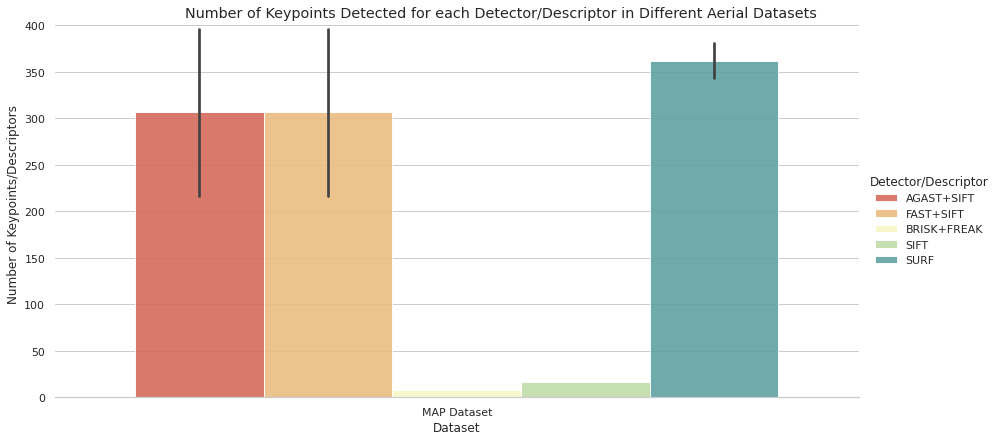

In [60]:
import seaborn as sns
sns.set_theme(style='whitegrid')


# Draw a nested barplot by species and sex
g = sns.catplot(
    data=df_numkey_5, kind="bar",
    x="Dataset", y="Number of Keypoints", hue="Detector/Descriptor",
    ci="sd", palette="Spectral", alpha=.9, height=6, aspect=2
)
g.despine(left=True)
g.set_axis_labels("Dataset", "Number of Keypoints/Descriptors")
g.legend.set_title("Detector/Descriptor")
g.fig.suptitle("Number of Keypoints Detected for each Detector/Descriptor in Different Aerial Datasets")

In [ ]:
g.savefig(f'drive/MyDrive/Num_Kypoints_7_{Dataset}.png')

In [61]:
df_numkey_5.to_csv(f'drive/MyDrive/Num_Kypoints_5_{Dataset}.csv')

In [ ]:
#print(len(num_matches_agast))

Total Number of Matches Detected for each Detector+Descriptor

In [55]:
#df_match_15['Number of Total Matches'] =  num_matches_agast + num_matches_akaze + num_matches_brisk + num_matches_daisy + num_matches_fast + num_matches_freak + num_matches_gftt + num_matches_kaze + num_matches_mser + num_matches_orb + num_matches_rootsift + num_matches_sift + num_matches_briefstar + num_matches_superpoint+ num_matches_surf+ num_matches_surfsift
d = {'Dataset': [f'{Dataset}']*(num_detectors*(len_files-1)), 'Number of Total Matches': num_matches_sift + num_matches_surf + num_matches_freak + num_matches_agast + num_matches_fast, 'Detector/Descriptor': ['AGAST+SIFT']*(len_files-1) + ['SIFT']*(len_files-1) + ['BRISK+FREAK']*(len_files-1) + ['FAST+SIFT']*(len_files-1) + ['SURF']*(len_files-1)}
df_match_5 = pd.DataFrame(data=d)
df_match_5['Number of Total Matches'] = df_match_5['Number of Total Matches']/(len_files-1)

Text(0.5, 0.98, 'Total Number of Matches Detected for each Detector/Descriptor in Different Aerial Datasets')

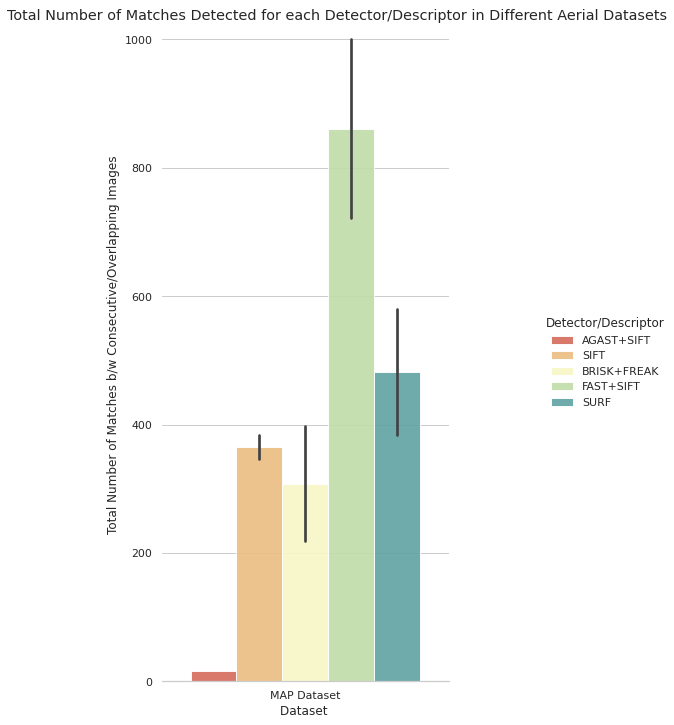

In [62]:
import seaborn as sns
sns.set_theme(style='whitegrid')


# Draw a nested barplot by species and sex
g = sns.catplot(
    data=df_match_5, kind="bar",
    x="Dataset", y="Number of Total Matches", hue="Detector/Descriptor",
    ci="sd", palette="Spectral", alpha=.9, height=10, aspect=0.5
)
g.despine(left=True)
g.set_axis_labels("Dataset ", "Total Number of Matches b/w Consecutive/Overlapping Images")
g.legend.set_title("Detector/Descriptor")
g.fig.suptitle("Total Number of Matches Detected for each Detector/Descriptor in Different Aerial Datasets")

In [ ]:
g.savefig(f'drive/MyDrive/Num_Matches_7_{Dataset}.png')

In [ ]:
#df_match_16.to_csv('drive/MyDrive/Num_Matches_16.csv')

Total Number of Good/Robust Matches (NN+Lowe+RANSAC) Detected for each Detector+Descriptor

In [63]:
df_match_5['Number of Good Matches'] = num_good_matches_agast + num_good_matches_fast + num_good_matches_freak + num_good_matches_surf + num_good_matches_sift
df_match_5['Number of Good Matches'] = df_match_5['Number of Good Matches']/(len_files-1)

Text(0.5, 0.98, 'Number of Good Matches (Lowe + RANSAC) Detected for each Detector/Descriptor in Different Aerial Datasets')

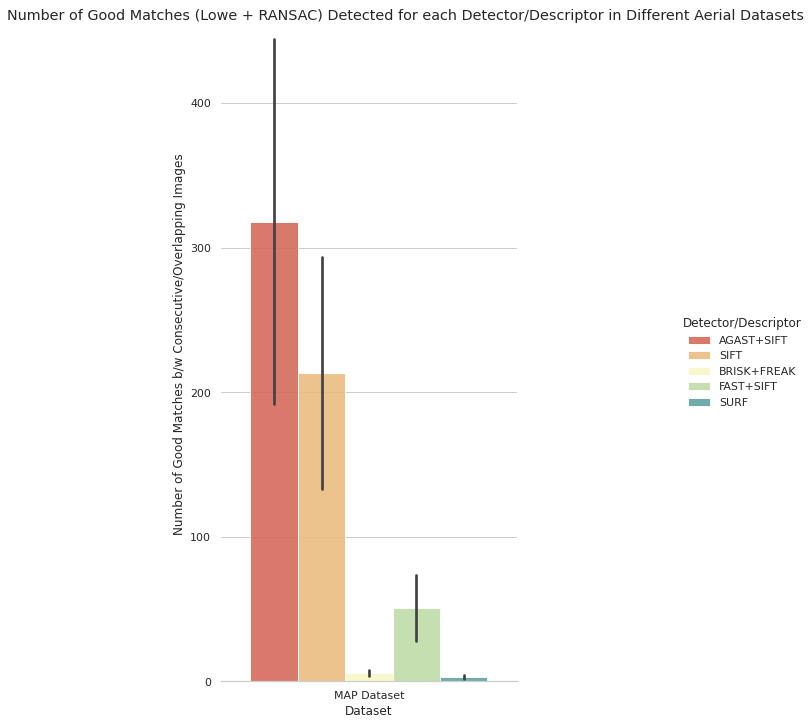

In [64]:
import seaborn as sns
sns.set_theme(style='whitegrid')


# Draw a nested barplot by species and sex
g = sns.catplot(
    data=df_match_5, kind="bar",
    x="Dataset", y="Number of Good Matches", hue="Detector/Descriptor",
    ci="sd", palette="Spectral", alpha=.9, height=10, aspect=0.5
)
g.despine(left=True)
g.set_axis_labels("Dataset", "Number of Good Matches b/w Consecutive/Overlapping Images")
g.legend.set_title("Detector/Descriptor")
g.fig.suptitle("Number of Good Matches (Lowe + RANSAC) Detected for each Detector/Descriptor in Different Aerial Datasets")

In [ ]:
g.savefig('drive/MyDrive/Num_Good_Matches_7.png')

In [ ]:
#df_match_16.to_csv('drive/MyDrive/Num_Good_Matches_16.csv')

Recall Rate for each Detector+Descriptor

In [65]:
df_match_5['Recall Rate of Matches'] = df_match_5['Number of Good Matches']/df_match_5['Number of Total Matches']

Text(0.5, 0.98, 'Recall Rate of Matches Detected (Good/Total) for each Detector/Descriptor in Different Aerial Datasets (Higher the Better)')

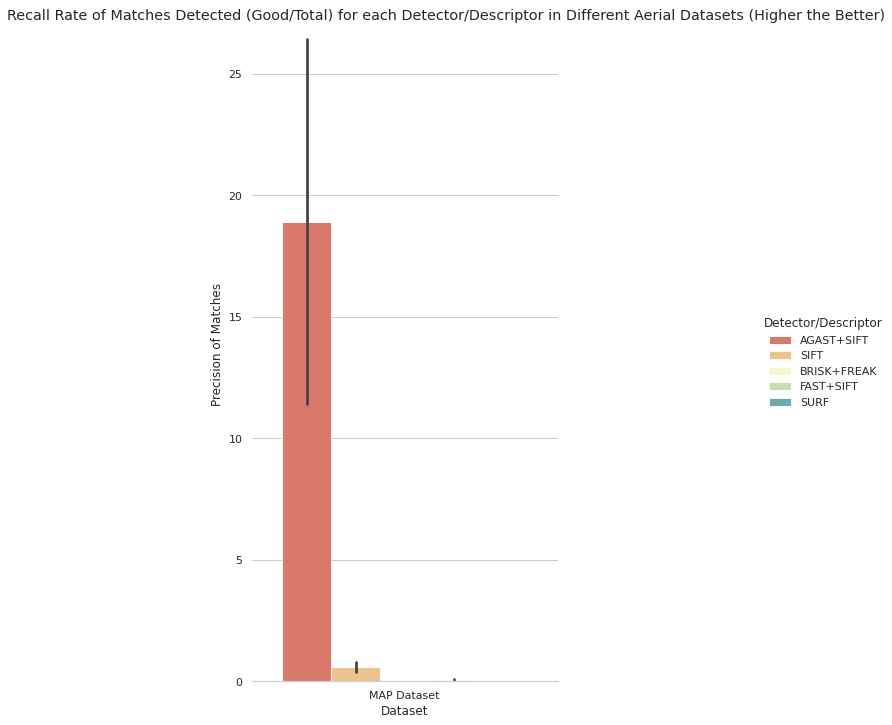

In [66]:
import seaborn as sns
sns.set_theme(style='whitegrid')


g = sns.catplot(
    data=df_match_5, kind="bar",
    x="Dataset", y="Recall Rate of Matches", hue="Detector/Descriptor",
    ci="sd", palette="Spectral", alpha=.9, height=10, aspect=0.5
)
g.despine(left=True)
g.set_axis_labels("Dataset", "Precision of Matches")
g.legend.set_title("Detector/Descriptor")
g.fig.suptitle("Recall Rate of Matches Detected (Good/Total) for each Detector/Descriptor in Different Aerial Datasets (Higher the Better)")

In [ ]:
g.savefig('drive/MyDrive/Recall_Rate_Matches_7.png')

1-Precision Rate for each Detector+Descriptor

In [67]:
df_match_5['1 - Precision Rate of Matches'] = (df_match_5['Number of Total Matches'] - df_match_5['Number of Good Matches'])/df_match_5['Number of Total Matches']

Text(0.5, 0.98, '1 - Precision rate of Matches Detected (False/Total Matches) for each Detector/Descriptor in Different Aerial Datasets (Lower the Better)')

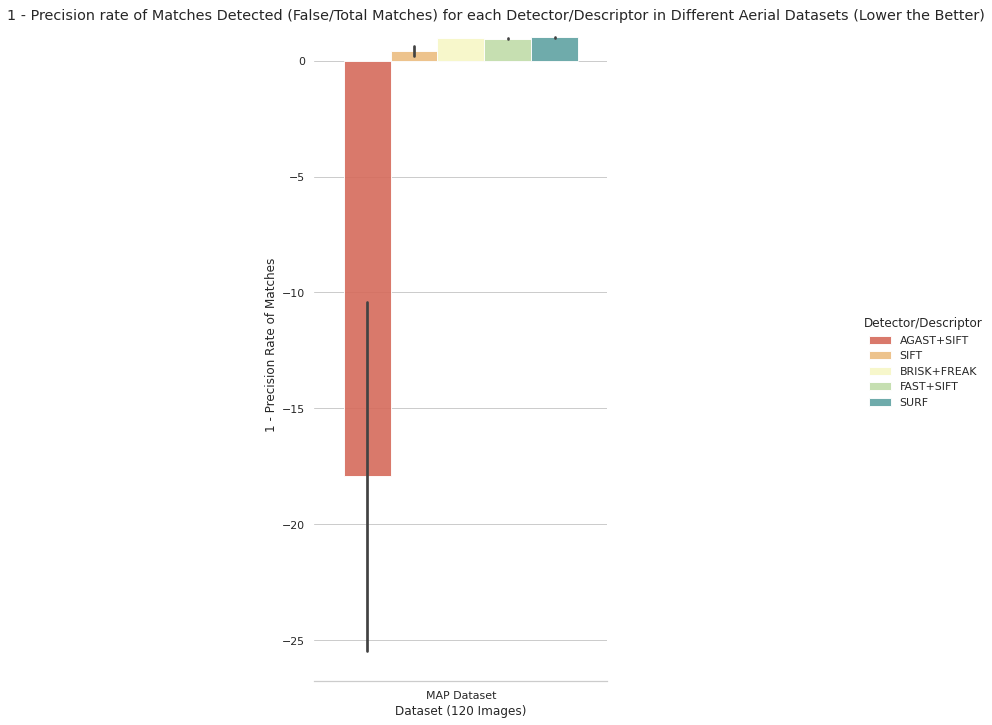

In [68]:
import seaborn as sns
sns.set_theme(style='whitegrid')


# Draw a nested barplot by species and sex
g = sns.catplot(
    data=df_match_5, kind="bar",
    x="Dataset", y="1 - Precision Rate of Matches", hue="Detector/Descriptor",
    ci="sd", palette="Spectral", alpha=.9, height=10, aspect=0.5
)
g.despine(left=True)
g.set_axis_labels("Dataset (120 Images)", "1 - Precision Rate of Matches")
g.legend.set_title("Detector/Descriptor")
g.fig.suptitle("1 - Precision rate of Matches Detected (False/Total Matches) for each Detector/Descriptor in Different Aerial Datasets (Lower the Better)")

In [ ]:
g.savefig('drive/MyDrive/One_minus_Precision_Rate_Matches_7.png')

F-Score for each Detector+Descriptor

In [69]:
df_match_5['F-Score'] = (2* (1 - df_match_5['1 - Precision Rate of Matches']) * df_match_5['Recall Rate of Matches'])/((1 - df_match_5['1 - Precision Rate of Matches']) + df_match_5['Recall Rate of Matches'])

Text(0.5, 0.98, 'F-Score of Matches Detected (2*P*R/P+R) for each Detector/Descriptor in Different Aerial Datasets (Higher the Better)')

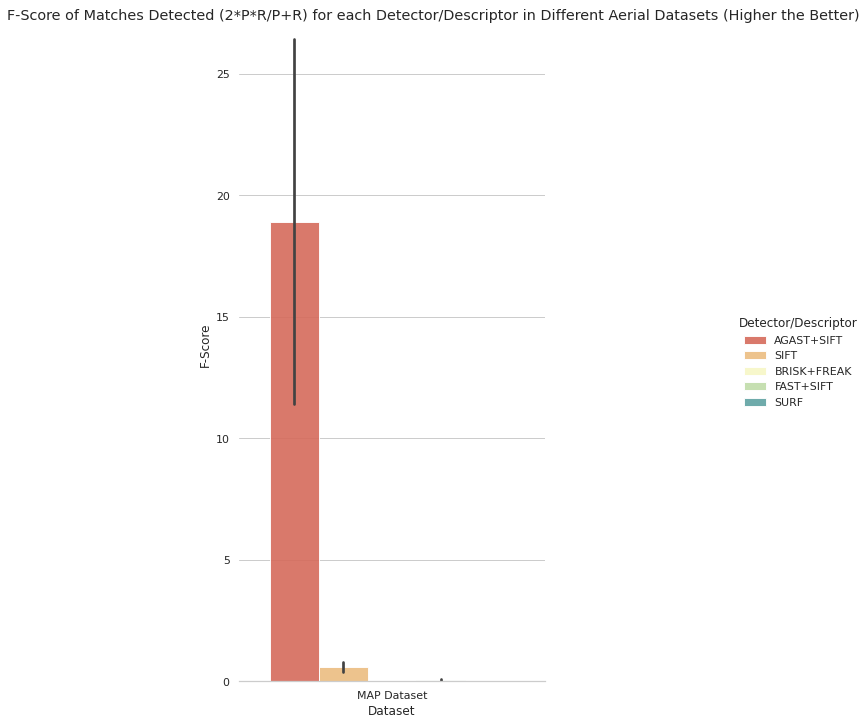

In [70]:
import seaborn as sns
sns.set_theme(style='whitegrid')


# Draw a nested barplot by species and sex
g = sns.catplot(
    data=df_match_5, kind="bar",
    x="Dataset", y="F-Score", hue="Detector/Descriptor",
    ci="sd", palette="Spectral", alpha=.9, height=10, aspect=0.5
)
g.despine(left=True)
g.set_axis_labels("Dataset", "F-Score")
g.legend.set_title("Detector/Descriptor")
g.fig.suptitle("F-Score of Matches Detected (2*P*R/P+R) for each Detector/Descriptor in Different Aerial Datasets (Higher the Better)")

In [ ]:
g.savefig('drive/MyDrive/F_Score_Rate_Matches_7.png')

In [71]:
df_match_5.to_csv('drive/MyDrive/All_metrics_5.csv')

Time for each Detector+Descriptor

In [72]:
d = {'Dataset': [f'{Dataset}']*(num_detectors), 'Time': [time_all[3]] + [time_all[0]] + [time_all[2]] + [time_all[1]] + [time_all[4]], 'Detector/Descriptor': ['AGAST+SIFT'] + ['FAST+SIFT']*(1) + ['BRISK+FREAK']*(1) + ['SURF']*(1) +  ['SIFT']*(1) }
df_time_5 = pd.DataFrame(data=d)

In [73]:
print(df_time_5)

       Dataset         Time Detector/Descriptor
0  MAP Dataset   201.549283          AGAST+SIFT
1  MAP Dataset   601.992521           FAST+SIFT
2  MAP Dataset   252.364458         BRISK+FREAK
3  MAP Dataset   195.850813                SURF
4  MAP Dataset  1072.240767                SIFT


Text(0.5, 0.98, 'Time taken during Feature Extraction by each Detector/Descriptor in Different Aerial Datasets (Lower the Better)')

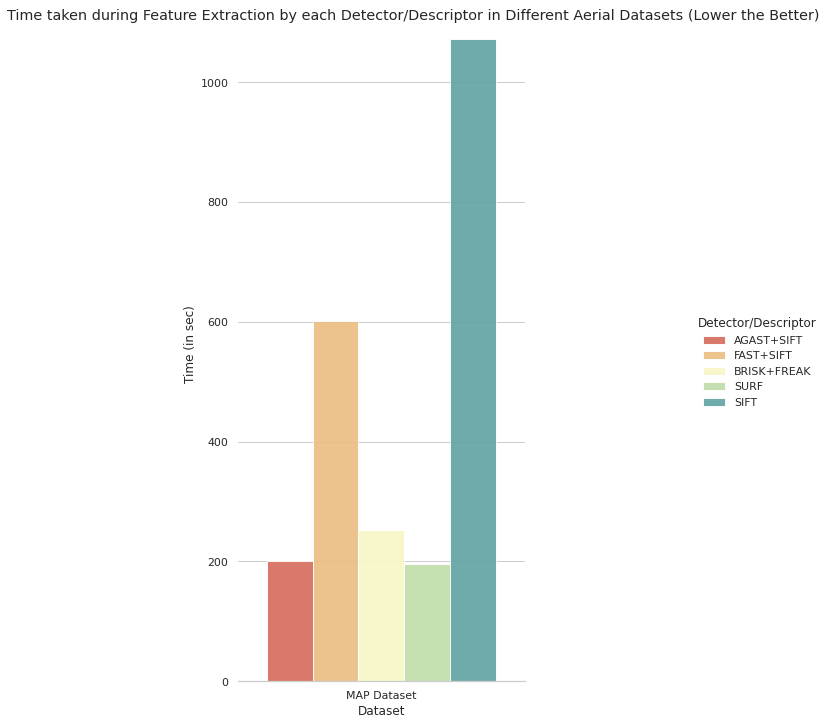

In [74]:
import seaborn as sns
sns.set_theme(style='whitegrid')


# Draw a nested barplot by species and sex
g = sns.catplot(
    data=df_time_5, kind="bar",
    x="Dataset", y="Time", hue="Detector/Descriptor",
    ci="sd", palette="Spectral", alpha=.9, height=10, aspect=0.5
)
g.despine(left=True)
g.set_axis_labels("Dataset", "Time (in sec)")
g.legend.set_title("Detector/Descriptor")
g.fig.suptitle("Time taken during Feature Extraction by each Detector/Descriptor in Different Aerial Datasets (Lower the Better)")

In [ ]:
g.savefig('drive/MyDrive/Time_7.png')

In [75]:
df_time_5.to_csv('drive/MyDrive/Time_5.csv')

Stitching with CPU